David Licián Martínez, 17/05/2025

# CASO PRÁCTICO

# PREDICCIÓN DEL PRECIO DE VEHÍCULOS PARA LA EMPRESA TELEFÓNICA VALTEL

## 1 Introducción: Enfoque metodológico

Para el desarrollo de este proyecto se ha optado por seguir la metodología CRISP-DM (Cross Industry Standard Process for Data Mining), un enfoque ampliamente utilizado en ciencia de datos por su carácter estructurado, flexible y adaptable a diferentes dominios.

Esta metodología nos permite abordar el problema de forma ordenada y comprensible, facilitando la toma de decisiones en cada etapa, desde la comprensión del negocio hasta la evaluación del modelo final. Su naturaleza cíclica permite revisar y corregir decisiones conforme se obtiene nueva información o se identifican patrones no esperados en los datos.

Una de sus principales ventajas es que permite centrarse tanto en los aspectos técnicos como en el objetivo de negocio, asegurando que el análisis no se desvincule de las necesidades reales que motivan el proyecto. Esto se alinea perfectamente con el enfoque de storytelling que buscamos en este trabajo.

En este proyecto, CRISP-DM ha guiado todo el flujo de trabajo: desde la comprensión inicial de los datos, la limpieza e imputación de valores nulos, el análisis exploratorio, hasta el entrenamiento y evaluación de varios modelos predictivos. Su uso ha sido clave para mantener la coherencia, justificar cada paso y facilitar una comunicación clara de los hallazgos.

## 2. Entendimiento del negocio

Valencian Telecommunications SA (VALTEL) es una compañía prestadora de servicios de telecomunicaciones que se ha especializado en ciudadanos no nacionales residentes en España.

En su plan estratégico de expansión, contempla la diversificación de servicios y se plantea incursionar en el mercado de coches de segunda mano para ofrecérselos a sus clientes a un precio competitivo.

El objetivo que VALTEL plantea a su equipo de ciencia de datos (nosotros) es elaborar un modelo que sea capaz de estimar el precio de un vehículo para desarrollar una tarifa competitiva que se integre en su aplicación móvil.

Para ello contamos con un dataset que contiene características de más de 10 mil automóviles, así como el precio de los mismos. El objetivo es inferir la var*iable *target “Precio” a partir del resto de variables. 

Seguiremos la metodología CRISP-DM a lo largo de todo el proceso. Para ello realizaremos el análisis exploratorio de datos, la preparación de los mismos, el entrenamiento del modelo y su evaluación, todo ello a través de un notebook de Python.

## 3. Entendimiento de los datos del negocio

### 3.1 Variables

Observamos que el dataset “Coches_Segunda_Mano” cuenta con 11914 registros y 16 campos. Las variables que representan dichos campos, así como sus características principales, son:

- <strong>Marca</strong>: 48 marcas de automóviles. Variable categórica (nivel <strong>nominal</strong>).
- <strong>Modelo</strong>: 915 modelos de automóviles diferentes. Variable categórica (nivel <strong>nominal</strong>).
- <strong>Año</strong>: Año de fabricación del vehículo, abarcando desde 1990 hasta 2017. Variable numérica discreta (nivel <strong>intervalo</strong>).
- <strong>Combustible</strong>: 11 tipos de combustible. Variable categórica (nivel <strong>nominal</strong>)
- <strong>CV</strong>: Caballos de potencia. Variable numérica discreta (nivel <strong>ratio</strong>).
- <strong>Cilindros</strong>: Número de cilindros del motor. Variable numérica discreta (nivel <strong>ratio</strong>).
- <strong>Transmisión</strong>: 5 tipos de transmisión. Variable categórica (nivel <strong>nominal</strong>).
- <strong>Tracción</strong>: 4 tipos de tracción. Variable categórica (nivel <strong>nominal</strong>).
- <strong>Puertas</strong>: 4 valores distintos con el número de puertas. Variable numérica discreta (nivel <strong>ratio</strong>).
- <strong>Mercado</strong>: 72 valores diferentes identificando el tipo de mercado al que pertenece el vehículo (lujo, crossover, etc.). Variable categórica (nivel <strong>nominal</strong>).
- <strong>Tamaño</strong>: 3 valores diferentes de tamaño de vehículo. Variable categórica (nivel <strong>ordinal</strong>).
- <strong>Estilo</strong>: 16 tipos de estilo de vehículo. Variable categórica (nivel <strong>nominal</strong>).
- <strong>Consumo Carretera</strong>: Litros por cada 100 km en carretera. Variable numérica discreta (nivel <strong>ratio</strong>).
- <strong>Consumo Ciudad</strong>: Litros por cada 100 km en ciudad. Variable numérica discreta (nivel <strong>ratio</strong>).
- <strong>Popularidad</strong>: Número que indica la popularidad del vehículo (probablemente derivado de interacciones o encuestas). Variable numérica discreta (nivel <strong>ratio</strong>).
- <strong>Precio</strong>: Precio del automóvil (target). Variable numérica continua (nivel <strong>ratio</strong>).

El conocimiento del tipo y nivel de variable nos facilita mucho la tarea de relacionar variables entre sí, pues el gráfico que escojamos para representar 2 o más variables depende de estas 2 características.

In [1]:
# Importamos librerías
import numpy as np
import pandas as pd
import statistics as stats
from scipy.stats import chi2_contingency, linregress

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
def impute_by_subgroup(df):
    """
    Esta función imputa valores faltantes en un dataframe de datos de automóviles.
    Para cada variable con valores nulos, identifica subgrupos similares basados en otras
    características del vehículo y utiliza una medida de centralidad de esos subgrupos para realizar
    la imputación de manera más precisa y contextualizada.
    """
    
    # Índices de nulos por variable
    var_indexes = {
        "combustible": df[df["combustible"].isna()].index,
        "cv": df[df["cv"].isna()].index,
        "cilindros": df[df["cilindros"].isna()].index,
        "transmision": df[df["transmision"].isna()].index,
        "puertas": df[df["puertas"].isna()].index,
        "mercado": df[df["mercado"].isna()].index
    }
    
    # Subgrupos por variable
    subgroup_dict = {
        "combustible": ["consumo_carretera", "tamaño", "transmision"],
        "cv": ["cilindros", "tamaño", "transmision", "combustible"],
        "cilindros": ["cv", "tamaño", "combustible", "transmision"],
        "transmision": ["consumo_carretera", "marca", "cv", "combustible", "traccion"],
        "puertas": ["tamaño", "año", "modelo", "estilo"],
        "mercado": ["marca", "modelo"]
    }

    
    # Funciones de centralidad por variable
    centrality_funcs = {
        "marca": lambda x: x.mode().iloc[0] if not x.mode().empty else df["marca"].mode().iloc[0],
        "modelo": lambda x: x.mode().iloc[0] if not x.mode().empty else df["modelo"].mode().iloc[0],
        "año": lambda x: x.mode().iloc[0] if not x.mode().empty else df["año"].mode().iloc[0],
        "combustible": lambda x: x.mode().iloc[0] if not x.mode().empty else df["combustible"].mode().iloc[0],
        "cv": lambda x: int(np.median(x)) if len(x) > 0 else int(df["cv"].median()),
        "cilindros": lambda x: int(np.median(x)) if len(x) > 0 else int(df["cilindros"].median()),
        "transmision": lambda x: x.mode().iloc[0] if not x.mode().empty else df["transmision"].mode().iloc[0],
        "traccion": lambda x: x.mode().iloc[0] if not x.mode().empty else df["traccion"].mode().iloc[0],
        "puertas": lambda x: int(np.median(x)) if len(x) > 0 else int(df["puertas"].median()),
        "mercado": lambda x: x.mode().iloc[0] if not x.mode().empty else df["mercado"].mode().iloc[0],
        "tamaño": lambda x: x.mode().iloc[0] if not x.mode().empty else df["tamaño"].mode().iloc[0],
        "estilo": lambda x: x.mode().iloc[0] if not x.mode().empty else df["estilo"].mode().iloc[0],
        "consumo_carretera": lambda x: int(np.median(x)) if len(x) > 0 else int(df["consumo_carretera"].median()),
        "consumo_ciudad": lambda x: int(np.median(x)) if len(x) > 0 else int(df["consumo_ciudad"].median()),
        "popularidad": lambda x: int(np.median(x)) if len(x) > 0 else int(df["popularidad"].median()),
        "precio": lambda x: int(np.median(x)) if len(x) > 0 else int(df["precio"].median())
    }
    
    # Para cada variable a imputar
    for var, indexes in var_indexes.items():
        # Dataframe de referencia sin nulos en var
        df_aux = df.drop(index=indexes).copy()
        
        # Para cada índice
        for idx in indexes:
            # Extraer valores de las variables del subgrupo
            subgroup_vars = subgroup_dict[var]
            subgroup_vals = df.loc[idx, subgroup_vars]
            
            # Construir el filtro acumulativo
            filt = pd.Series(True, index=df_aux.index)
            for sv, sv_val in zip(subgroup_vars, subgroup_vals):
                if sv in ("consumo_carretera", "_"):
                    # Tolerancia +-10%
                    tol = 0.10
                    lower, upper = sv_val * (1 - tol), sv_val * (1 + tol)
                    filt &= df_aux[sv].between(lower, upper)
                else:
                    filt &= (df_aux[sv] == sv_val)
                    
            df_filtered = df_aux[filt]
    
            # Calcular valor central
            central_value = centrality_funcs[var](df_filtered[var])
            # Asignar imputación
            df.at[idx, var] = central_value # Más eficiente que .loc para asignar un valor a una única celda

    return df

In [3]:
def normalise_text(df):
    """
    Toma un dataframe y en cada columna de tipo objeto:
        - Sustituye espacios en blanco por guiones bajos.
        - Convierte el texto a minúsculas.
        - Ordena alfabéticamente si existen subcategorías dentro de una variable.
    """
    # Crear una copia para no modificar el original inadvertidamente
    df_normalised = df.copy()
    
    for col in df.columns:
        if df[col].dtype == "object":  # Corregido: añadido el colon (:)
            # Extraer valores
            values = df_normalised[col].values
            
            for i, text in enumerate(values):
                # Incorporar NaN sin cambios
                if pd.isna(text):
                    values[i] = text
                    continue
                    
                # Convertir a string si no lo es
                text = str(text)
                
                # Reemplazar espacios en blanco
                text = text.replace(" ", "_")

                # Convertir a minúscula
                text = text.lower()

                # Ordenar subcategorías alfabéticamente
                if "," in text:
                    parts = text.split(",")
                    text = ",".join(sorted(parts))  # Sorted es mejor que np.sort para strings

                # Aplicar cambios
                values[i] = text
    
    return df_normalised

In [4]:
def to_int_converter(df):
    cols = ["cv", "cilindros", "puertas", "consumo_carretera", "precio"]
    return df.copy().astype({col: int for col in cols})

In [5]:
def train_evaluate(model, param_grid, X_train, X_test, y_train, y_test, label):
    """
    Esta función entrena un modelo de machine learning utilizando búsqueda de hiperparámetros 
    con validación cruzada, y evalúa su rendimiento en el conjunto de prueba. Devuelve métricas
    de evaluación (MAE, RMSE, R²) y el mejor modelo encontrado durante la optimización de 
    hiperparámetros.
    """
    gs = GridSearchCV(model, param_grid, cv=3,
                      scoring="neg_root_mean_squared_error", n_jobs=-1)
    gs.fit(X_train, y_train)
    best_model = gs.best_estimator_
    
    y_pred = best_model.predict(X_test)
    mae  = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2   = r2_score(y_test, y_pred)
    
    print(f"\n--- {label} ---")
    print("Mejores hiperparámetros:", gs.best_params_)
    print(f"MAE:  {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²:   {r2:.4f}")
    
    return best_model

In [6]:
def plot_feature_importance(model, feature_names, title, top_n=10):
    """Grafica las N variables más importantes según el modelo"""
    importances = model.feature_importances_
    indexes = np.argsort(importances)[::-1][:top_n]  # Top N
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=importances[indexes], y=np.array(feature_names)[indexes], palette="viridis")
    plt.title(f"Top {top_n} Features - {title}")
    plt.xlabel("Importancia")
    plt.ylabel("Características")
    plt.tight_layout()
    plt.show()

In [7]:
# Comprobar que detecta la GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Physical GPUs available: ", len(physical_devices))
print(physical_devices)

"""
Esto es una pequeña ayuda para el entrenamiento del modelo XGBoost,
pero no para los modelos DecisionTree ni RandomForest, pues no
soportan entrenamiento con GPU.

En caso de querer usar esta pequeña ventaja, hay que descomentar
la línea de código con la sentencia ' tree_method="gpu_hist" '
en la configuración del modelo XGBoost.
"""

Physical GPUs available:  0
[]


'\nEsto es una pequeña ayuda para el entrenamiento del modelo XGBoost,\npero no para los modelos DecisionTree ni RandomForest, pues no\nsoportan entrenamiento con GPU.\n\nEn caso de querer usar esta pequeña ventaja, hay que descomentar\nla línea de código con la sentencia \' tree_method="gpu_hist" \'\nen la configuración del modelo XGBoost.\n'

In [8]:
# Importar dataset
df_raw = pd.read_csv("Coches_Segunda_Mano.csv")
df_raw.head(2)

Marca      Modelo   Año                  Combustible     CV  Cilindros  \
0   BMW  1 Series M  2011  premium unleaded (required)  335.0        6.0   
1   BMW    1 Series  2011  premium unleaded (required)  300.0        6.0   

  Transmisión          Tracción  Puertas  \
0      MANUAL  rear wheel drive      2.0   
1      MANUAL  rear wheel drive      2.0   

                                 Mercado   Tamaño       Estilo  \
0  Factory Tuner,Luxury,High-Performance  Compact        Coupe   
1                     Luxury,Performance  Compact  Convertible   

   Consumo Carretera  Consumo Ciudad  Popularidad   Precio  
0               26.0            19.0         3916  46135.0  
1               28.0            19.0         3916  40650.0

In [9]:
df_raw.columns

Index(['Marca', 'Modelo', 'Año', 'Combustible', 'CV', 'Cilindros',
       'Transmisión', 'Tracción', 'Puertas', 'Mercado', 'Tamaño', 'Estilo',
       'Consumo Carretera', 'Consumo Ciudad', 'Popularidad', 'Precio'],
      dtype='object')

In [10]:
# Estandarizar nombres de variables (snake_case)
df = df_raw.copy()
df.rename(columns={
    "Marca": "marca",
    "Modelo": "modelo",
    "Año": "año",
    "Combustible": "combustible",
    "CV": "cv",
    "Cilindros": "cilindros",
    "Transmisión": "transmision",
    "Tracción": "traccion",
    "Puertas": "puertas",
    "Mercado": "mercado",
    "Tamaño": "tamaño",
    "Estilo": "estilo",
    "Consumo Carretera": "consumo_carretera",
    "Consumo Ciudad": "consumo_ciudad",
    "Popularidad": "popularidad",
    "Precio": "precio"
    }, inplace=True)

In [11]:
categorical_variables = ["marca", "modelo", "combustible", "transmision", "traccion", "mercado", "tamaño", "estilo"]

# Variables categóricas
for x in categorical_variables:
    list = df[x].unique() # Valores únicos
    print(f"{x}: {len(list)}") # Nombre de la variable
    print(list[:5]) # Primeros 5 elementos
    print() # Espacio en blanco

# Variables numéricas
df.describe()

marca: 48
['BMW' 'Audi' 'FIAT' 'Mercedes-Benz' 'Chrysler']

modelo: 915
['1 Series M' '1 Series' '100' '124 Spider' '190-Class']

combustible: 11
['premium unleaded (required)' 'regular unleaded'
 'premium unleaded (recommended)' 'flex-fuel (unleaded/E85)' 'diesel']

transmision: 5
['MANUAL' 'AUTOMATIC' 'AUTOMATED_MANUAL' 'DIRECT_DRIVE' 'UNKNOWN']

traccion: 4
['rear wheel drive' 'front wheel drive' 'all wheel drive'
 'four wheel drive']

mercado: 72
['Factory Tuner,Luxury,High-Performance' 'Luxury,Performance'
 'Luxury,High-Performance' 'Luxury' 'Performance']

tamaño: 3
['Compact' 'Midsize' 'Large']

estilo: 16
['Coupe' 'Convertible' 'Sedan' 'Wagon' '4dr Hatchback']



año           cv     cilindros       puertas  \
count  11914.000000  11845.00000  11884.000000  11908.000000   
mean    2010.384338    249.38607      5.628829      3.436093   
std        7.579740    109.19187      1.780559      0.881315   
min     1990.000000     55.00000      0.000000      2.000000   
25%     2007.000000    170.00000      4.000000      2.000000   
50%     2015.000000    227.00000      6.000000      4.000000   
75%     2016.000000    300.00000      6.000000      4.000000   
max     2017.000000   1001.00000     16.000000      4.000000   

       consumo_carretera  consumo_ciudad   popularidad        precio  
count       11914.000000    11914.000000  11914.000000  1.191400e+04  
mean           26.637485       19.733255   1554.911197  4.059474e+04  
std             8.863001        8.987798   1441.855347  6.010910e+04  
min            12.000000        7.000000      2.000000  2.000000e+03  
25%            22.000000       16.000000    549.000000  2.100000e+04  
50%            26.000000       18.000000   1385.000000  2.999500e+04  
75%            30.000000       22.000000   2009.000000  4.223125e+04  
max           354.000000      137.000000   5657.000000  2.065902e+06

### 3.2 Nulos, *outliers* e inconsistencias

Previo a la preparación de los datos para el modelo de *machine learning*, ML, nos disponemos a analizar la calidad de estos.

Apreciamos en el "describe()" anterior que, de entre las variables numéricas, las variables "CV", "Cilindros" y "Puertas" son las que contienen nulos. 

Por otro lado, la variable "Cilindros" contiene valores 0 que consideraremos como valores acertados, pues es posible que en el dataset se hayan incluido motores rotativos que en sí no tienen ningún cilindro convencional.

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11914 entries, 0 to 11913
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   marca              11914 non-null  object 
 1   modelo             11914 non-null  object 
 2   año                11914 non-null  int64  
 3   combustible        11911 non-null  object 
 4   cv                 11845 non-null  float64
 5   cilindros          11884 non-null  float64
 6   transmision        11914 non-null  object 
 7   traccion           11914 non-null  object 
 8   puertas            11908 non-null  float64
 9   mercado            8172 non-null   object 
 10  tamaño             11914 non-null  object 
 11  estilo             11914 non-null  object 
 12  consumo_carretera  11914 non-null  float64
 13  consumo_ciudad     11914 non-null  float64
 14  popularidad        11914 non-null  int64  
 15  precio             11914 non-null  float64
dtypes: float64(6), int64(2

In [13]:
# Conteo de nulos: NaN y campos vacíos
df.isna().sum()

marca                   0
modelo                  0
año                     0
combustible             3
cv                     69
cilindros              30
transmision             0
traccion                0
puertas                 6
mercado              3742
tamaño                  0
estilo                  0
consumo_carretera       0
consumo_ciudad          0
popularidad             0
precio                  0
dtype: int64

In [14]:
# Contar los nulos expresados de otra forma en variables categóricas: UNKNOWN, NULL, NONE, etc.
print("Variables categóricas:\n")
for x in categorical_variables:
    list = df[x].value_counts()
    print(f"{x}: {len(list)}")
    print(list)
    print()

Variables categóricas:

marca: 48
marca
Chevrolet        1123
Ford              881
Volkswagen        809
Toyota            746
Dodge             626
Nissan            558
GMC               515
Honda             449
Mazda             423
Cadillac          397
Mercedes-Benz     353
Suzuki            351
BMW               334
Infiniti          330
Audi              328
Hyundai           303
Volvo             281
Subaru            256
Acura             252
Kia               231
Mitsubishi        213
Lexus             202
Buick             196
Chrysler          187
Pontiac           186
Lincoln           164
Oldsmobile        150
Land Rover        143
Porsche           136
Saab              111
Aston Martin       93
Plymouth           82
Bentley            74
Ferrari            69
FIAT               62
Scion              60
Maserati           58
Lamborghini        52
Rolls-Royce        31
Lotus              29
Tesla              18
HUMMER             17
Maybach            16
Alfa Romeo    

Vemos que la variable "Transmision" contiene nulos en forma de "UNKNOWN".

In [15]:
# Homogeneizar nulos
df["transmision"].replace("UNKNOWN", np.nan, inplace=True)

Analizamos con más detenimiento las variables "Modelo" y "Mercado"

In [16]:
for value, count in df["modelo"].value_counts().items():
    print(f"{value}: {count}")

Silverado 1500: 156
Tundra: 140
F-150: 126
Sierra 1500: 90
Beetle Convertible: 89
Tacoma: 80
GTI: 76
Frontier: 76
Accord: 75
Beetle: 75
Civic: 68
Dakota: 65
Ram Pickup 1500: 62
Jetta: 61
Corvette: 60
911: 58
C/K 1500 Series: 56
XC60: 54
Colorado: 54
3: 53
Sienna: 51
370Z: 51
Golf GTI: 50
Silverado 1500 Classic: 49
Sierra 1500 Classic: 49
E-Class: 49
Transit Wagon: 48
F-250: 48
Canyon: 48
Pilot: 48
A3: 47
Transit Connect: 46
Passat: 45
Jetta GLI: 44
Jetta SportWagen: 42
CTS: 42
B-Series Pickup: 40
RAM 150: 40
Sonic: 40
XL7: 39
ATS: 39
Truck: 38
Sorento: 38
C-Class: 37
Ranger: 37
Sonata: 36
Q50: 36
Expedition: 36
New Beetle: 36
Range Rover: 35
ATS Coupe: 35
S-10: 35
Titan: 35
MDX: 34
350Z: 34
Corolla: 34
Forenza: 34
3 Series: 34
Impreza: 34
SX4: 33
Camaro: 33
Challenger: 33
CC: 32
Kizashi: 32
V8 Vantage: 32
9-3: 32
Acadia: 32
CR-V: 32
Camry Solara: 32
Journey: 31
Jimmy: 31
Esteem: 31
Aerio: 31
S-10 Blazer: 31
Tribute: 31
300: 30
Escalade: 30
B9 Tribeca: 30
Escalade ESV: 30
TrailBlazer: 3

In [17]:
for value, count in df["mercado"].value_counts().items():
    print(f"{value}: {count}")

Crossover: 1110
Flex Fuel: 872
Luxury: 855
Luxury,Performance: 673
Hatchback: 641
Performance: 601
Crossover,Luxury: 410
Luxury,High-Performance: 334
Exotic,High-Performance: 261
Hatchback,Performance: 252
Factory Tuner,Luxury,High-Performance: 215
High-Performance: 199
Hybrid: 123
Crossover,Luxury,Performance: 113
Factory Tuner,High-Performance: 106
Factory Tuner,Performance: 92
Flex Fuel,Performance: 87
Diesel: 84
Exotic,Luxury,High-Performance: 79
Crossover,Hatchback: 72
Hatchback,Hybrid: 72
Crossover,Performance: 69
Crossover,Flex Fuel: 64
Exotic,Factory Tuner,Luxury,High-Performance: 52
Luxury,Hybrid: 52
Diesel,Luxury: 51
Hatchback,Luxury: 46
Crossover,Hybrid: 42
Flex Fuel,Luxury: 39
Hatchback,Luxury,Performance: 38
Exotic,Luxury,Performance: 36
Crossover,Luxury,Diesel: 34
Flex Fuel,Luxury,High-Performance: 33
Factory Tuner,Luxury,Performance: 31
Flex Fuel,Luxury,Performance: 28
Crossover,Factory Tuner,Luxury,High-Performance: 26
Crossover,Luxury,Hybrid: 24
Hatchback,Factory Tuner

Ninguna de estas 2 variables contiene nulos en expresiones alternativas.

In [18]:
# Conteo de nulos: NaN y campos vacíos
df.isna().sum()

marca                   0
modelo                  0
año                     0
combustible             3
cv                     69
cilindros              30
transmision            19
traccion                0
puertas                 6
mercado              3742
tamaño                  0
estilo                  0
consumo_carretera       0
consumo_ciudad          0
popularidad             0
precio                  0
dtype: int64

In [19]:
# Porcentaje de nulos
round(df.isna().sum() / len(df) * 100, 2)

marca                 0.00
modelo                0.00
año                   0.00
combustible           0.03
cv                    0.58
cilindros             0.25
transmision           0.16
traccion              0.00
puertas               0.05
mercado              31.41
tamaño                0.00
estilo                0.00
consumo_carretera     0.00
consumo_ciudad        0.00
popularidad           0.00
precio                0.00
dtype: float64

Por lo tanto, los nulos que presenta el dataset son:

- <strong>Combustible</strong>: 3 nulos.
- <strong>CV</strong>: 69 nulos.
- <strong>Cilindros</strong>: 30 nulos.
- <strong>Transmisión</strong>: 19 nulos.
- <strong>Puertas</strong>: 6 nulos.
- <strong>Mercado</strong>: 3742 nulos.

La variable "Mercado" será problemática, pues contiene más de un 30% de nulos. 

Además, conviene revisar si el dataset contiene duplicidades.

In [20]:
# Revisar duplicados
print(f"El dataset contiene {df.duplicated().sum()} duplicados.")

El dataset contiene 715 duplicados.


Por lo que vemos, este sí contiene duplicados. Procedamos a eliminarlos.

In [21]:
df.drop_duplicates(keep="first", inplace=True, ignore_index=True)

Habiendo estudiado la presencia de valores nulos e duplicados, nos queda revisar las inconsistencias en el dataset. Dado que el departamento de I+D de VALTEL solo nos ha proporcionado un dataset, no podemos confirmar la veracidad de este a través de diferentes fuentes, pero sí podemos verificar su consistencia interna.

Un procedimiento común para evitar las inconsistencias consiste en:
- Formatear todo el texto a mayúsculas/minísculas.
- Eliminar espacios en blanco.
- Ordenar alfabéticamente las subcategorías de una variable (especialmente útil en la variable "Mercado").

In [22]:
# Normalizar dataframe
df = normalise_text(df)

In [23]:
df["mercado"].value_counts()

mercado
crossover                                          1075
flex_fuel                                           855
luxury                                              819
luxury,performance                                  659
hatchback                                           574
                                                   ... 
crossover,exotic,luxury,performance                   1
exotic,high-performance,hybrid,luxury                 1
crossover,exotic,high-performance,luxury              1
factory_tuner,flex_fuel,high-performance,luxury       1
hybrid,performance                                    1
Name: count, Length: 71, dtype: int64

In [24]:
# Revisar duplicados nuevamente por si acaso
print(f"El dataset contiene {df.duplicated().sum()} duplicados.")

El dataset contiene 0 duplicados.


Para finalizar con este apartado representaremos *boxplots* que muestren los valores atípicos.

In [25]:
# Variables numéricas
numerical_variables = [var for var in df.columns if var not in categorical_variables]

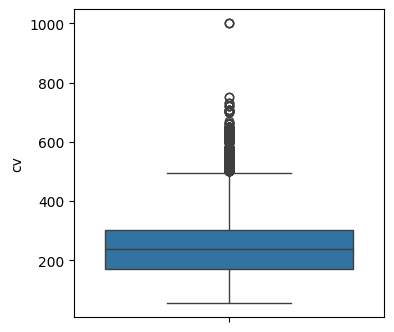

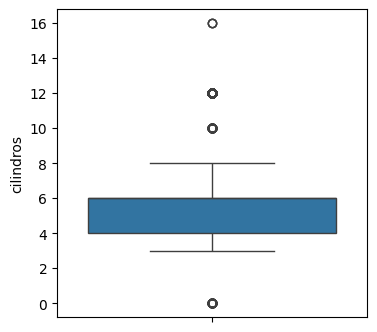

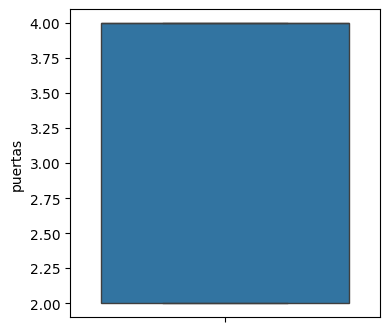

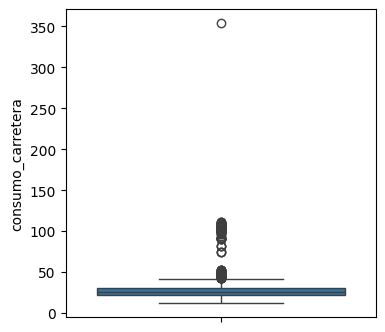

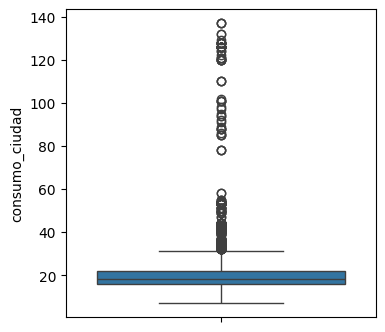

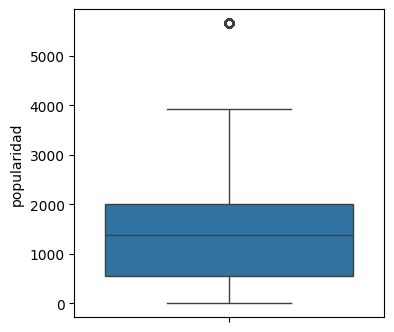

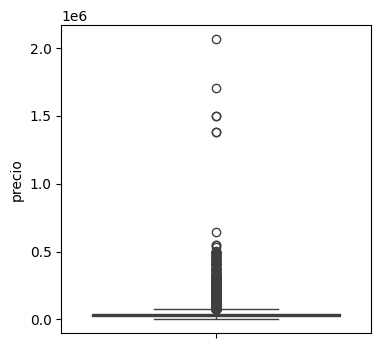

In [26]:
# Boxplots
for i, var in enumerate(numerical_variables):
    if var != "año":
        fig, ax = plt.subplots(figsize=(4, 4))
        sns.boxplot(data=df, y=var)
        plt.show()

A simple vista podemos ver que las variables "CV", "Consumo Carretera", "Consumo Ciudad" y "Precio" contienen una alta cantidad de valores atípicos.

## 4. Preparación de los Datos

### 4.1 Exploratory Data Analysis (EDA)

Dado que conviene analizar visualmente las variables en mayor profundidad, es necesario comenzar por un análisis univariante. Después, proseguir con un análisis bivariante (entre la variable de estudio y la variable *target* "Precio") para finalizar con un análisis multivariante.

#### 4.1.1 Univariante

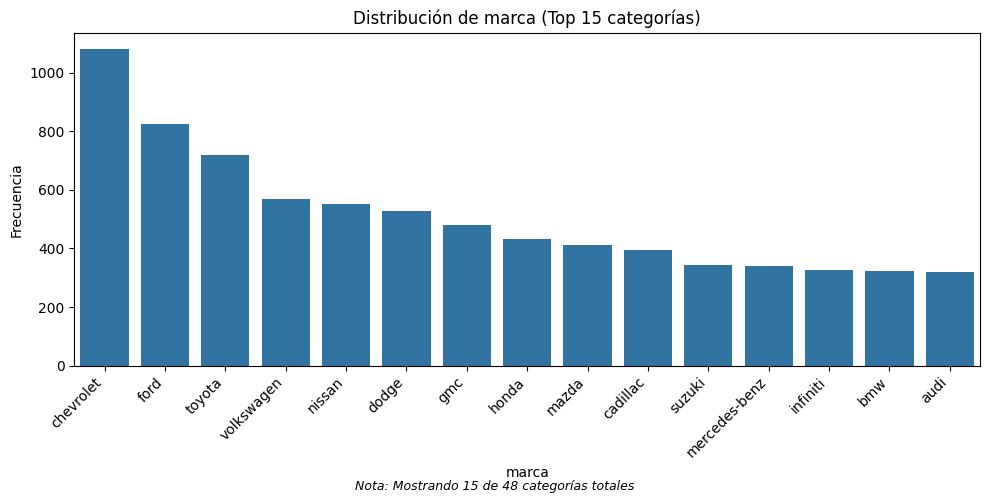

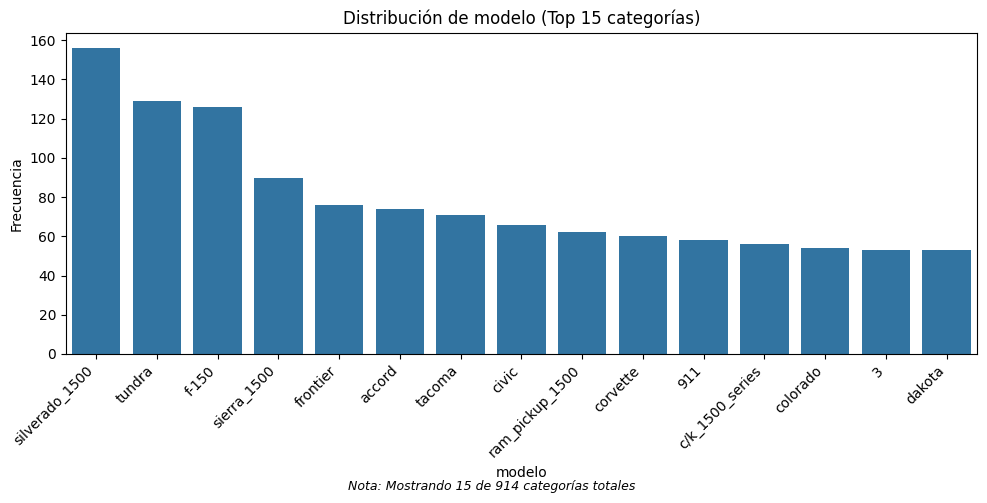

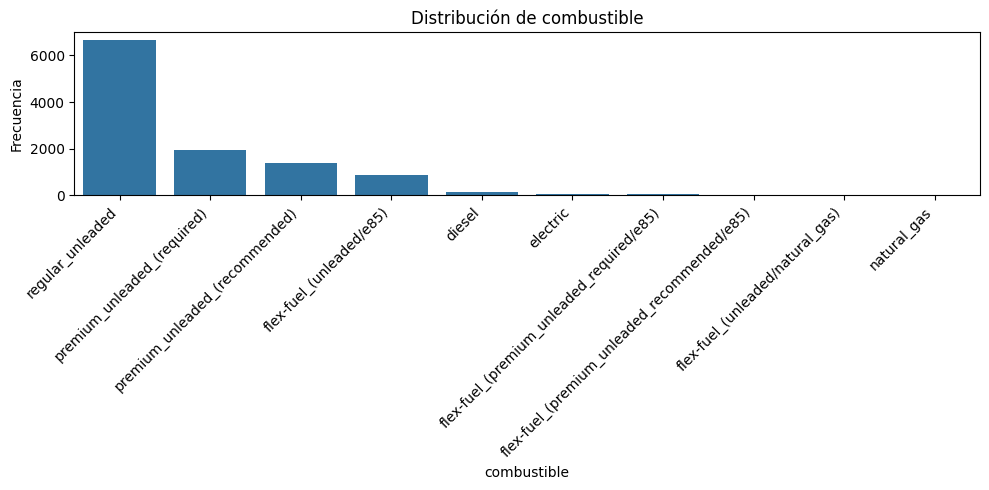

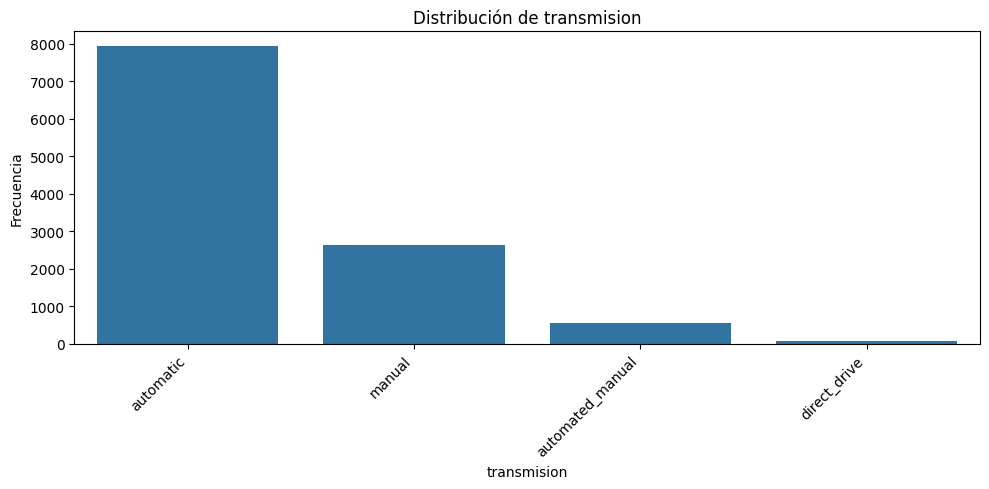

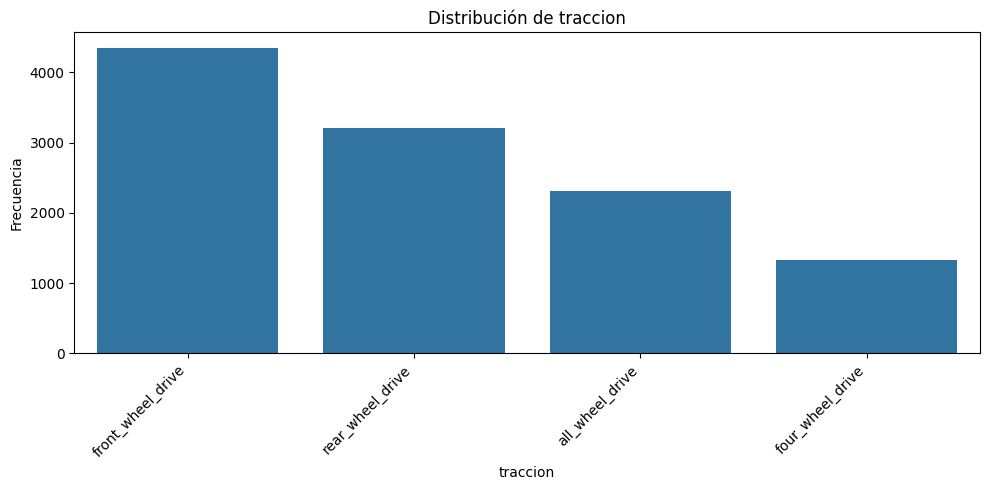

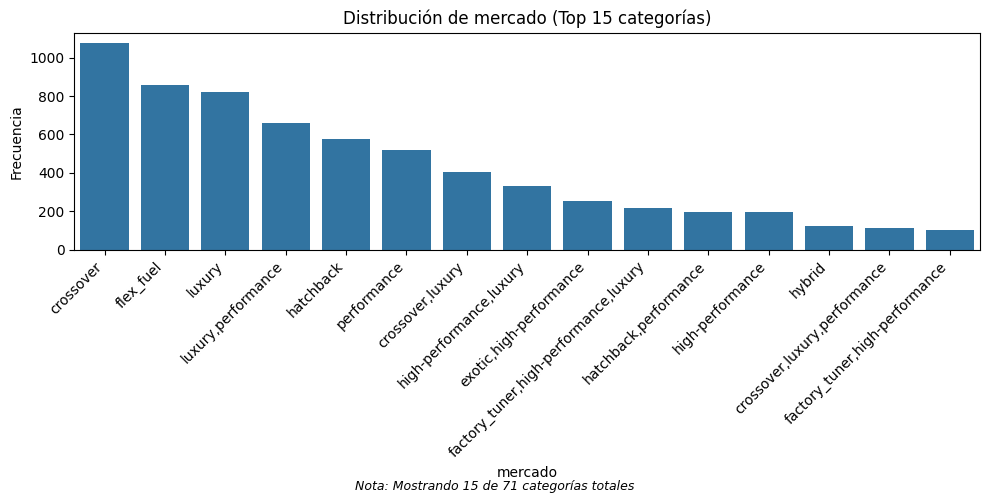

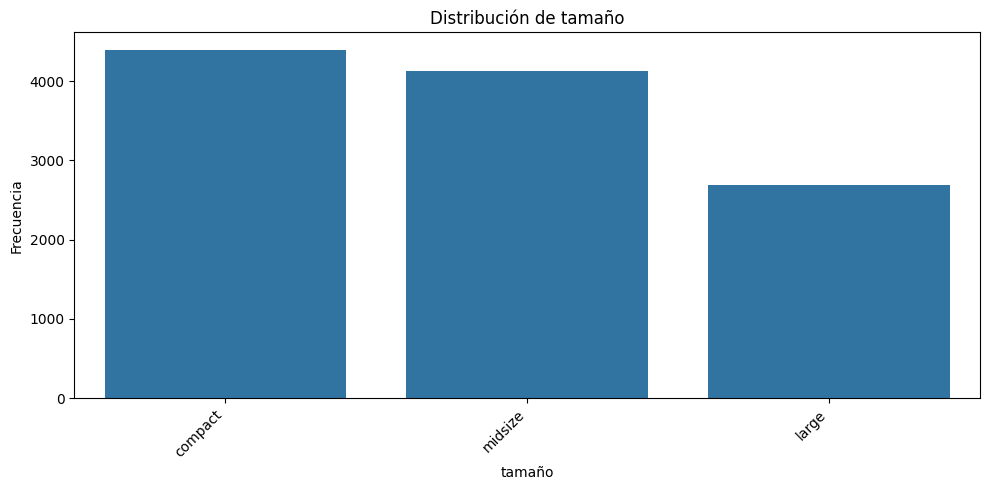

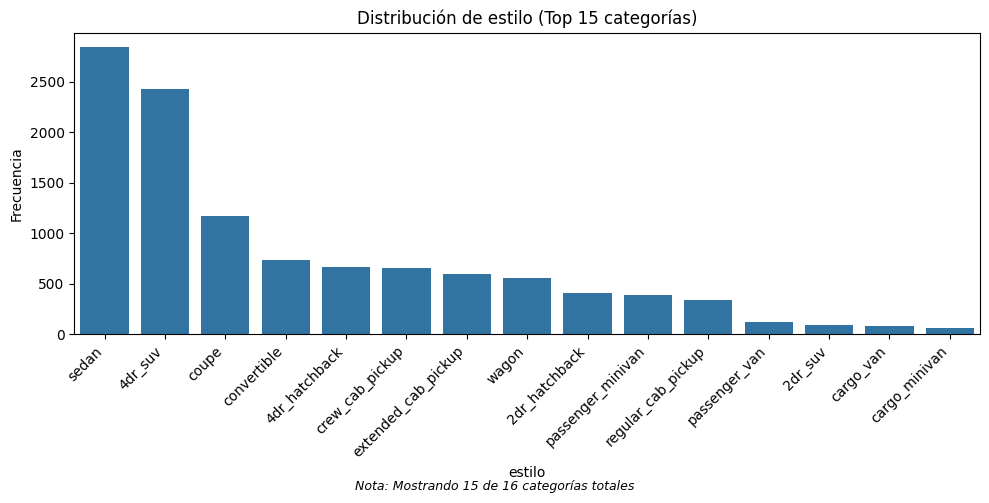

In [27]:
# Diagrama de barras top
for var in categorical_variables:
    # Obtener las n categorías más frecuentes
    n = 15
    top_categories = df[var].value_counts().nlargest(n)
    total_categories = df[var].nunique()
    
    # Crear la figura
    fig, ax = plt.subplots(figsize=(10, 5))

    # Crear el gráfico de barras
    sns.countplot(data=df, x=var, order=top_categories.index)

    # Título y etiquetas
    if total_categories > n:
        plt.title(f"Distribución de {var} (Top {n} categorías)")
    else:
        plt.title(f"Distribución de {var}")
    plt.xlabel(var)
    plt.ylabel("Frecuencia")

    # Rotar etiquetas
    plt.xticks(rotation=45, ha="right")
    
    # Ajustar el diseño para que no se corten las etiquetas
    plt.tight_layout()
    
    # Añadir nota informativa sobre datos omitidos
    if total_categories > n:
        plt.figtext(0.5, 0.01, 
                   f"Nota: Mostrando {n} de {total_categories} categorías totales", 
                   ha="center", fontsize=9, style='italic')
        

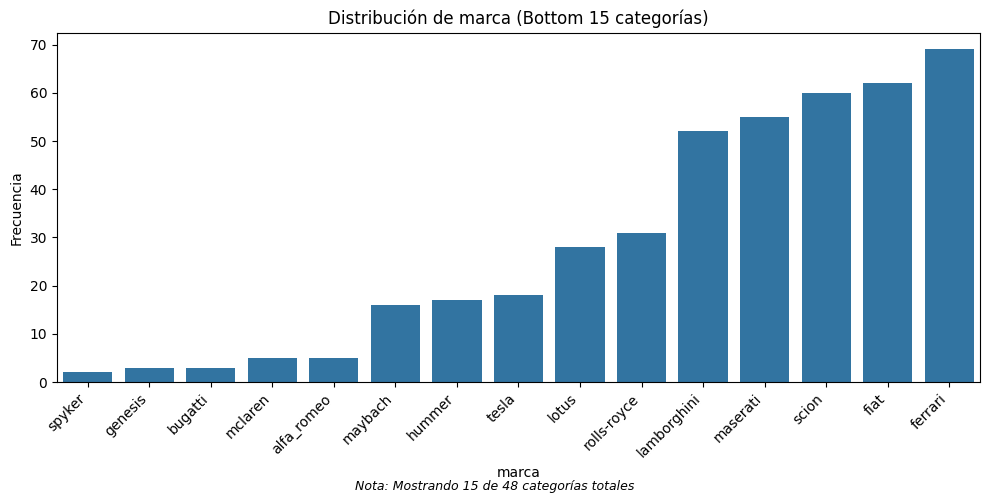

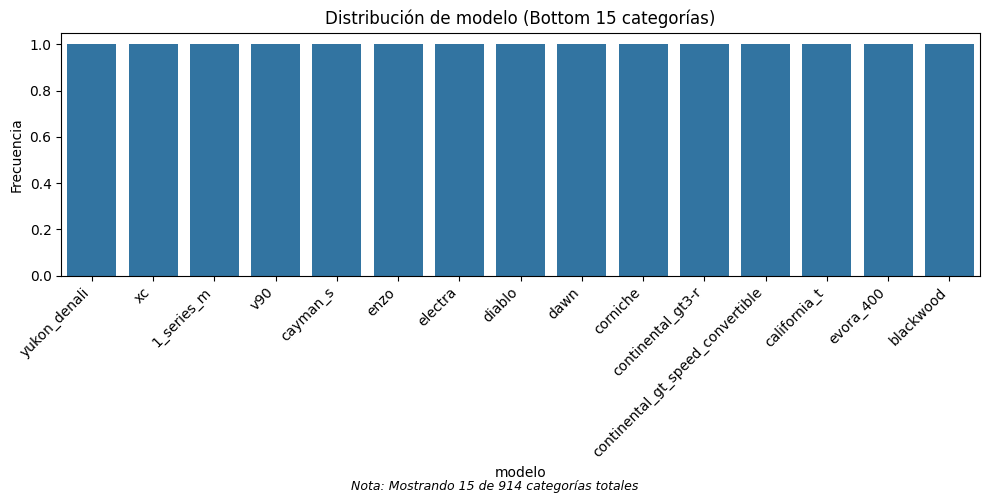

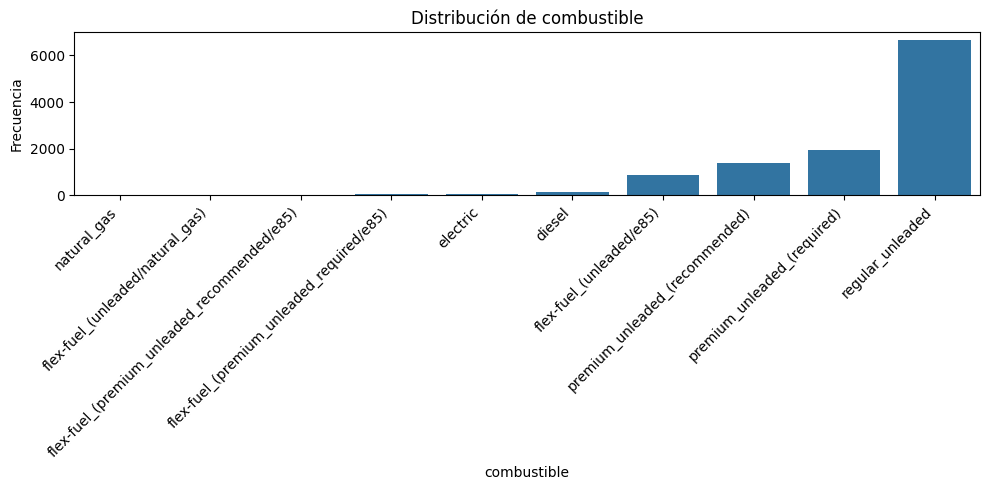

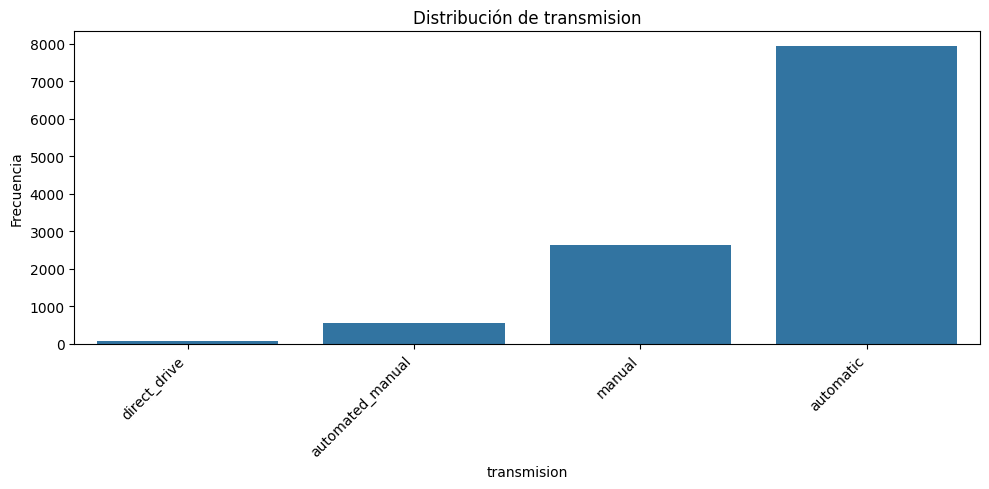

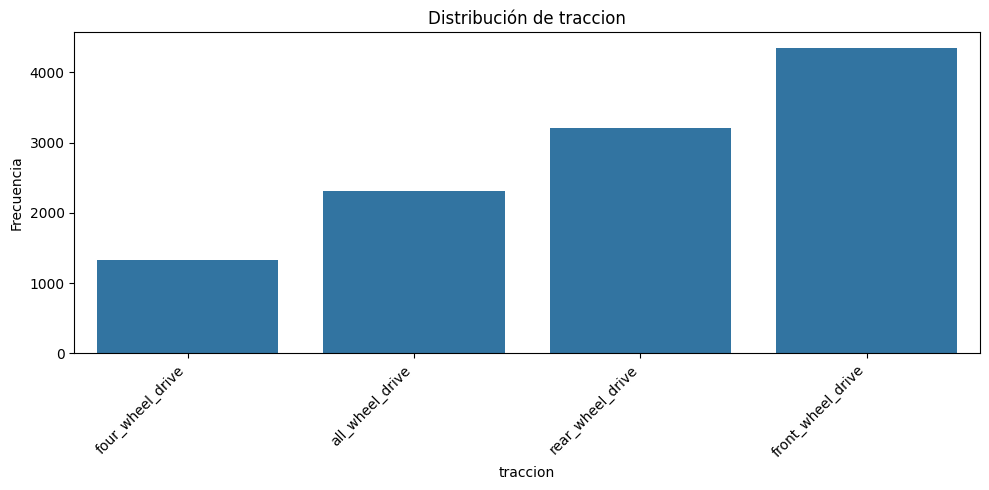

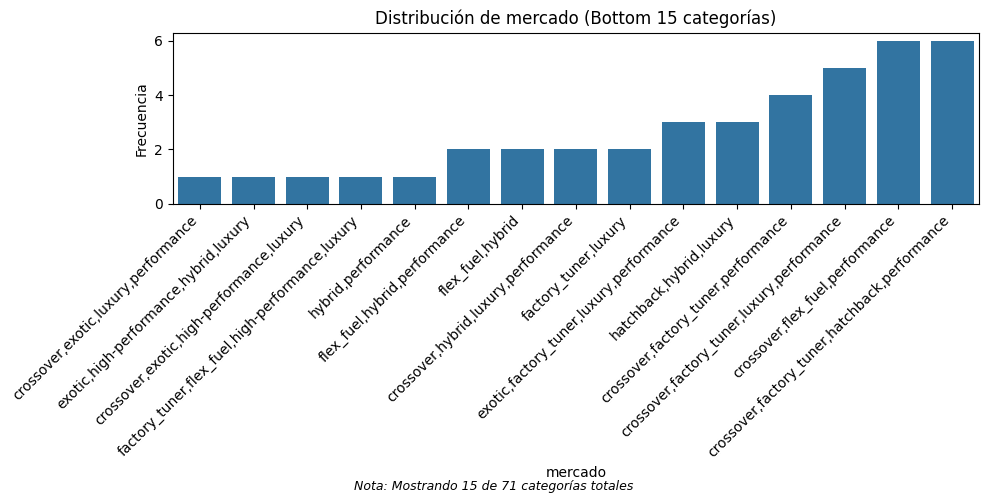

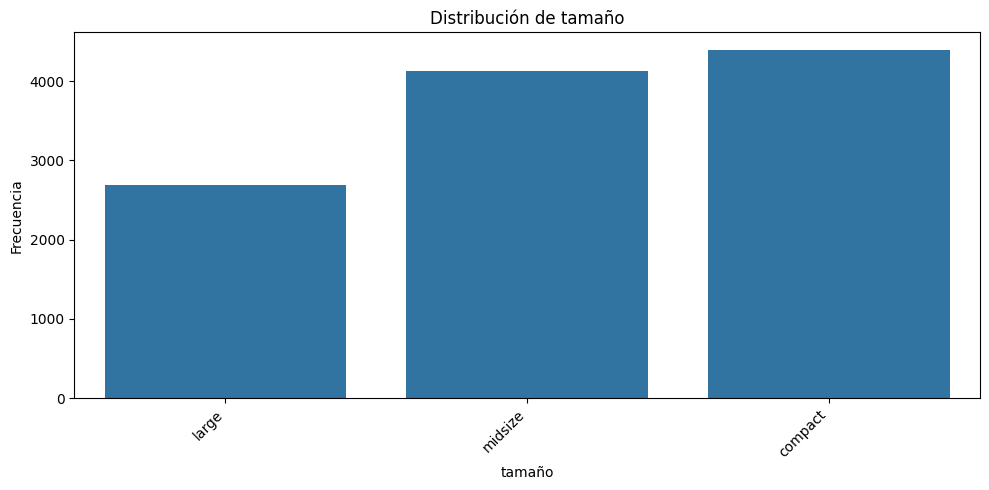

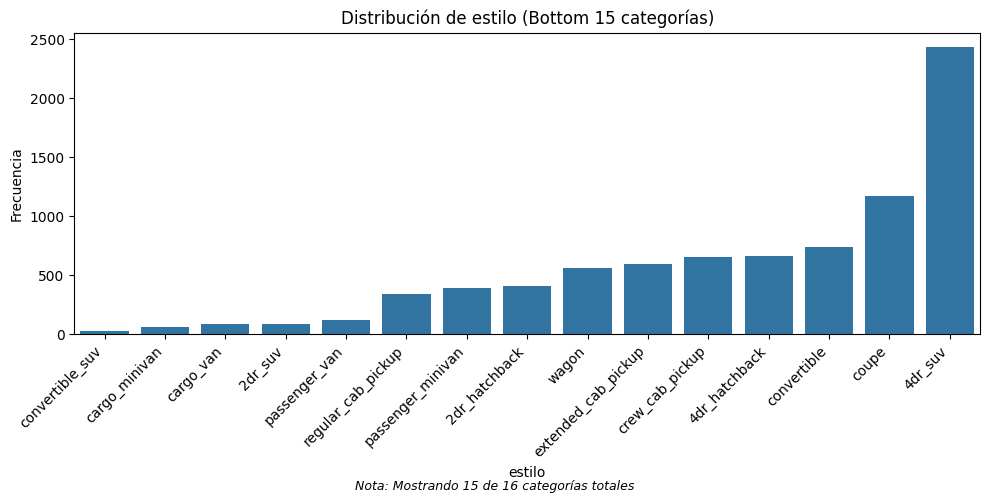

In [28]:
# Diagrama de barras bottom
for var in categorical_variables:
    # Obtener las n categorías menos frecuentes
    n = 15
    bottom_categories = df[var].value_counts().nsmallest(n)
    total_categories = df[var].nunique()
    
    # Crear la figura
    fig, ax = plt.subplots(figsize=(10, 5))

    # Crear el gráfico de barras
    sns.countplot(data=df, x=var, order=bottom_categories.index)

    # Título y etiquetas
    if total_categories > n:
        plt.title(f"Distribución de {var} (Bottom {n} categorías)")
    else:
        plt.title(f"Distribución de {var}")
    plt.xlabel(var)
    plt.ylabel("Frecuencia")

    # Rotar etiquetas
    plt.xticks(rotation=45, ha="right")
    
    # Ajustar el diseño para que no se corten las etiquetas
    plt.tight_layout()
    
    # Añadir nota informativa sobre datos omitidos
    if total_categories > n:
        plt.figtext(0.5, 0.01, 
                   f"Nota: Mostrando {n} de {total_categories} categorías totales", 
                   ha="center", fontsize=9, style='italic')

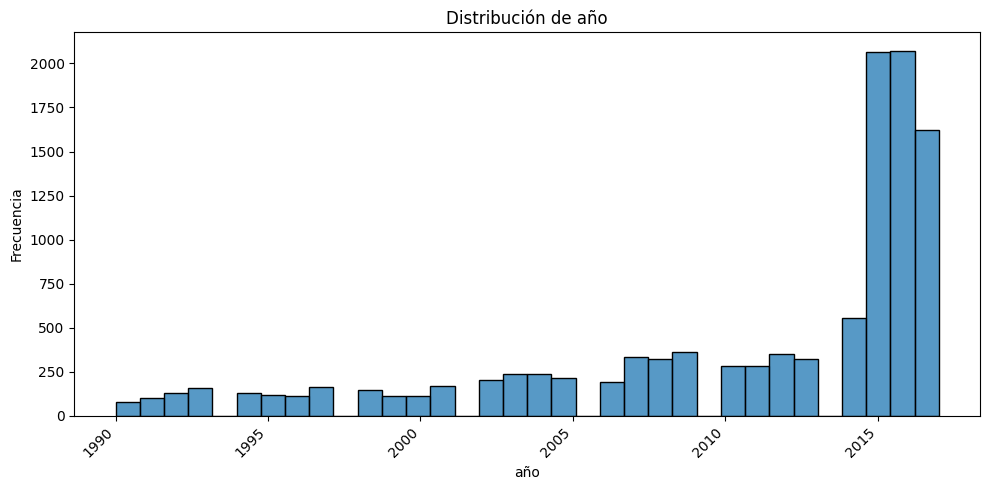

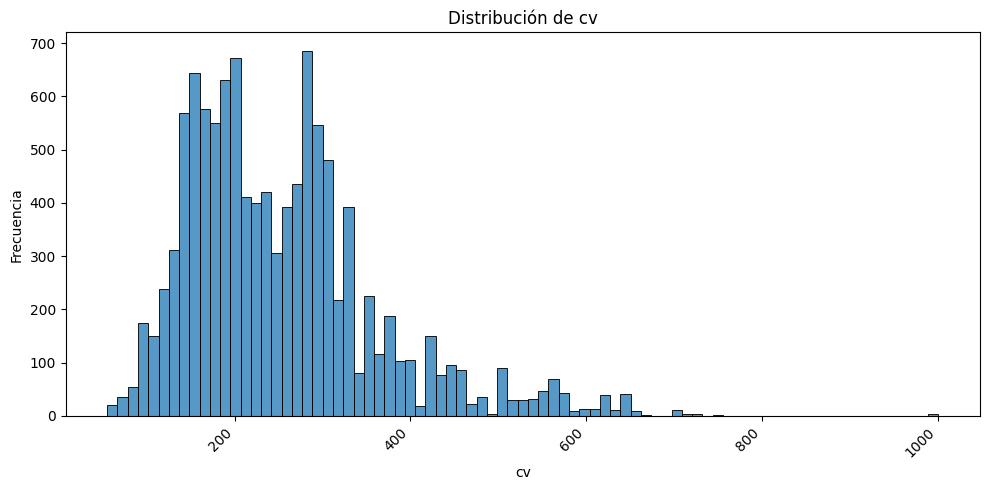

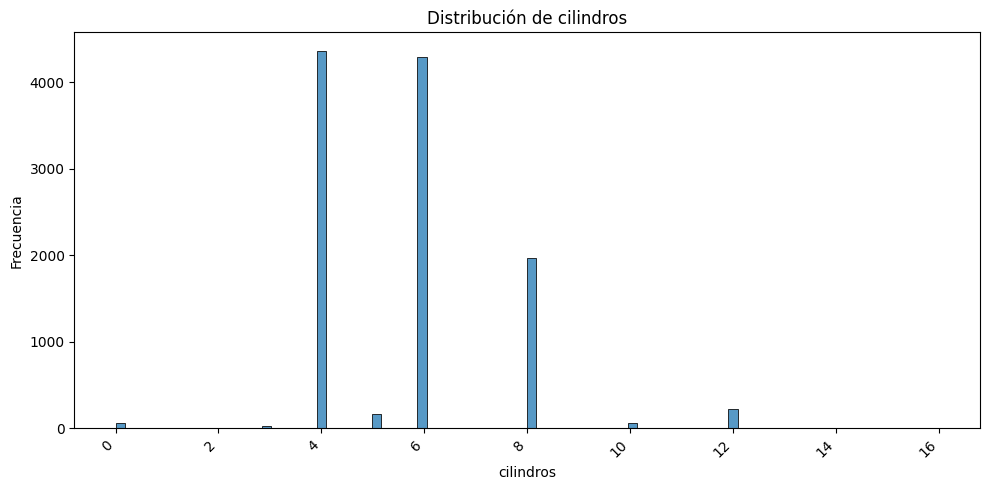

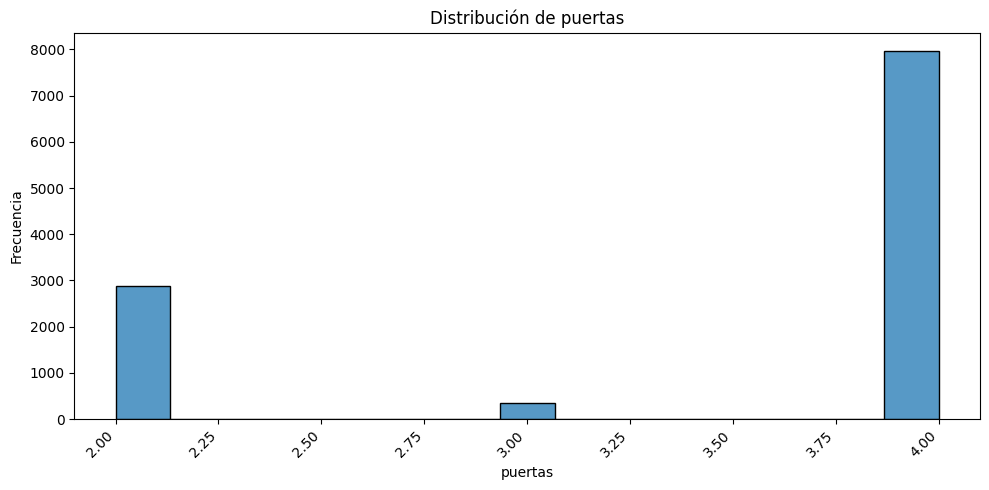

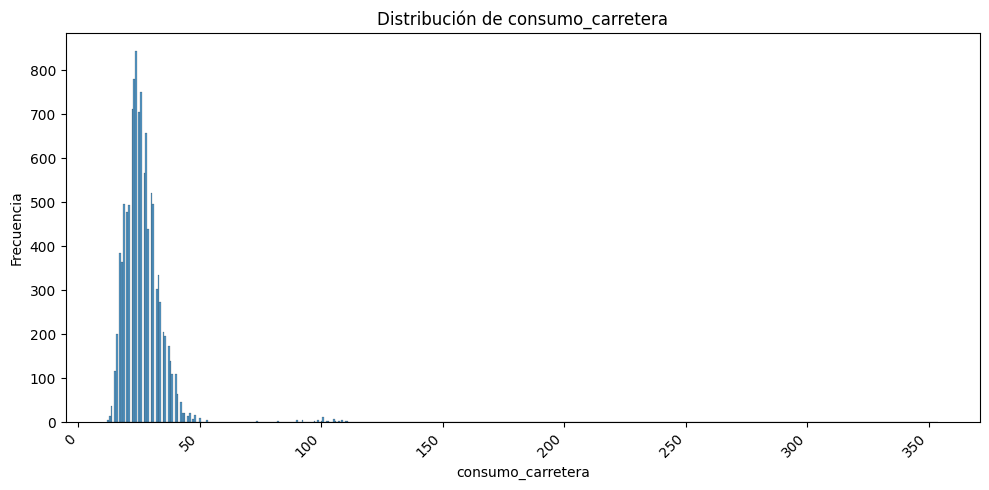

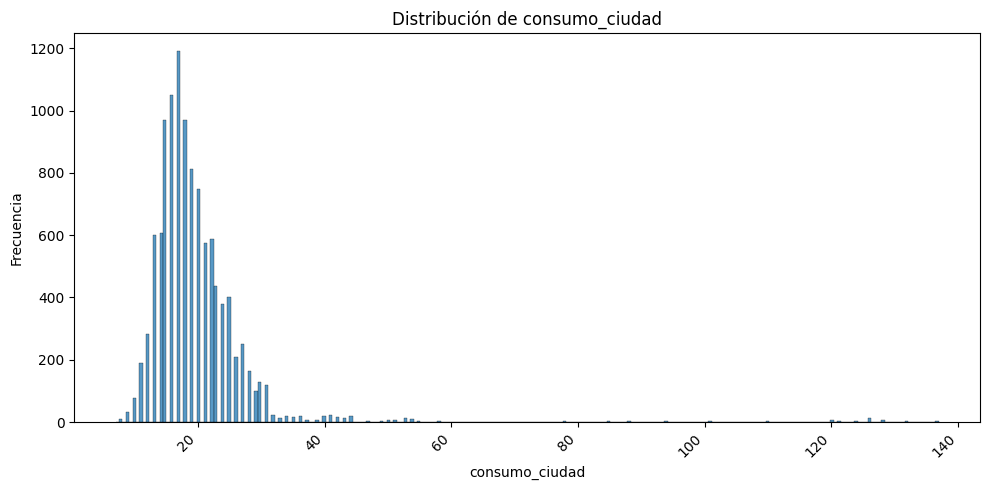

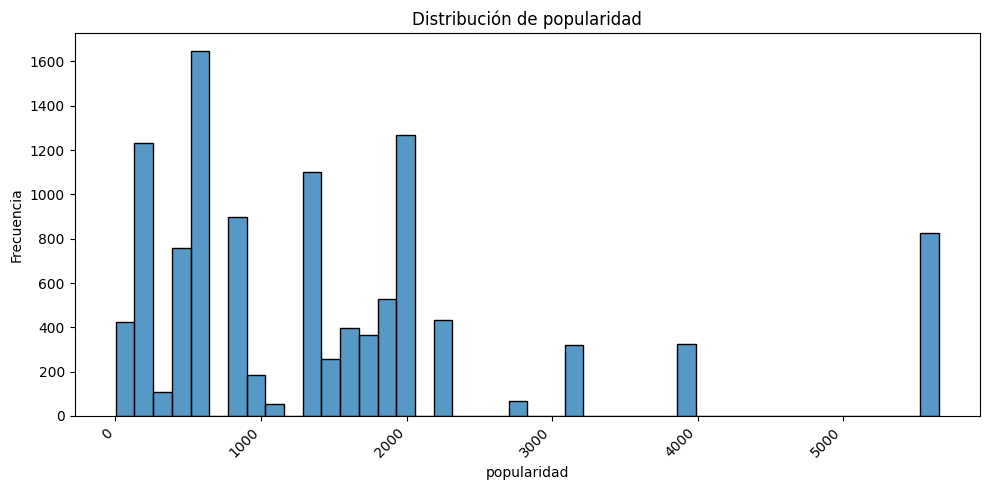

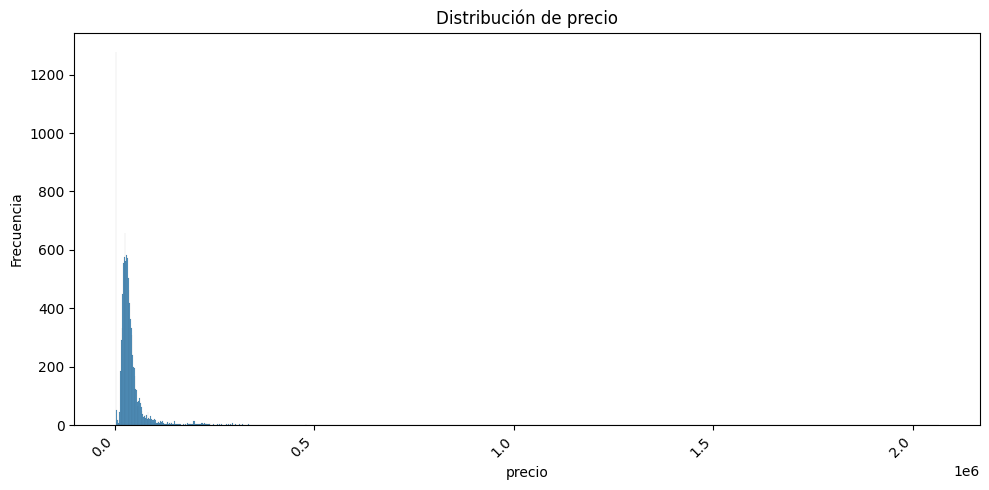

In [29]:
# Histograma
for var in numerical_variables:
    # Crear la figura
    fig, ax = plt.subplots(figsize=(10, 5))

    # Crear el gráfico de barras
    sns.histplot(data=df, x=var, kde=False)

    # Título y etiquetas
    plt.title(f"Distribución de {var}")
    plt.xlabel(var)
    plt.ylabel("Frecuencia")

    # Rotar etiquetas
    plt.xticks(rotation=45, ha="right")
    
    # Ajustar el diseño para que no se corten las etiquetas
    plt.tight_layout()

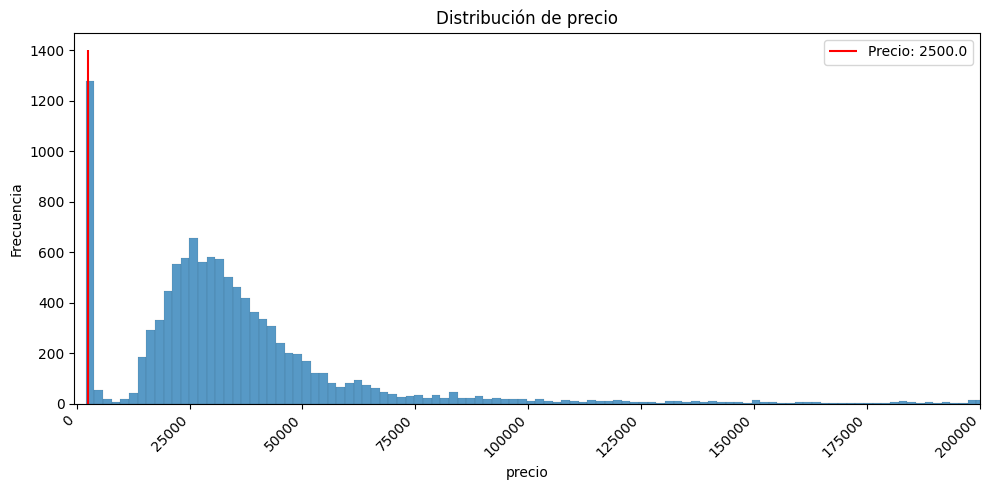

In [30]:
# Histograma para el precio (limitando el eje X)
fig, ax = plt.subplots(figsize=(10, 5))

# Crear el gráfico de barras
sns.histplot(data=df, x=var, kde=False)

# Título y etiquetas
plt.title(f"Distribución de {var}")
plt.xlabel(var)
plt.ylabel("Frecuencia")

# Rotar etiquetas
plt.xticks(rotation=45, ha="right")

# Limitar eje X
plt.xlim([-5e2, 2e5])

# Línea vertical
posi_x = 2.5e3
plt.vlines(x=posi_x, ymin=0, ymax=1.4e3, color="red", linestyle="solid", label=f"Precio: {posi_x}")

# Leyenda
plt.legend()
    
# Ajustar el diseño para que no se corten las etiquetas
plt.tight_layout()

De las distribuciones podemos extraer las siguientes conclusiones:

- <strong>Marca</strong>: Dominan los vehículos de las marcas Chevrolet, Ford y Toyota, con más de 700 registros cada una. En el extremo opuesto, encontramos marcas muy poco representadas como Spyker, Genesis, Bugatti, McLaren y Alfa Romeo, todas con menos de 10 unidades.
- <strong>Modelo</strong>: Los modelos más comunes son Silverado 1500, Tundra, F-150 y Sierra 1500, todos con más de 90 vehículos. Sin embargo, también hay un número elevado de modelos únicos. Esto era esperable dada la alta cardinalidad de la variable (más de 900 modelos en un dataset de ~12.000 registros).
- <strong>Combustible</strong>: Los tipos de combustible más frecuentes son Regular unleaded, Premium unleaded (required), Premium unleaded (recommended) y Flex-Fuel (unleaded/E85). Estas cuatro opciones dominan claramente el conjunto, siendo Regular unleaded la más representada, superando la mitad del total de registros.
- <strong>Transmisión</strong>: Aproximadamente un 75 % de los vehículos tienen transmisión automática, frente a un 20 % manual. El resto se reparte entre opciones menos frecuentes como direct drive o semi-automática.
- <strong>Tracción</strong>: Esta variable presenta una distribución más equilibrada entre sus categorías más comunes (front-wheel, rear-wheel y all-wheel drive), aunque también algo escalonada.
- <strong>Mercado</strong>: Esta variable presenta más valores nulos que la suma de los registros de los tres mercados más representados. Esto requerirá una imputación cuidadosa o, en su defecto, una decisión fundamentada sobre su posible eliminación. Al igual que ocurre con el modelo, la variable tiene una alta cardinalidad (72 categorías), de las cuales muchas cuentan con muy pocos registros.
- <strong>Tamaño</strong>: Es la variable categórica con una distribución más equilibrada. Aun así, el tamaño grande es el menos común.
- <strong>Estilo</strong>: Los estilos Sedan y 4DR SUV suman casi el 50 % del total. A partir de la categoría Convertible, la frecuencia está más distribuida, aunque categorías como Passenger Van son residuales.
- <strong>Año</strong>: La mayoría de los vehículos son del 2015 al 2017.
- <strong>CV (Caballos de Potencia)</strong>: La distribución muestra 2 picos de tendencia, uno en ~180 CV y el otro en ~300 CV.
- <strong>Cilindros</strong>: La mayoría de los vehículos tienen 4 o 6 cilindros, seguido de 8 cilindros. El máximo y el mínimo de cilindros son 16 y 0, respectivamente.
- <strong>Puertas</strong>: La mayoría de los vehículos poseen 4 puertas, seguido en menor medida de 2 y los de 3 puertas son minoritarios.
- <strong>Consumo Carretera</strong> y  <strong>Consumo Ciudad</strong>: Ambas distribuciones poseen valores muy concentrados entorno a 20-25 L/100km, existiendo, sin embargo, valores máximos residuales que cuadruplican (o más) esta tasa. Es decir, son distribuciones sesgadas hacia la derecha (asimétricas postivas), probablemente distribuciones log-normal.
- <strong>Popularidad</strong>: No sigue una distribución estándar. Encontramos puntuaciones dispersas y arbitrarias a lo largo de todo el espectro.
- <strong>Precio</strong>: Encontramos, de forma similar a los consumos, una distribución asimétrica positiva donde la mayoría de los precios se aglutinan entorno a 25000 y, además, encontramos una larga cola asimétrica con precios muy altos. Por otro lado, también descata notablemente el pico de vehículos con un precio entorno a los 2500.
  
Estas representaciones reflejan tres retos clave a resolver antes del modelado:

1) Alta proporción de **valores nulos**, especialmente en la variable Mercado.
2) Elevada **cardinalidad** de algunas variables categóricas (como modelo o mercado), lo que genera una explosión de variables si se usa *one-hot encoding*.
3) Presencia significativa de ***outliers*** en variables como precio, caballos de potencia o los consumos, que pueden sesgar modelos sensibles.

Dadas estas problemáticas, los siguientes modelos de regresión tienen altas posibilidades de ser descartados:
- Regresión lineal: Aunque interpretable, es poco robusta frente a *outliers* y difícilmente captura relaciones complejas entre múltiples categorías.
- K-vecinos (KNN): Su rendimiento se ve degradado en espacios de alta dimensionalidad, no escala bien con un gran número de variables categóricas codificadas, ni cuando los datos están repartidos de forma poco homogénea en el espacio de variables.
- Máquinas de Soporte Vectorial (SVM): Aunque útiles en algunos contextos con datos dispersos, no son la mejor opción en problemas con alta cardinalidad y son sensibles a *outliers*. Además, suelen requerir un ajuste más fino.
- Redes Neuronales (NN): Potentes porque ofrecen un amplio paquete de personalización (funciones de activación, regularización, etc.), pero sensibles a *outliers* y costosas de entrenar cuando se aplica one-hot encoding sobre variables de alta cardinalidad, lo que puede generar una matriz de entrada excesivamente grande y dispersa.

Por otro lado, los siguientes modelos son especialmente adecuados:

- <strong>Árboles de Decisión</strong>, **Algoritmos de Bagging (Random Forest)** y **Boosting (XGBoost)**: Se presentan como las opciones más robustas.
    - No requieren escalado ni estandarización.
    - Son tolerantes a *outliers*.
    - Manejan de forma eficiente múltiples variables y relaciones no lineales.
    - Se adaptan bien a variables categóricas.

Dadas las características del dataset, los modelos basados en ensembles como Random Forest y XGBoost ofrecen un equilibrio ideal entre rendimiento, robustez y capacidad de interpretar relaciones complejas sin requerir un preprocesamiento excesivo. La elección de modelo, no obstante, deberá validarse empíricamente con las métricas adecuadas tras la preparación completa de los datos.

#### 4.1.2 Bivariante

Continuando con el análisis, nos disponemos a encontrar las variables que mejor se correlacionan con la variable *target* (Precio).

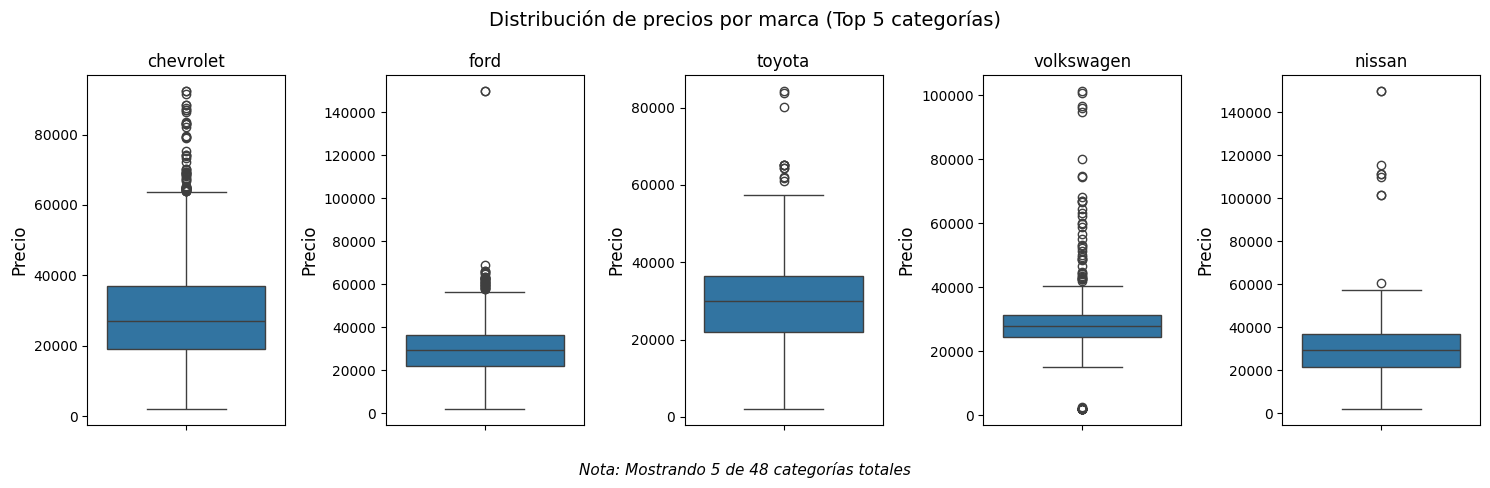

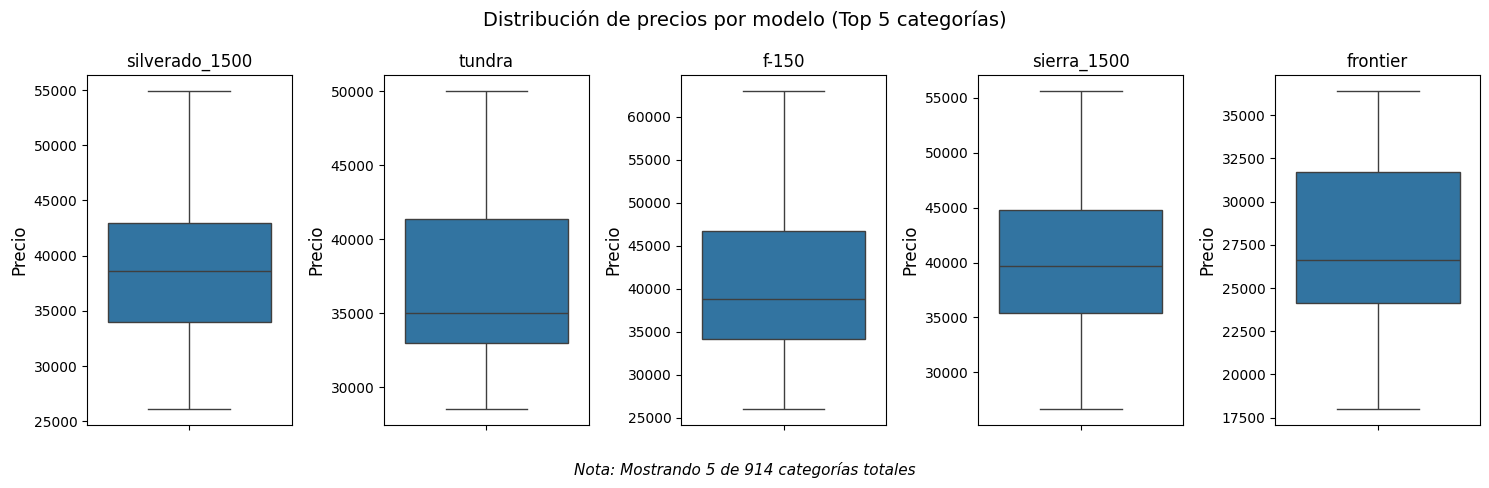

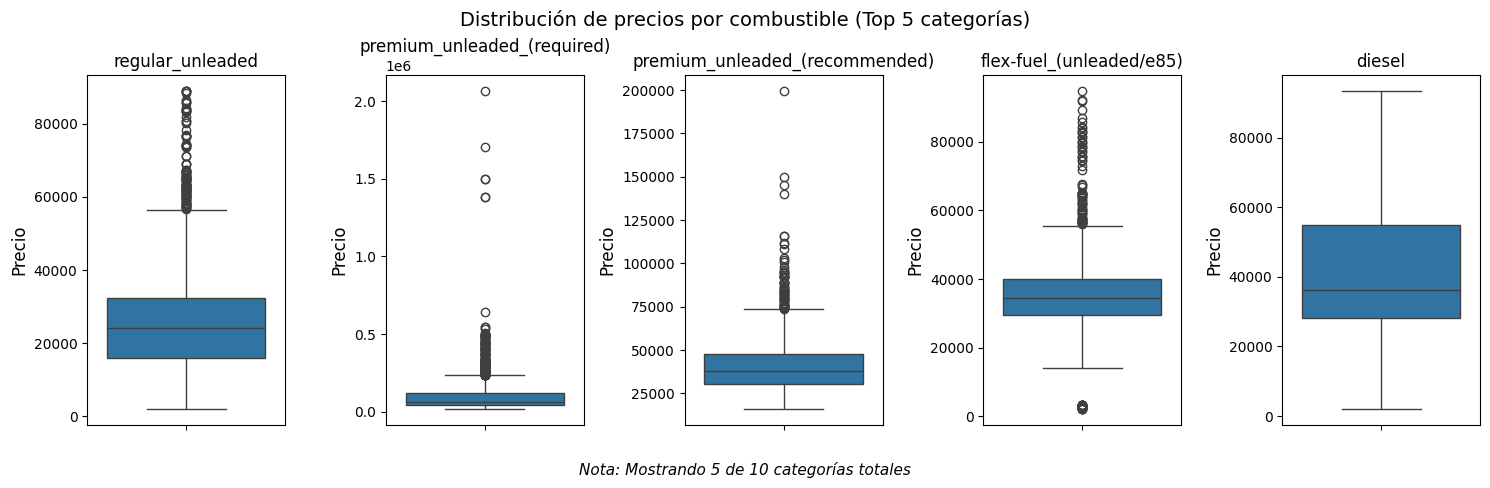

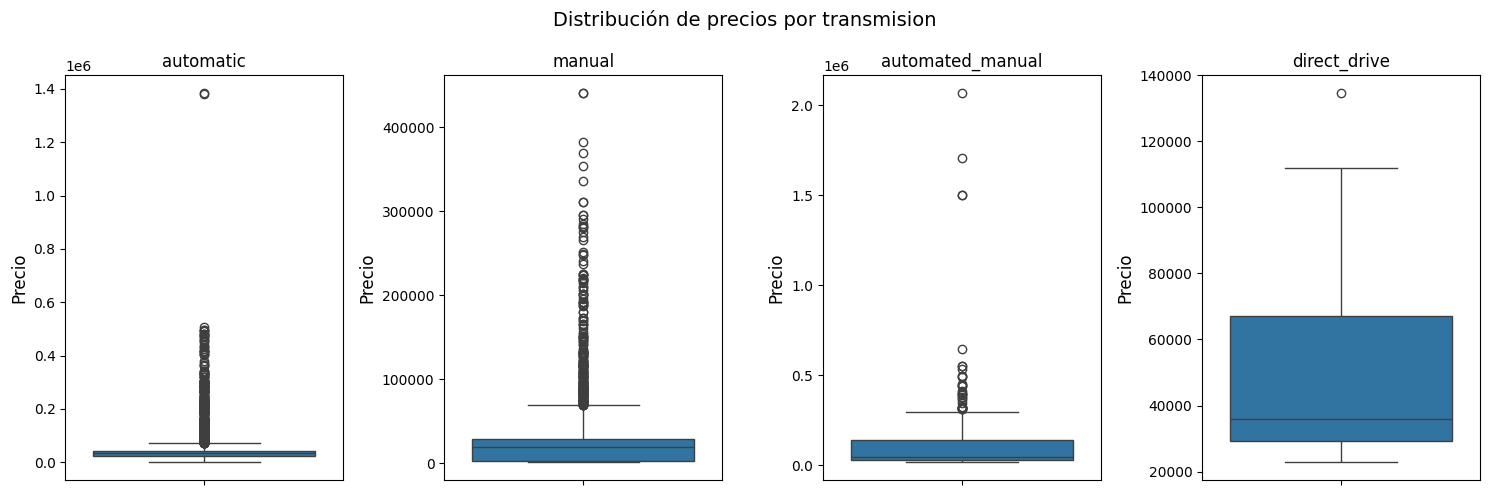

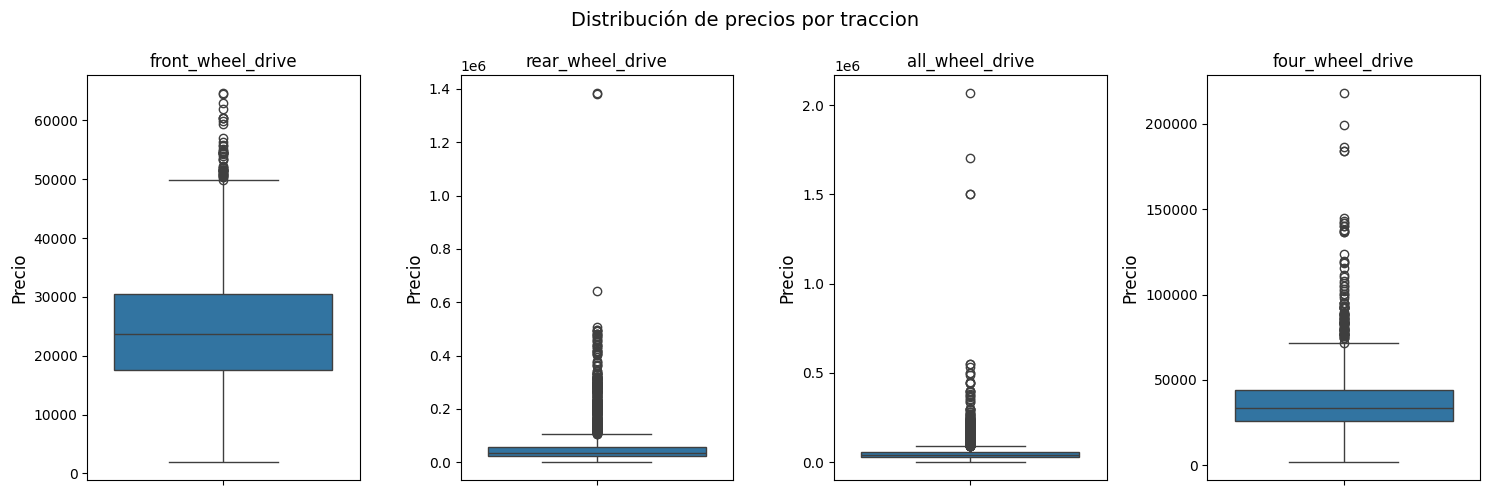

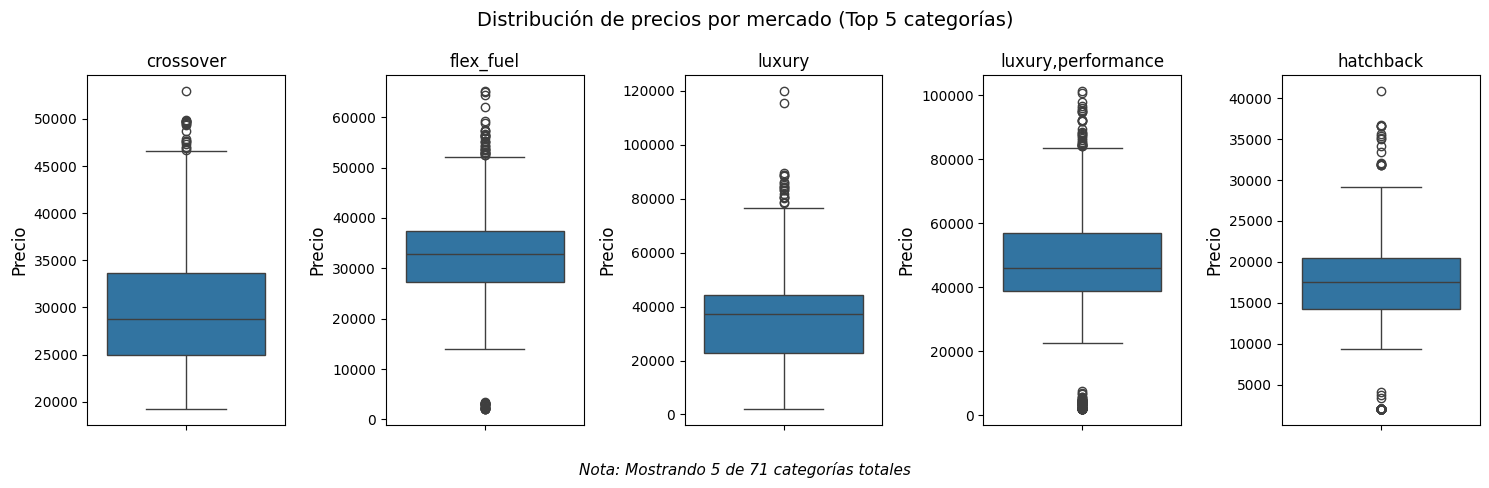

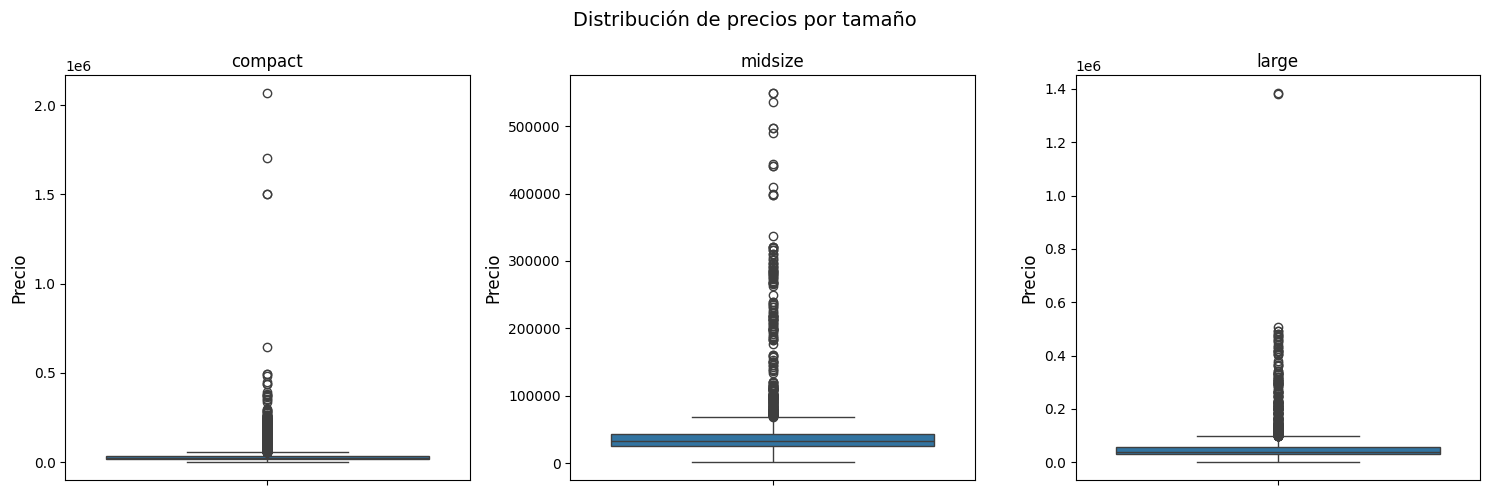

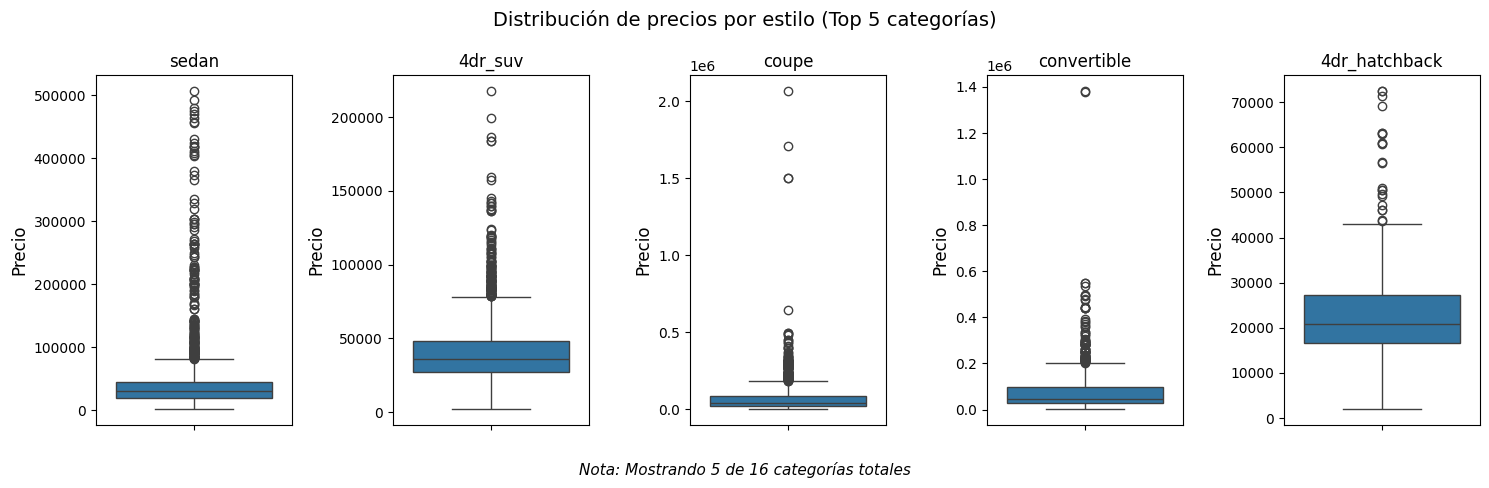

In [31]:
# Generar boxplots: var - Precio (Top n)
for var in categorical_variables:
    # Limitar top n categorías
    n = 5
    top_categories = df[var].value_counts().nlargest(n)
    total_categories = df[var].nunique()

    # Crear figura y gráfico
    fig, axes = plt.subplots(1, len(top_categories), figsize=(15, 5))
    
    for i, ax in enumerate(axes):
        # Filtrar cada categoría de cada variable
        df_filtered = df[df[var] == top_categories.index[i]]
        sns.boxplot(data=df_filtered, y="precio", ax=ax)
        
        # Configurar el título del subplot con el nombre de la categoría
        ax.set_title(f"{top_categories.index[i]}")
        
        # Eliminar etiqueta del eje X ya que solo tenemos una categoría por subplot
        ax.set_xlabel("")

        # Título eje Y
        ax.set_ylabel("Precio", fontsize=12)
    
    # Añadir un título general
    if total_categories > n:
        plt.suptitle(f"Distribución de precios por {var} (Top {n} categorías)", fontsize=14)
        #plt.suptitle(f"La distribución de Precios depende del Mercado (Top {n} categorías)", fontsize=17) # Sólo para el powerpoint
    else:
        plt.suptitle(f"Distribución de precios por {var}", fontsize=14)
    
    # Ajustar espaciado
    plt.tight_layout() # Optimiza espacio entre gráficos

    # Ajustar manualmente los márgenes
    if total_categories > n:
        # Más espacio en la parte inferior para la nota
        plt.subplots_adjust(top=0.85, bottom=0.15)
        
        # Añadir nota informativa sobre datos omitidos con más espacio
        plt.figtext(0.5, 0.05, 
                   f"Nota: Mostrando {n} de {total_categories} categorías totales", 
                   ha="center", fontsize=11, style='italic')
    else:
        # Sin nota, solo ajustar el título superior
        plt.subplots_adjust(top=0.85)

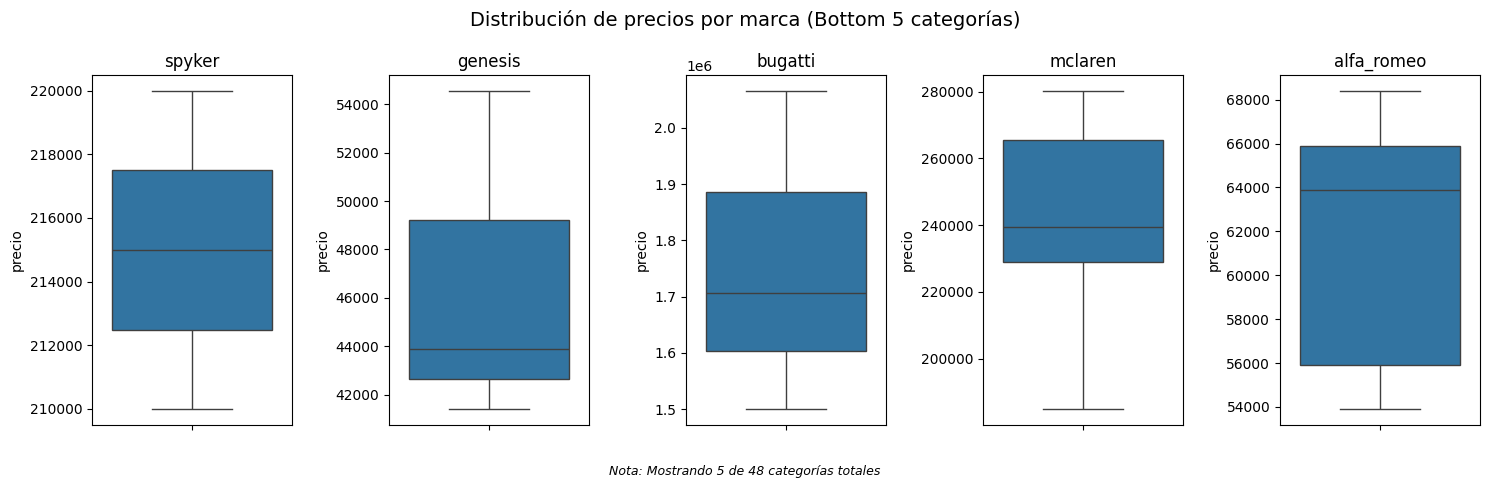

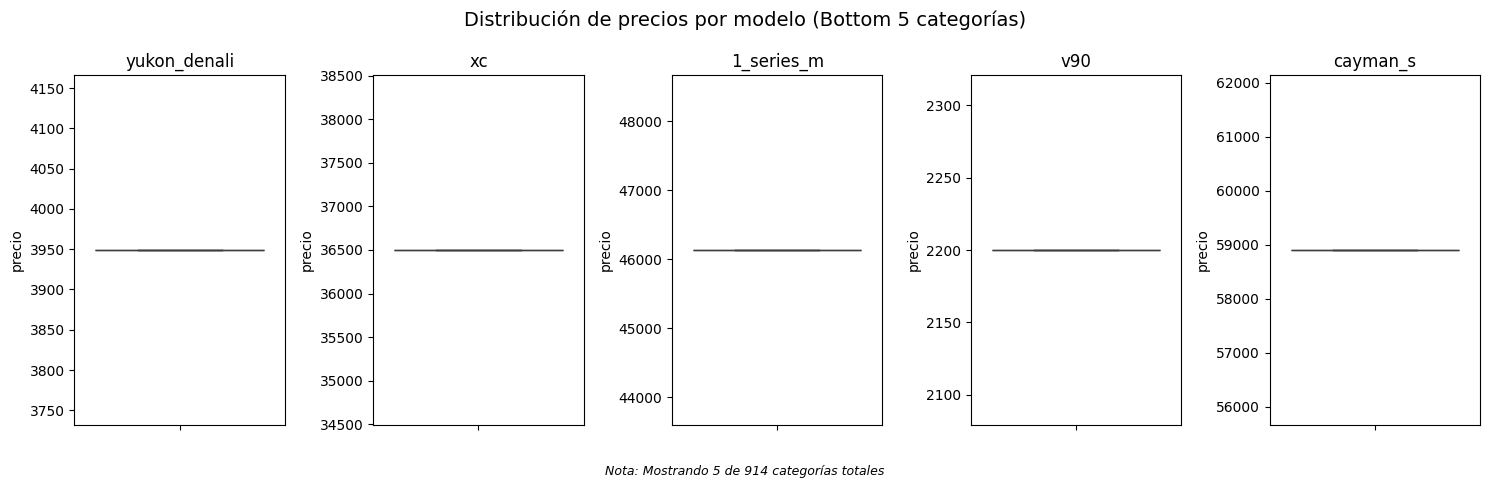

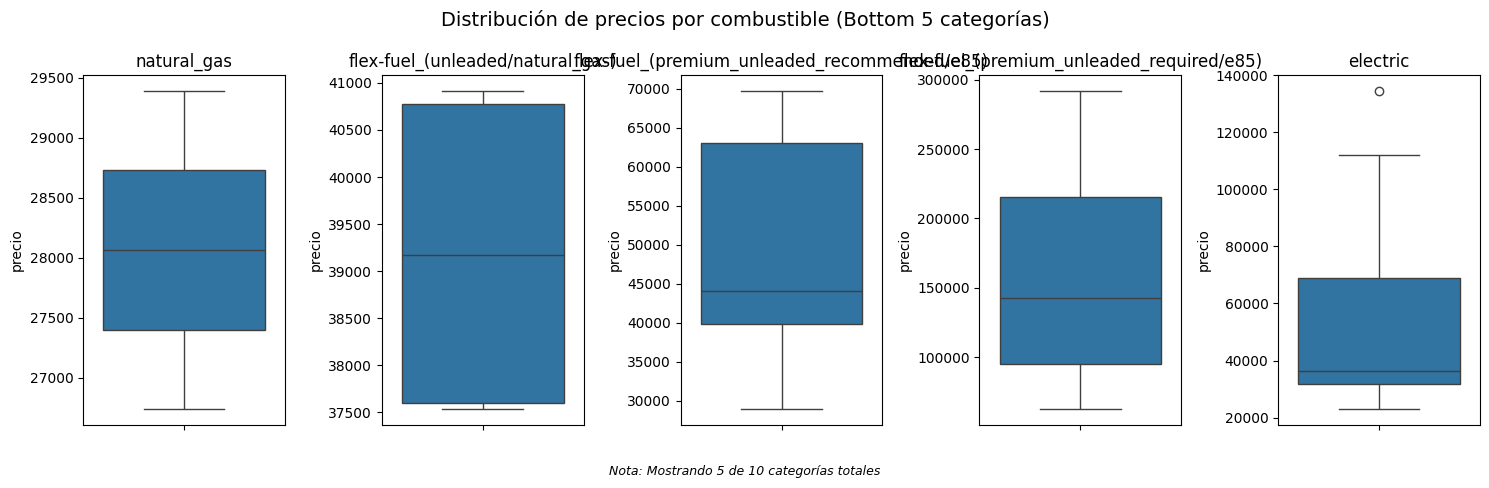

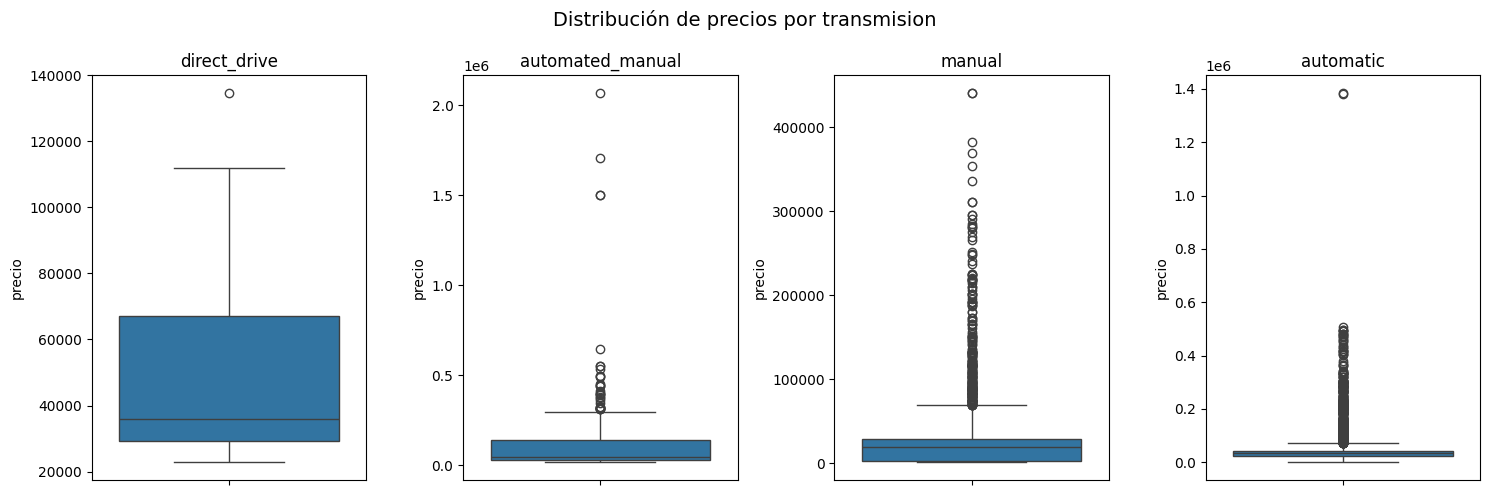

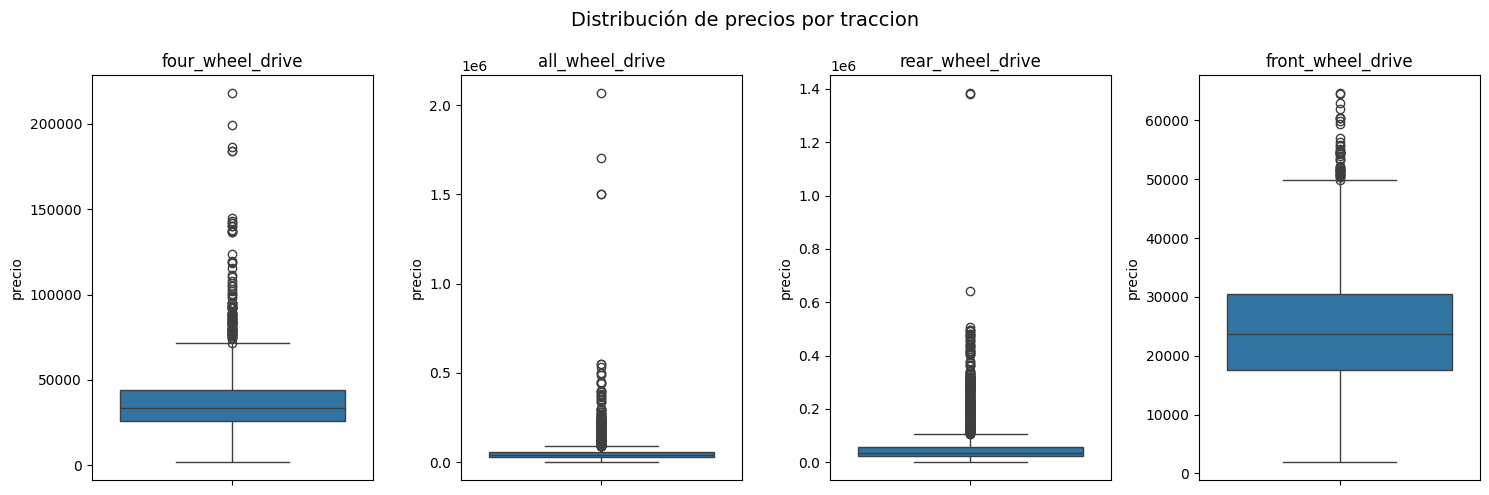

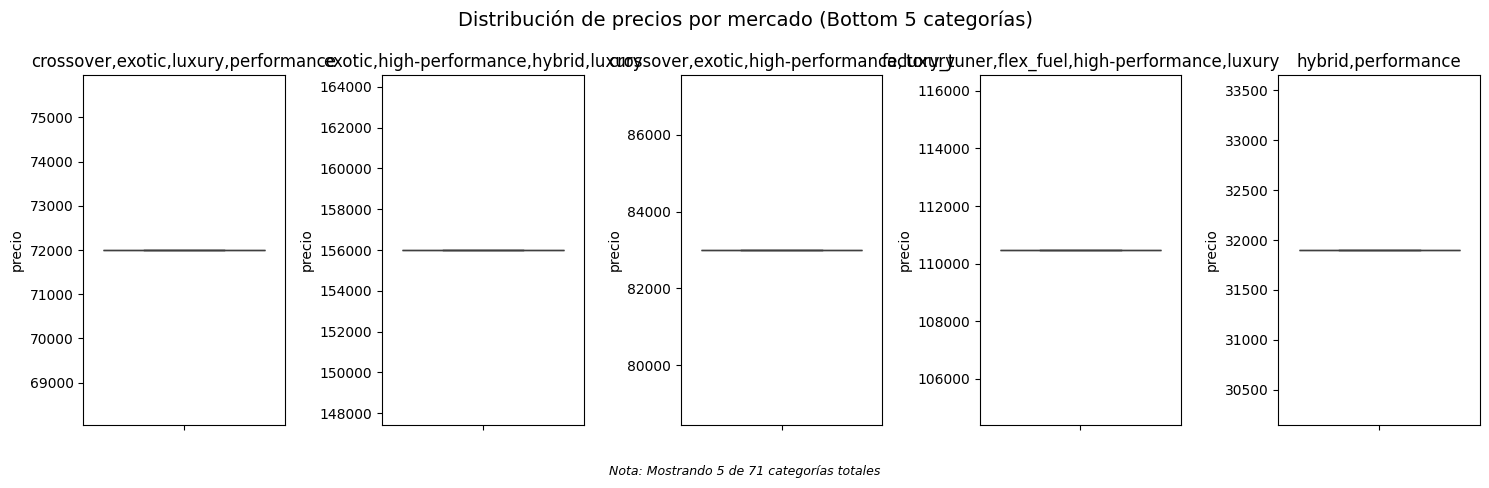

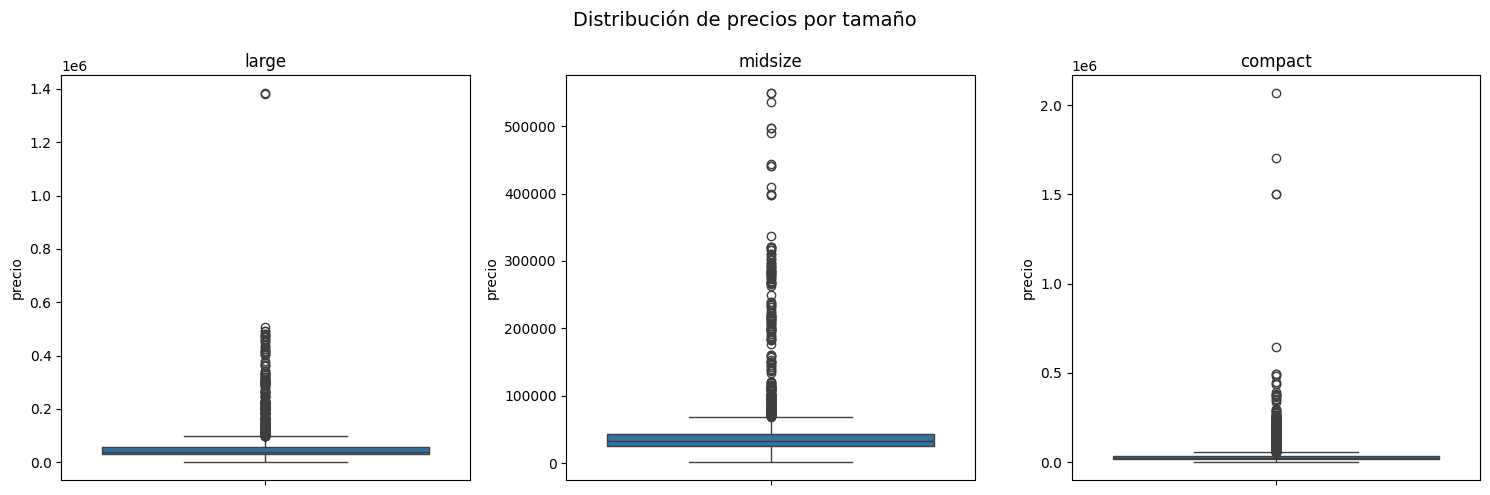

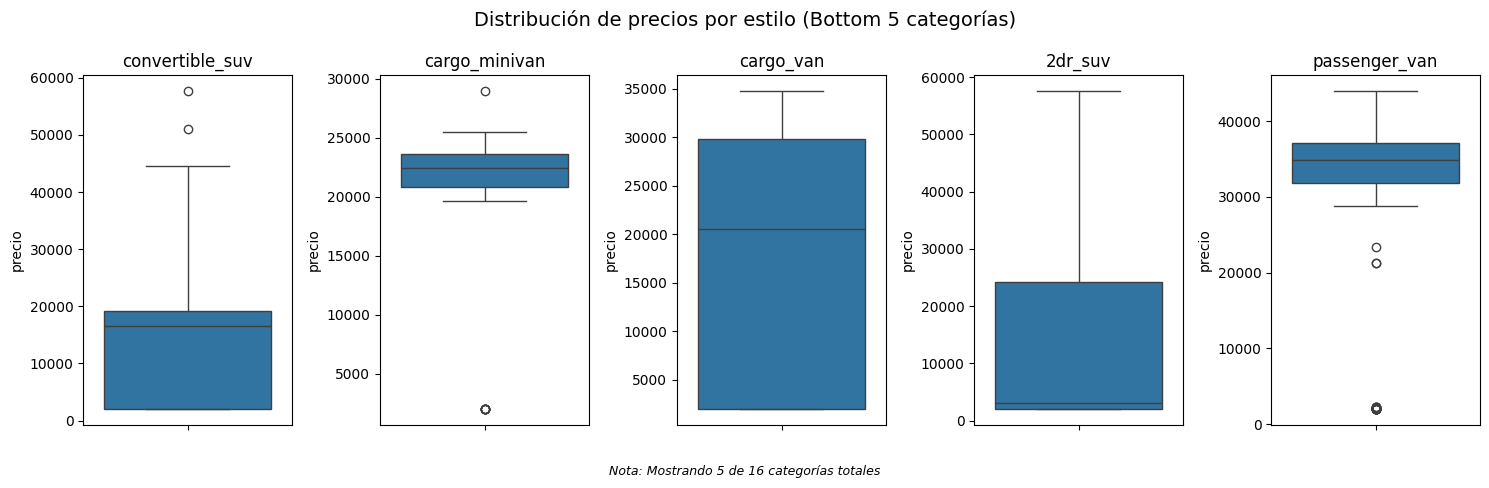

In [32]:
# Generar boxplots: var - Precio (Bottom n)
for var in categorical_variables:
    # Limitar bottom n categorías
    n = 5
    bottom_categories = df[var].value_counts().nsmallest(n)
    total_categories = df[var].nunique()

    # Crear figura y gráfico
    fig, axes = plt.subplots(1, len(bottom_categories), figsize=(15, 5))
    
    for i, ax in enumerate(axes):
        # Filtrar cada categoría de cada variable
        df_filtered = df[df[var] == bottom_categories.index[i]]
        sns.boxplot(data=df_filtered, y="precio", ax=ax)
        
        # Configurar el título del subplot con el nombre de la categoría
        ax.set_title(f"{bottom_categories.index[i]}")
        
        # Eliminar etiqueta del eje X ya que solo tenemos una categoría por subplot
        ax.set_xlabel("")
    
    # Añadir un título general
    if total_categories > n:
        plt.suptitle(f"Distribución de precios por {var} (Bottom {n} categorías)", fontsize=14)
    else:
        plt.suptitle(f"Distribución de precios por {var}", fontsize=14)
    
    # Ajustar espaciado
    plt.tight_layout() # Optimiza espacio entre gráficos

    # Ajustar manualmente los márgenes
    if total_categories > n:
        # Más espacio en la parte inferior para la nota
        plt.subplots_adjust(top=0.85, bottom=0.15)
        
        # Añadir nota informativa sobre datos omitidos con más espacio
        plt.figtext(0.5, 0.05, 
                   f"Nota: Mostrando {n} de {total_categories} categorías totales", 
                   ha="center", fontsize=9, style='italic')
    else:
        # Sin nota, solo ajustar el título superior
        plt.subplots_adjust(top=0.85)

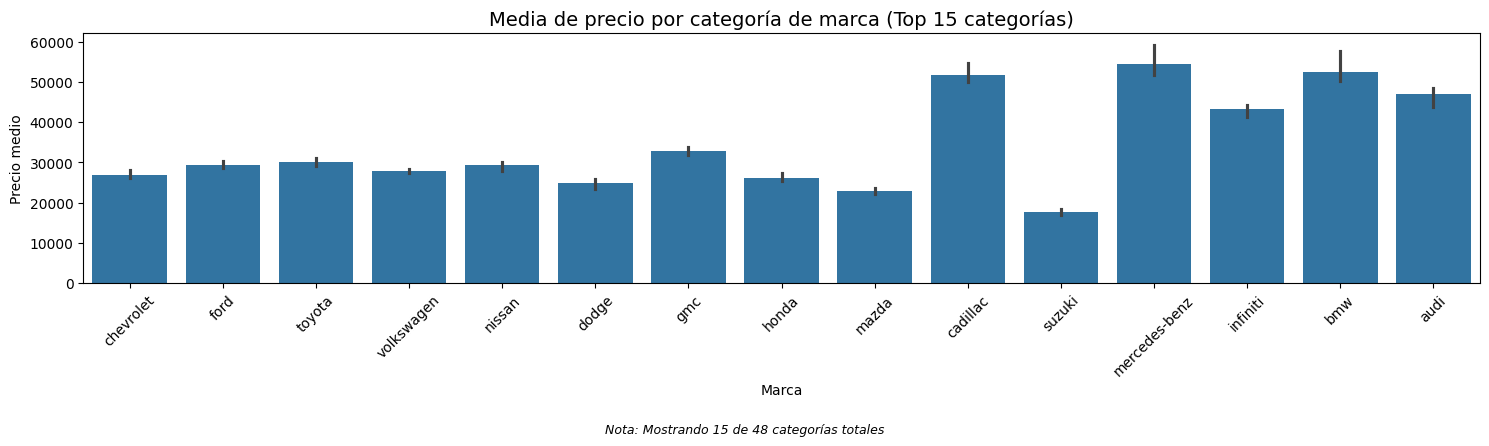

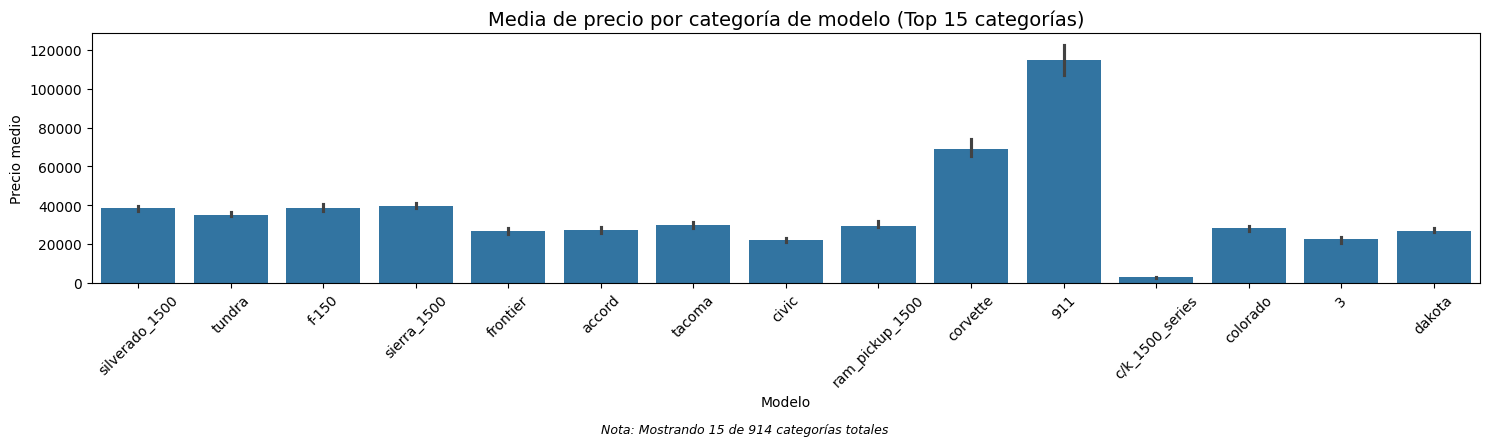

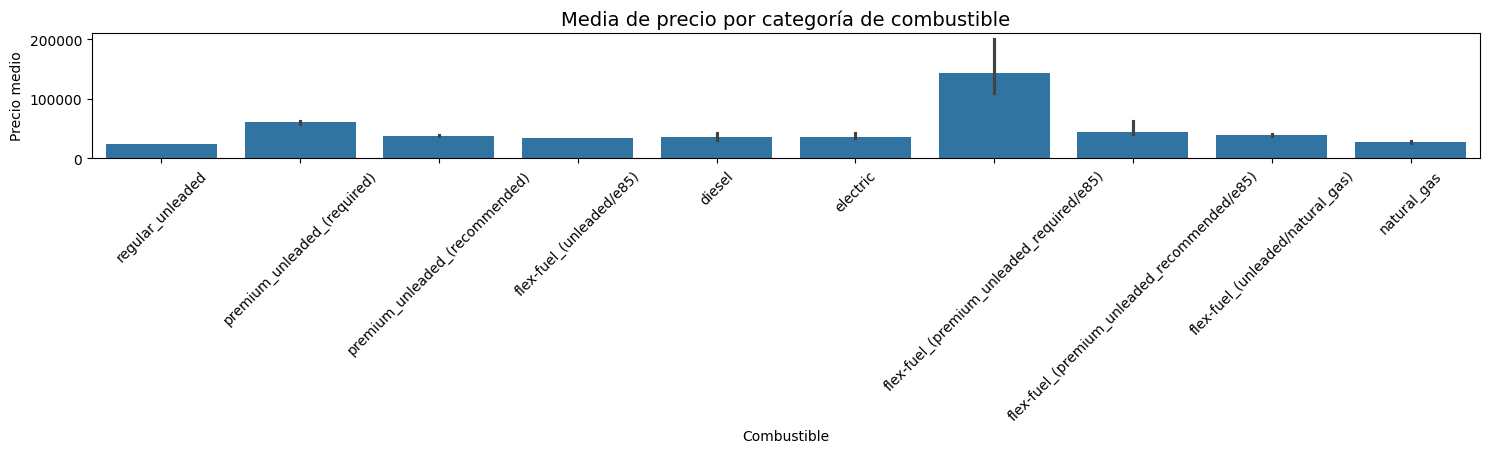

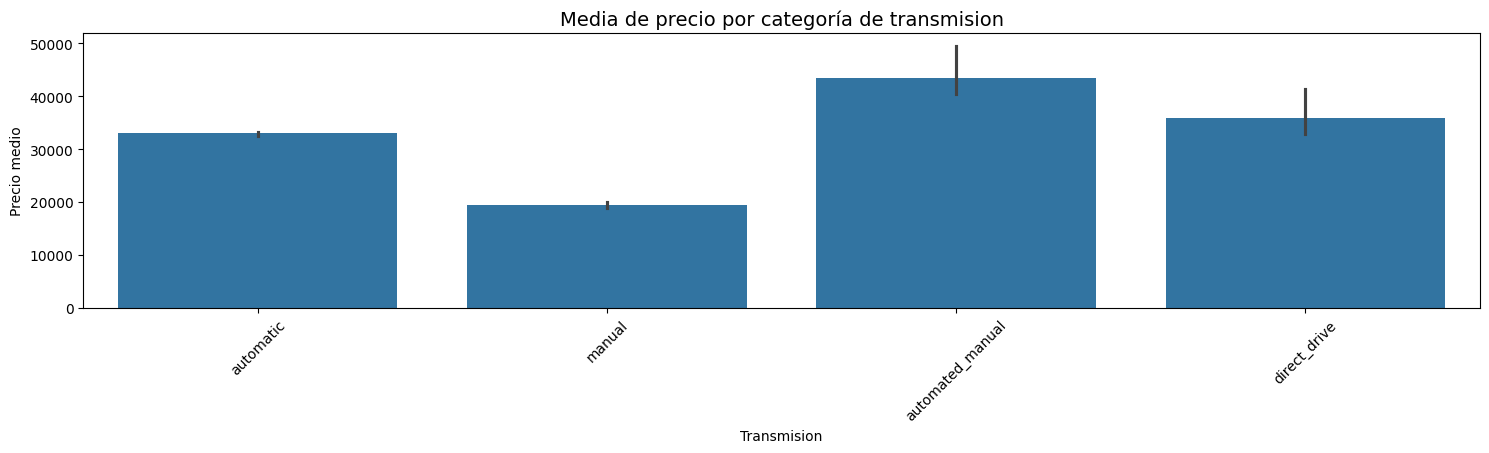

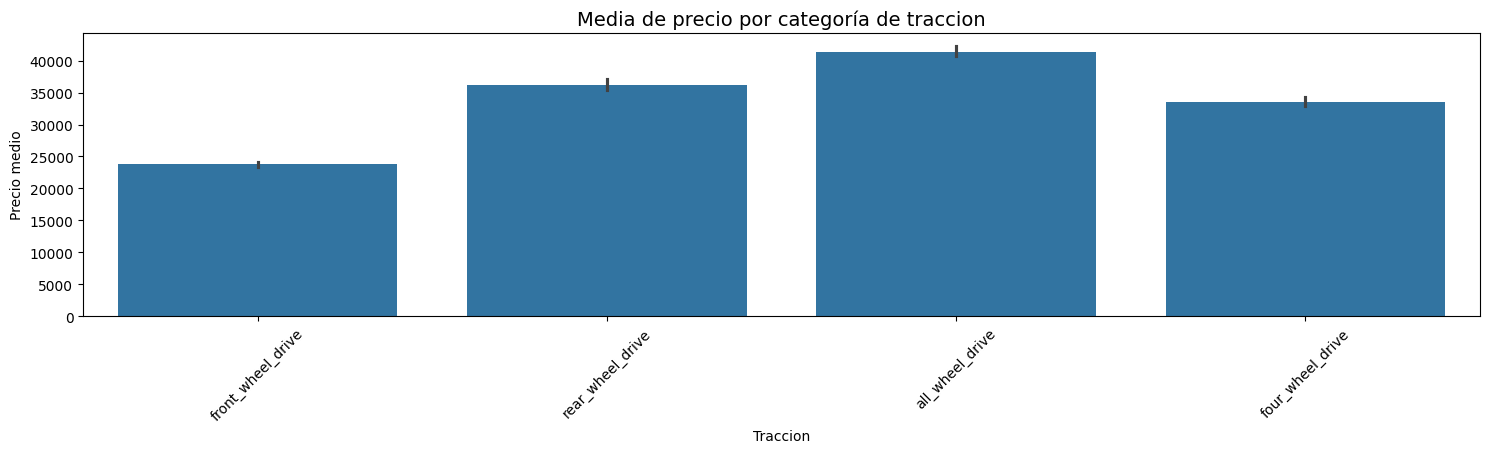

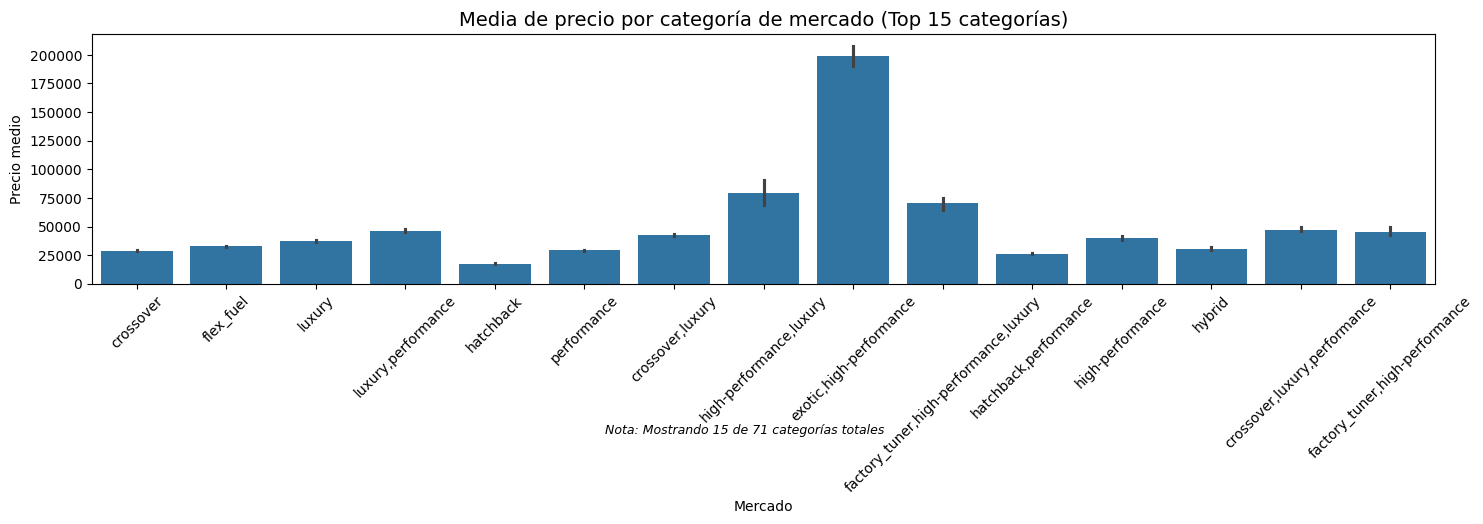

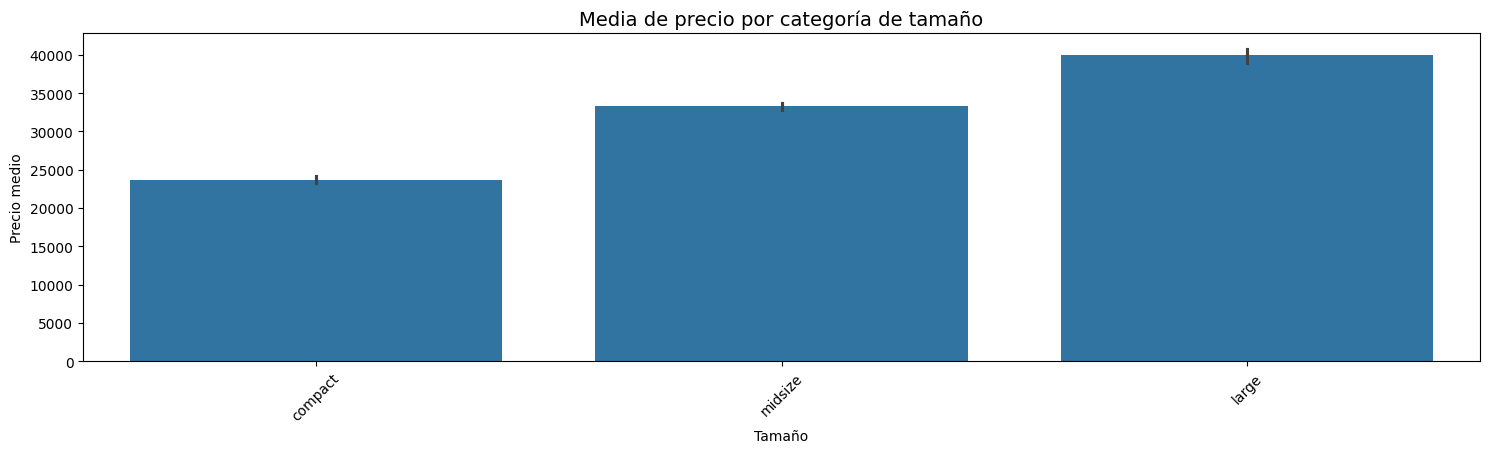

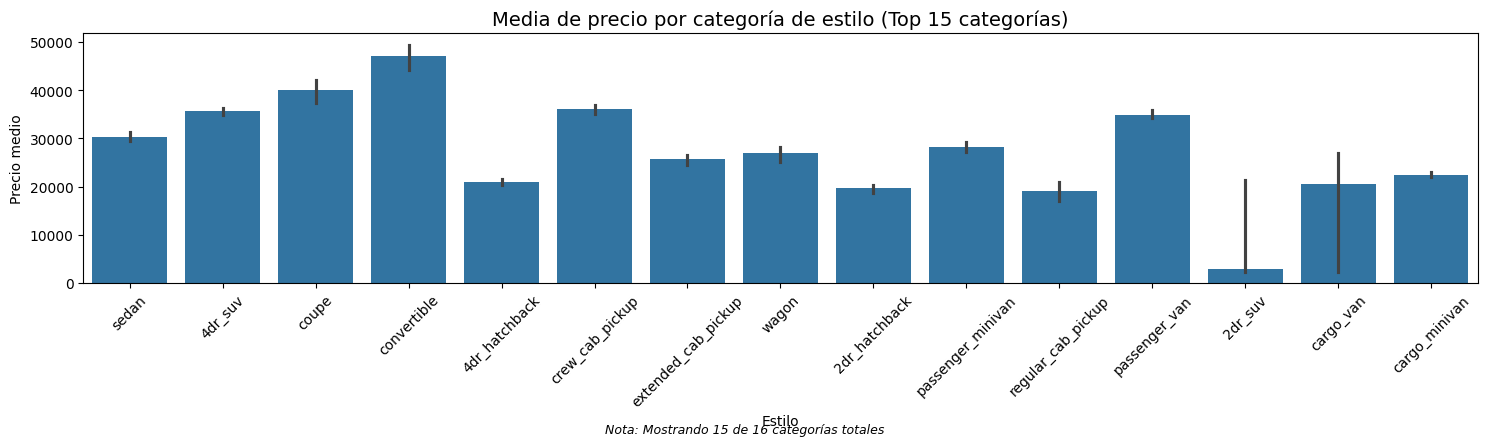

In [33]:
# Diagrama de barras: Categorías vs Precio
for var in categorical_variables:
    # Limitar a Top n categorías
    n = 15
    top_categories = df[var].value_counts().nlargest(n)
    total_categories = df[var].nunique()
    
    # Filtrar el dataframe para incluir solo estas categorías
    df_filtered = df[df[var].isin(top_categories.index)]
    
    # Crear la figura con tamaño personalizado
    plt.figure(figsize=(15, 5))
    
    # Generar el gráfico de barras usando la mediana como estimador
    sns.barplot(data=df_filtered, x=var, y="precio", estimator=np.median, order=top_categories.index)
  
    # Añadir título y formato a los ejes
    if total_categories > n:
        plt.title(f"Media de precio por categoría de {var} (Top {n} categorías)", fontsize=14)
    else:
        plt.title(f"Media de precio por categoría de {var}", fontsize=14)
        
    plt.xticks(rotation=45)
    plt.ylabel("Precio medio")
    plt.xlabel(var.capitalize())
    
    # Ajustar el diseño para que no se corten las etiquetas
    plt.tight_layout()

    # Ajustar manualmente los márgenes
    if total_categories > n:
        # Más espacio en la parte inferior para la nota
        plt.subplots_adjust(top=0.85, bottom=0.35)
        
        # Añadir nota informativa sobre datos omitidos con más espacio
        plt.figtext(0.5, 0.05, 
                   f"Nota: Mostrando {n} de {total_categories} categorías totales", 
                   ha="center", fontsize=9, style='italic')
    else:
        # Sin nota, solo ajustar el título superior
        plt.subplots_adjust(top=0.85)

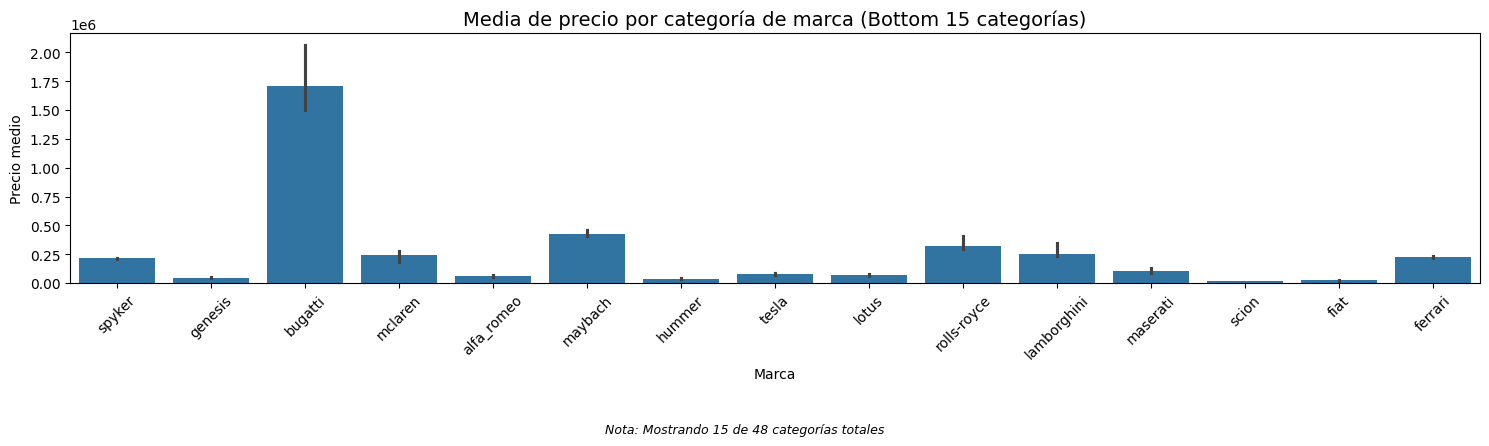

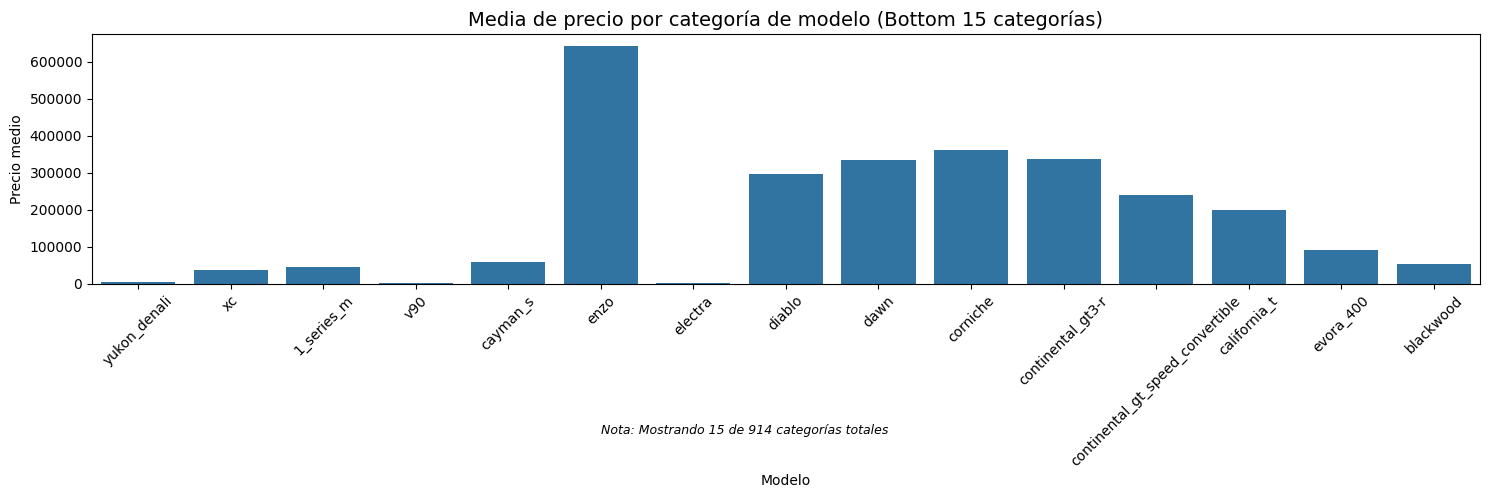

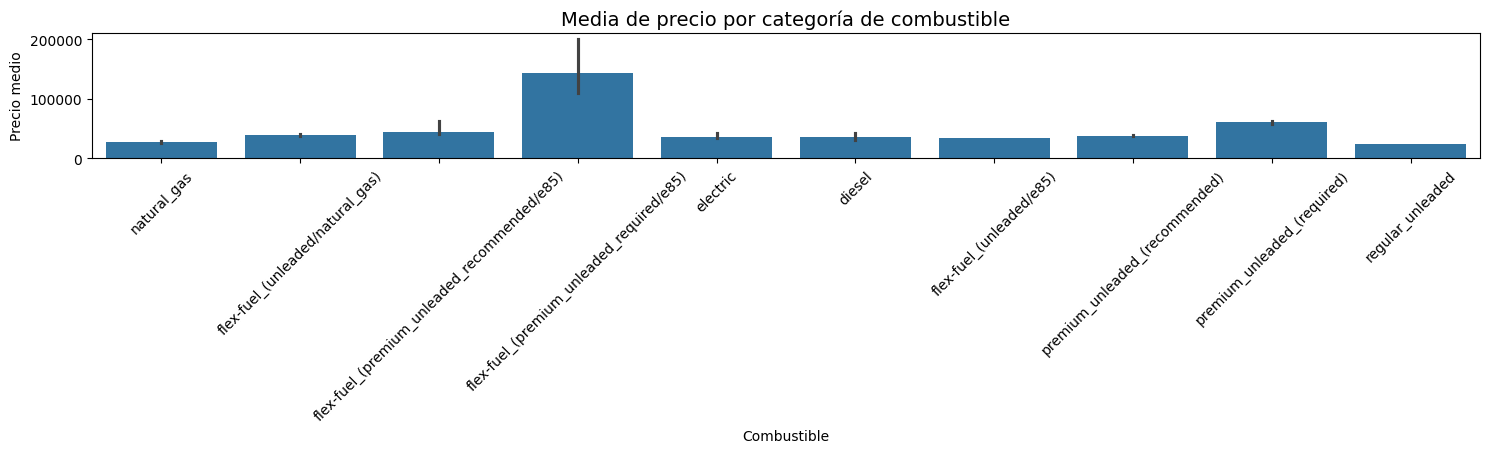

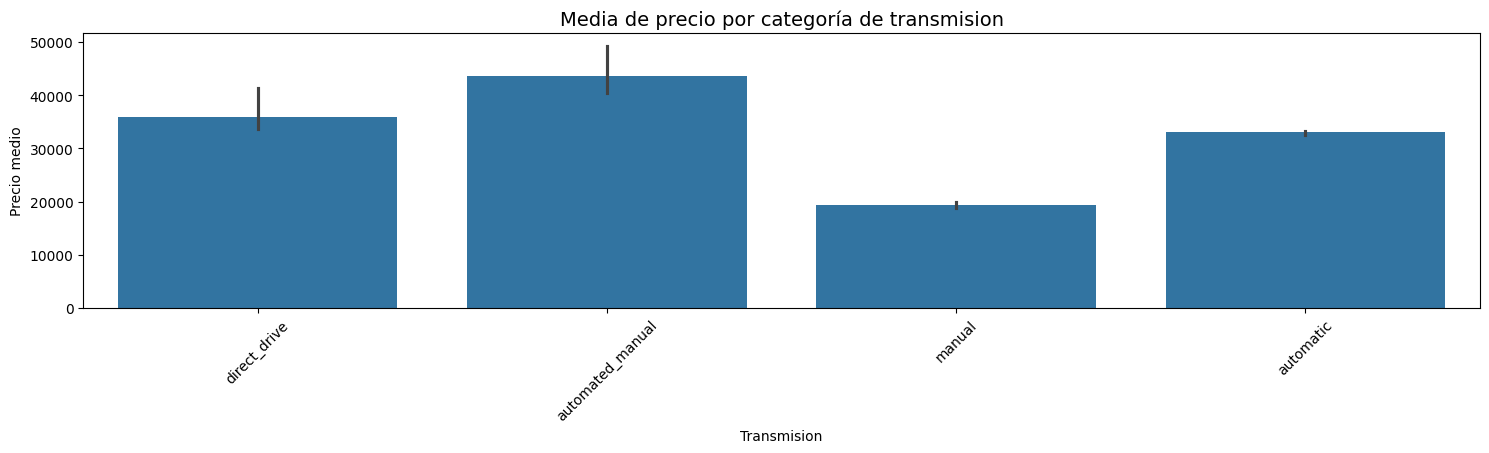

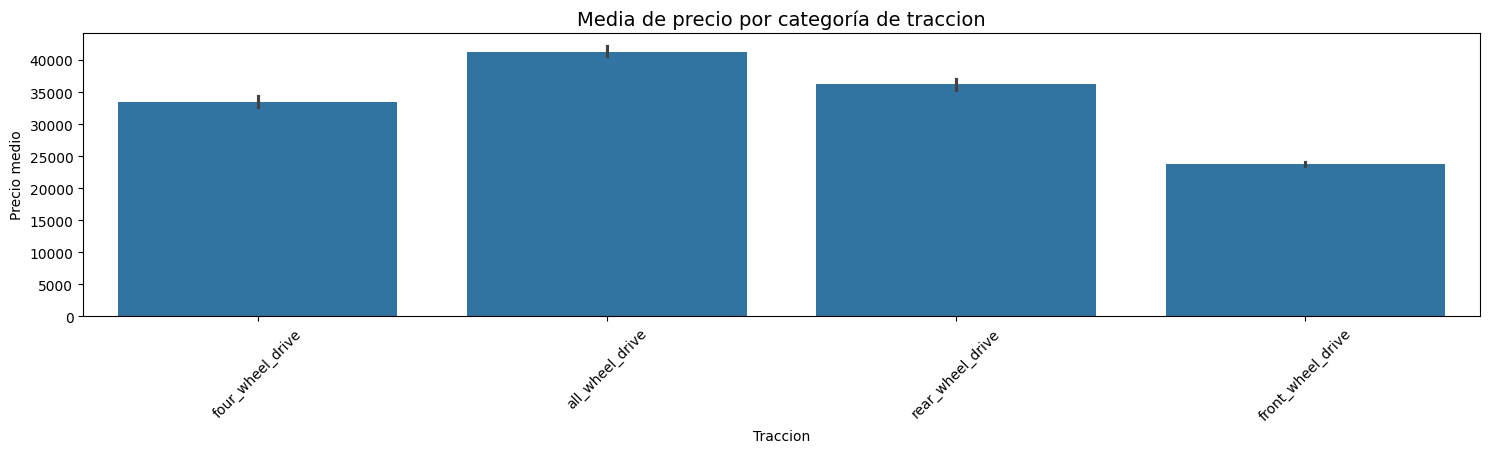

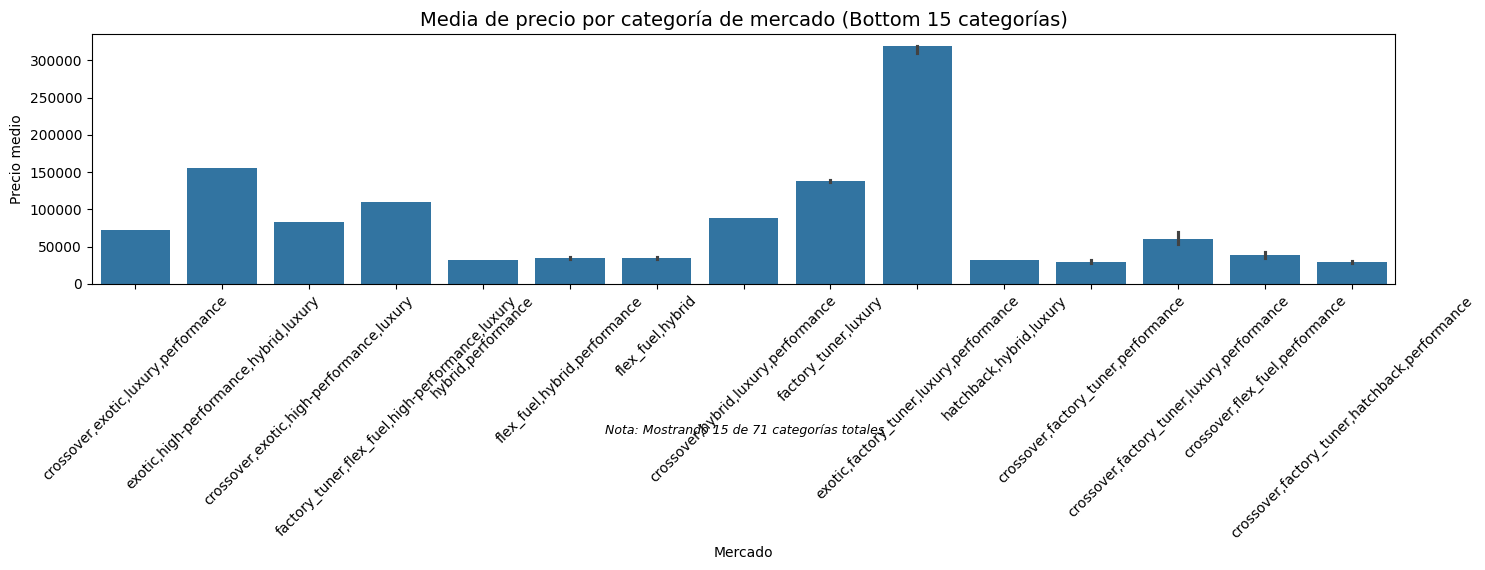

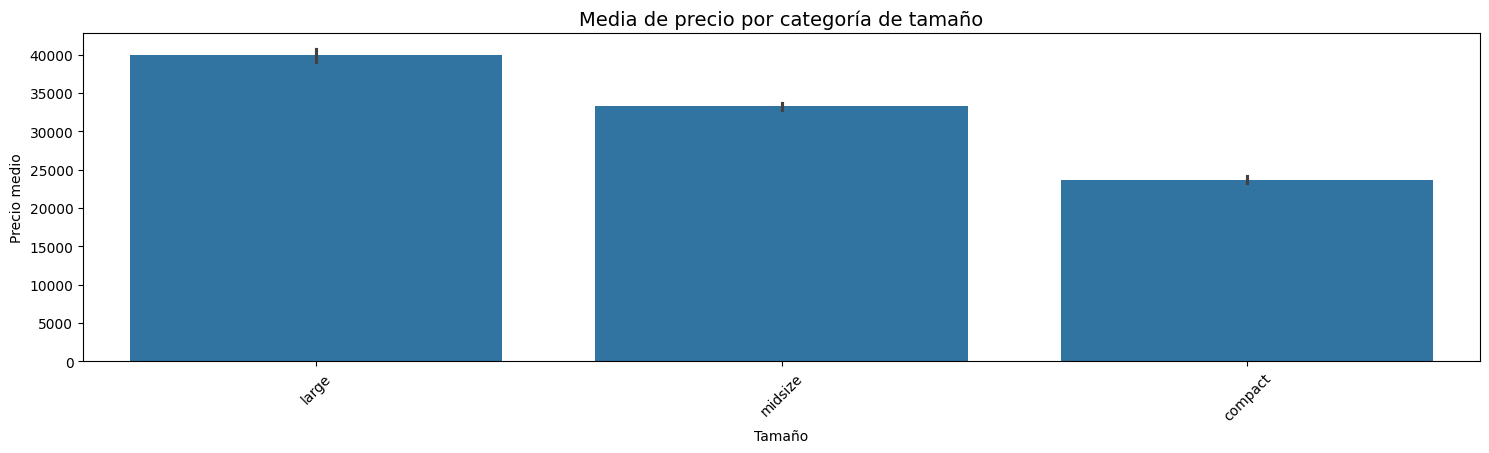

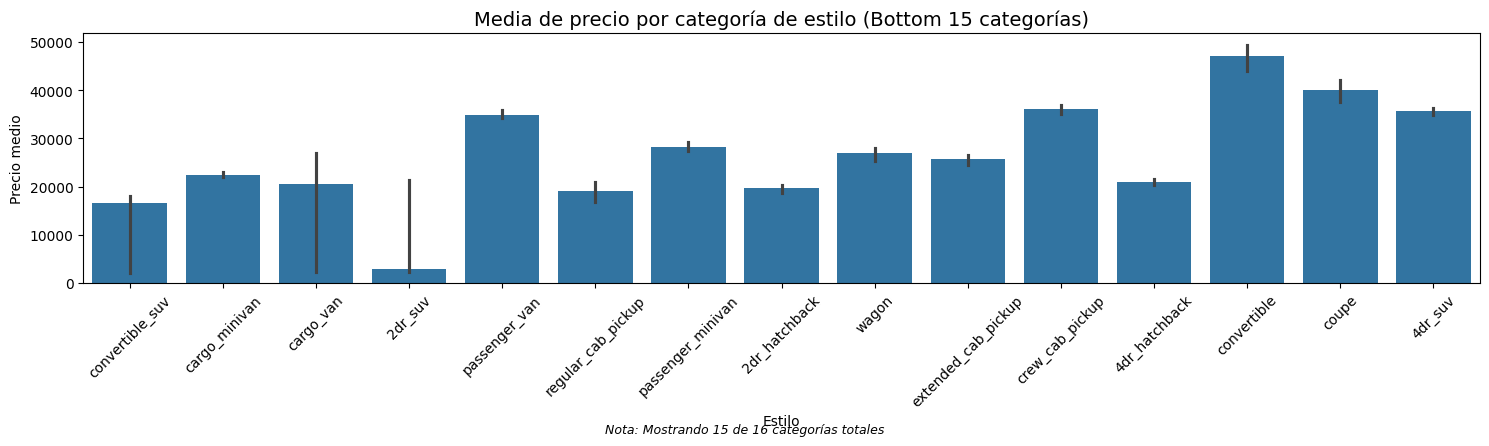

In [34]:
# Diagrama de barras: Categorías vs Precio
for var in categorical_variables:
    # Limitar a Bottom n categorías
    n = 15
    bottom_categories = df[var].value_counts().nsmallest(n)
    total_categories = df[var].nunique()
    
    # Filtrar el dataframe para incluir solo estas categorías
    df_filtered = df[df[var].isin(bottom_categories.index)]
    
    # Crear la figura con tamaño personalizado
    plt.figure(figsize=(15, 5))
    
    # Generar el gráfico de barras usando la mediana como estimador
    sns.barplot(data=df_filtered, x=var, y="precio", estimator=np.median, order=bottom_categories.index)
    
    # Añadir título y formato a los ejes
    if total_categories > n:
        plt.title(f"Media de precio por categoría de {var} (Bottom {n} categorías)", fontsize=14)
    else:
        plt.title(f"Media de precio por categoría de {var}", fontsize=14)
        
    plt.xticks(rotation=45)
    plt.ylabel("Precio medio")
    plt.xlabel(var.capitalize())
    
    # Ajustar el diseño para que no se corten las etiquetas
    plt.tight_layout()

    # Ajustar manualmente los márgenes
    if total_categories > n:
        # Más espacio en la parte inferior para la nota
        plt.subplots_adjust(top=0.85, bottom=0.35)
        
        # Añadir nota informativa sobre datos omitidos con más espacio
        plt.figtext(0.5, 0.05, 
                   f"Nota: Mostrando {n} de {total_categories} categorías totales", 
                   ha="center", fontsize=9, style='italic')
    else:
        # Sin nota, solo ajustar el título superior
        plt.subplots_adjust(top=0.85)

Podemos extraer las siguientes conclusiones de los *boxplots* del precio y el diagrama de barras por precio medio:

- <strong>Marca</strong>: Ciertas marcas sí parecen ser relevantes para determinar el precio. Marcas como por ejemplo Bugatti, McLaren o Spyker van asociadas a coches más caros, aunque recordemos que estas marcas son las menos comunes dentro del dataset. No obstante, otras marcas como Chevrolet, Ford, Toyota, Volkswagen o Nissan no son suficientes para influenciar en el precio, pues este se distribuye de forma muy similar entre ellas (excepto por los atípicos), siendo además las marcas más frecuentes. Por lo tanto, prevemos que la influencia de
esta variable en el Precio será baja, salvo para ciertas marcas más específicas.

- <strong>Modelo</strong>: Esta variable se comporta de forma similar a la variable Marca, pues no apreciamos una correlación significativa que permita discernir el precio por el modelo del vehículo salvo en casos concretos. Es posible que ambas variables combinadas, Marca y Modelo, aporten la significancia suficiente como para predecir el precio de forma más precisa.

- <strong>Combustible</strong>: Apreciamos una buena correlación con el precio, pues este se distribuye de forma diferente en función del tipo de combustible. Los de tipo flex-fuel (premium unleaded required/E85) y premium unleaded (required) son los asociados a vehículos más caros. No obstante, esta variable también contiene *outliers* que pueden suponer un problema, por obstruir la asociación precisa de un tipo de combustible con un precio determinado. Aún así, esperamos que la influencia de dicha variable sea moderada.

- <strong>Transmisión</strong> y <strong>Tracción</strong>: De nuevo, el tipo de transmisión y la tracción sí parecen asociarse con el precio, aunque la cantidad de *outliers* dificultará su utilización. Esperamos una influencia moderada de estas variables.

- <strong>Mercado</strong>: A pesar de la presencia de *outliers*, las distribuciones de precio (media, en diagramas de barras, y mediana y rangos intercuartílicos, en *boxplots*) varían sustancialmente entre los diferentes mercados, por lo que pensamos que la contribución de esta variable a la variable objetivo será alta. No obstante, queda lidiar con el problema de los valores nulos. La solución que aplicaremos posteriormente consistirá en imputar los valores de Mercado en función del resto de características que presente el vehículo y marcar en una variable *feature* (booleana) que el valor ha sido imputado. Así, en el caso en el que el modelo de ML que apliquemos obtenga unas malas métricas, podremos eliminar los registros imputados y reevaluar el modelo en el dataset limpio.

- <strong>Tamaño</strong>: El ticket medio (precio medio) sí es diferente para cada categoría, aunque la ingente cantidad de *outliers* ponen en duda la viabilidad de esta variable.

- <strong>Estilo</strong>: Contiene una gran cantidad de *outliers* en las categorías Sedan, 4DR Suv, Coupe y Convertible, que como sabemos de antemano representan las principales categorías del dataset. Aunque el resto de variables en sí, sí parecen correlacionarse con el precio, la alta presencia de *outliers* en las categorías principales resulta preocupante.

Prosigamos con las variables numéricas.

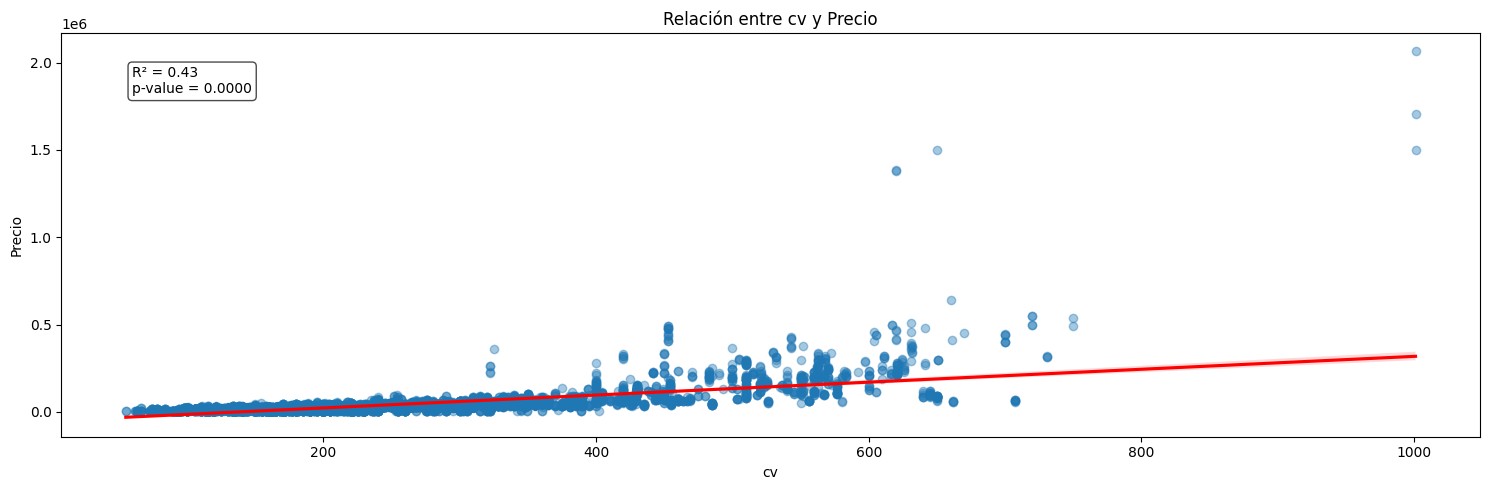

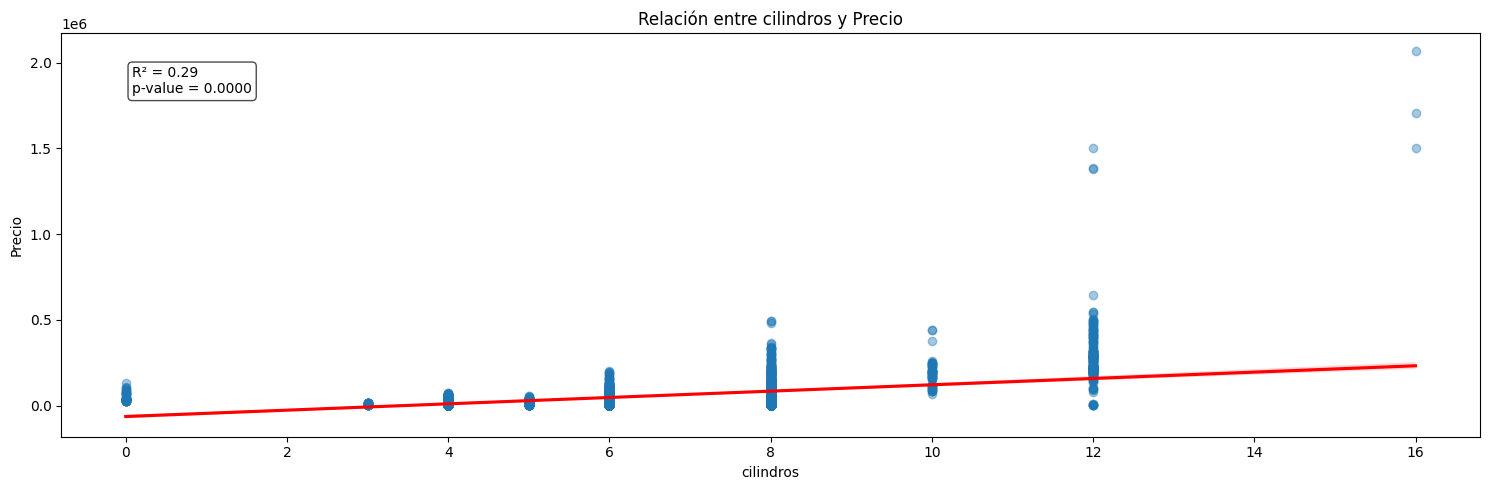

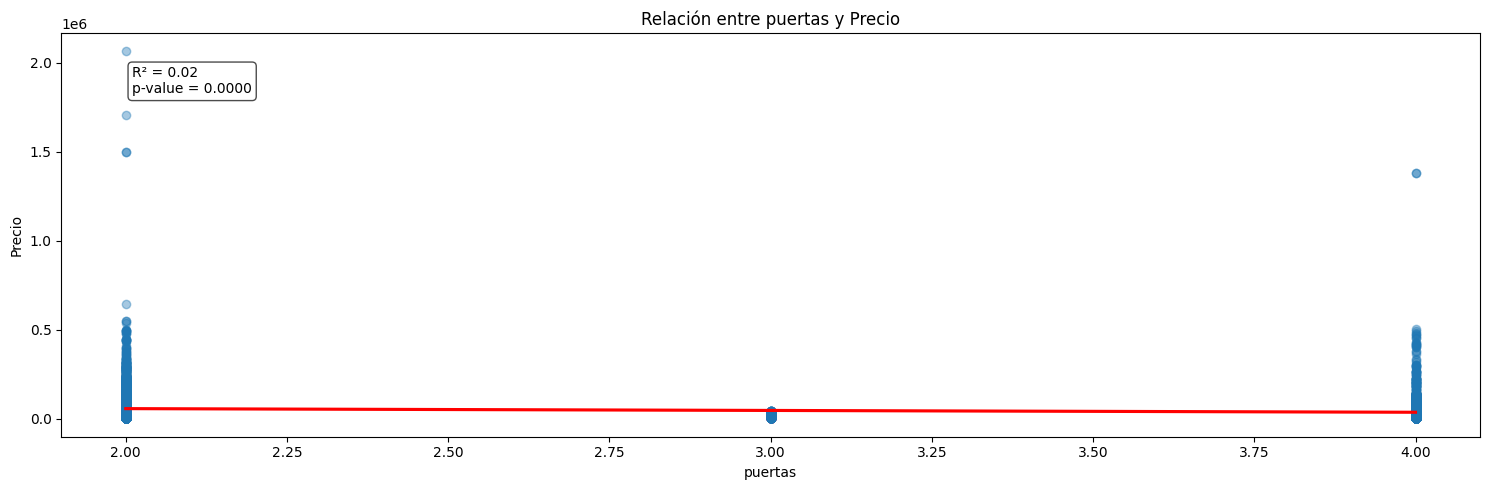

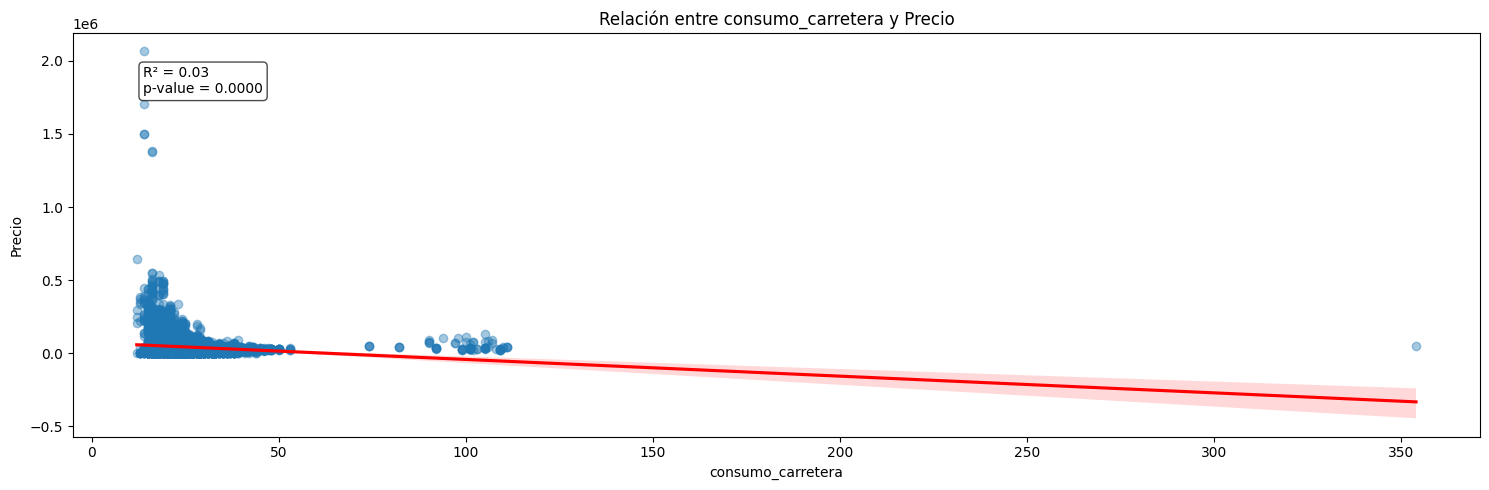

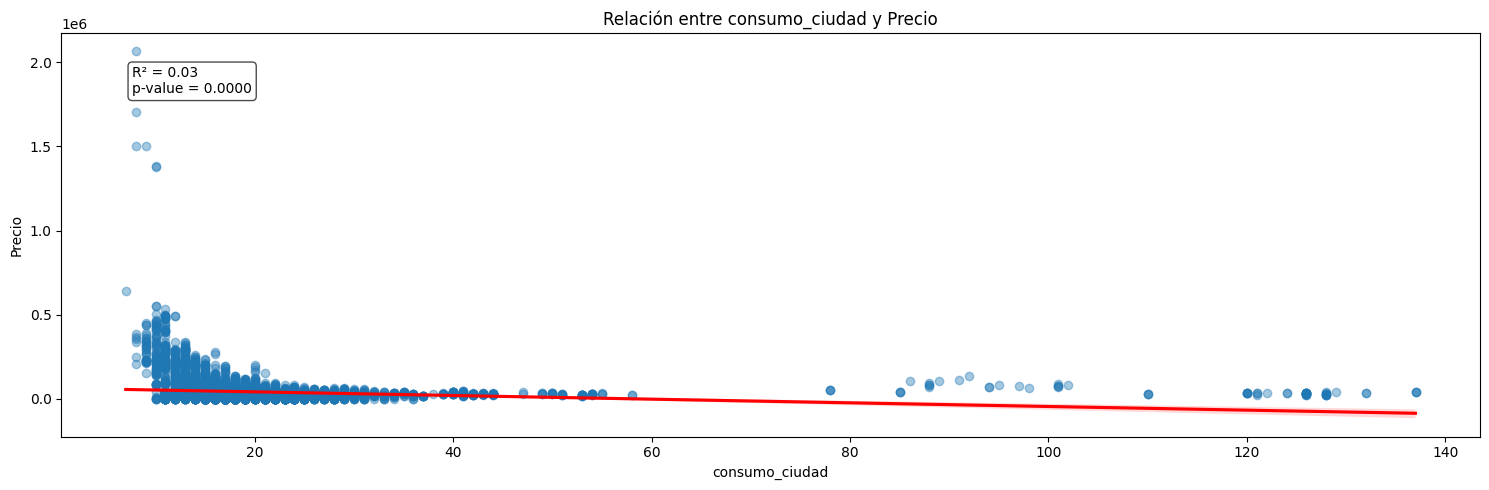

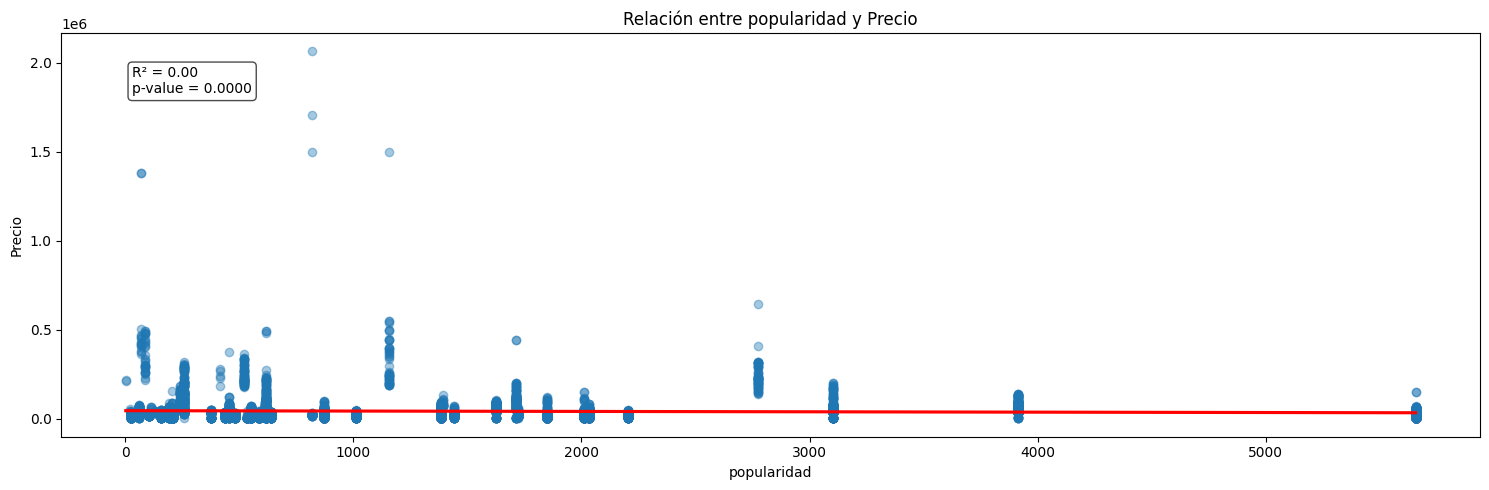

In [35]:
# Scatterplots: var - Precio
for var in numerical_variables:
    if var not in ["año", "precio"]:
        # Eliminar filas con NaN para el cálculo de la regresión
        df_clean = df[[var, "precio"]].dropna()
        
        # Calcular la regresión lineal
        slope, intercept, r_value, p_value, std_err = linregress(df_clean[var], df_clean["precio"])
        
        # Crear la figura
        fig, ax = plt.subplots(figsize=(15, 5))
        
        # Crear el gráfico de dispersión con línea de regresión
        sns.regplot(data=df, x=var, y="precio", scatter_kws={'alpha':0.4}, line_kws={'color':'red'})
        
        # Añadir texto con los coeficientes y estadísticos
        text = (f"R² = {r_value**2:.2f}\n"
                f"p-value = {p_value:.4f}")
        
        # Posicionar el texto (ajustado para evitar superposición)
        # Posición en el 5% desde la izquierda y 85% desde abajo
        plt.text(0.05, 0.85, text, transform=ax.transAxes, 
                 bbox=dict(facecolor='white', alpha=0.7, boxstyle='round'))
        
        # Título y etiquetas
        plt.title(f"Relación entre {var} y Precio")
        plt.xlabel(var)
        plt.ylabel("Precio")
        
        # Ajustar el diseño para que no se corten las etiquetas
        plt.tight_layout()

En todas las regresiones construidas se obtiene un $R^{2}$ muy bajo, junto con un p-valor inferior a 0.05. Esto indica que la relación entre cada variable predictora y la variable objetivo (precio) es estadísticamente significativa, pero poco explicativa. En otras palabras, las variables numéricas sí presentan una relación real con el precio, pero dicha relación es linealmente débil.

Por tanto, para modelar adecuadamente el precio será necesario recurrir a **modelos no lineales** que puedan capturar interacciones complejas y combinar múltiples variables de forma simultánea.

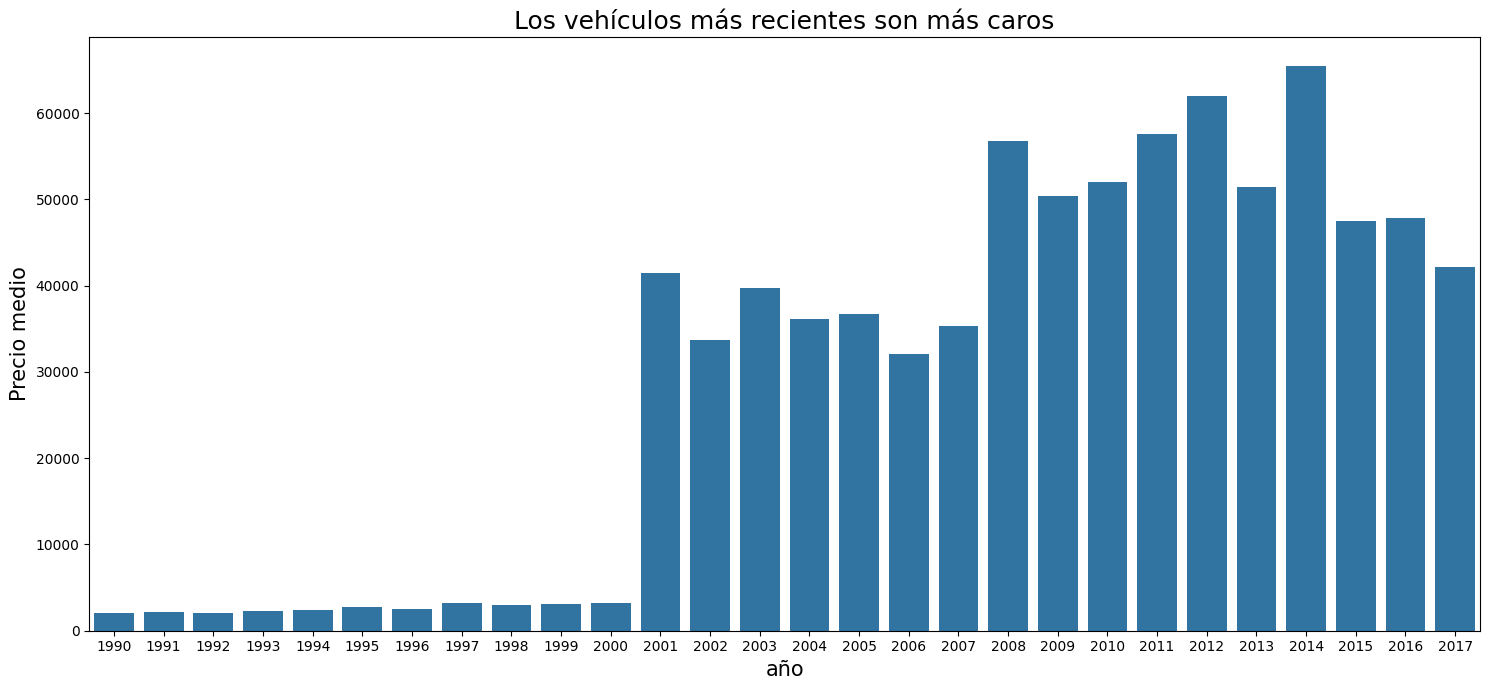

In [36]:
## Precio medio por año
df_filtered = df[["año", "precio"]]

df_grouped = df_filtered.groupby("año", as_index=False).mean()

# Crear la figura
fig, ax = plt.subplots(figsize=(15, 7))

# Crear el gráfico de dispersión con línea de regresión
sns.barplot(data=df_grouped, x="año", y="precio")

# Título y etiquetas
plt.title(f"Los vehículos más recientes son más caros", fontsize=18)
plt.xlabel("año", fontsize=15)
plt.ylabel("Precio medio", fontsize=15)
        
# Ajustar el diseño
plt.tight_layout()

Asimismo, encontramos crecimiento explosivo del precio medio a partir del año 2000, a partir del cual el precio medio se ha mantenido estable hasta volver a incrementarse a partir del 2007.

#### 4.1.3 Multivariante

Como parte final del análisis exploratorio, queda realizar un análisis multivariante.

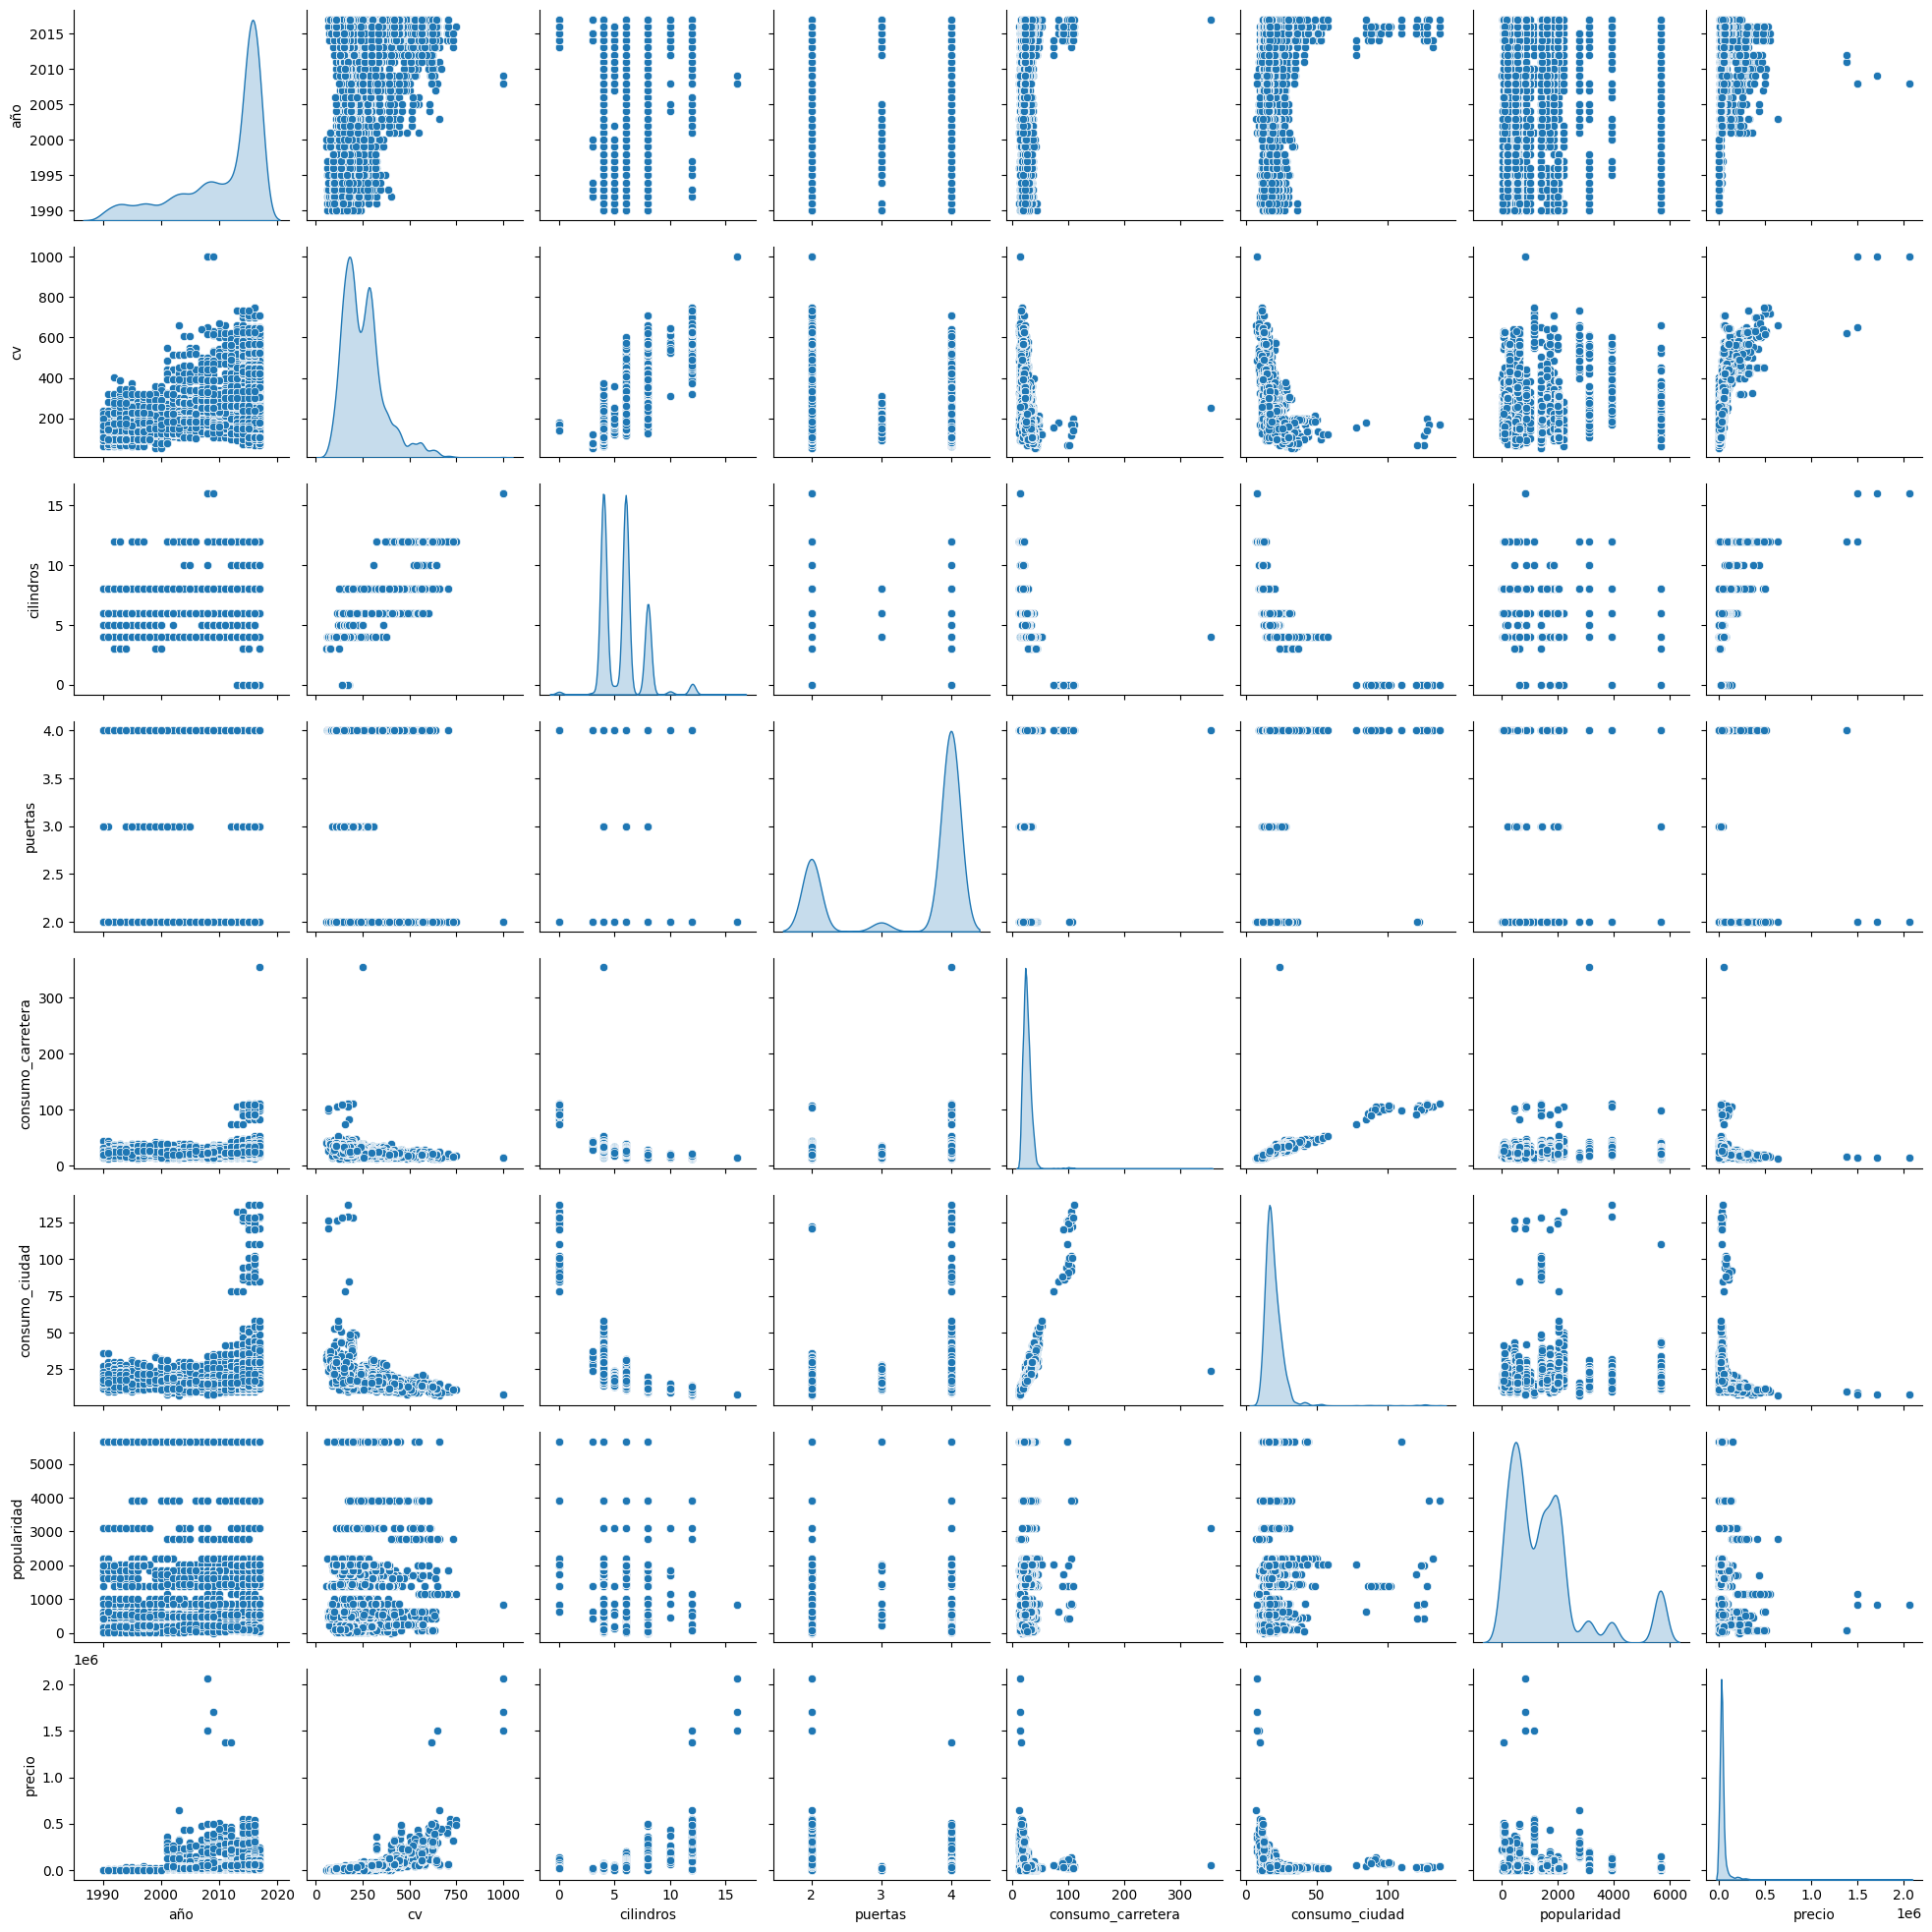

In [37]:
# Diagrama por pares
sns.pairplot(data=df[numerical_variables], diag_kind="kde")

Del diagrama anterior apreciamos:

- Año:
	- Hay más cantidad de vehículos modernos.
	- Los vehículos más modernos suelen tener más caballos.
	- El consumo de los vehículos más modernos (>2015) es mayor.
	- Los vehículos más caros se vendieron entre los 2000 y el 2017.
	- El año es independiente de las puertas, los cilindros y la popularidad.

- CV (Caballos de Potencia):
	- La mayoría de los vehículos tienen entre los ~200 CV y los ~300 CV.
	- A mayor cantidad de cilindros, más potencia.
	- Los vehículos menos potentes tienen un mayor consumo.
	- La potencia es independiente del número de puertas y la popularidad.

- Cilindros:
	- La mayoría de los vehículos tienen 4 o 6 cilindros.
	- El consumo es mayor en vehículos con pocos cilindros.
	- A mayor cantidad de cilindros, mayor es el precio.
	- El número de cilindros es independiente del número de puertas y la popularidad

- Puertas:
	- La mayoría de los vehículos tiene 4 puertas.
	- Aparecen valores de consumos más altos en vehículos con 4 puertas.
	- El precio máximo es ligeramente más alto en vehículos con 2 puertas (apenas apreciable).
	- La popularidad es independiente de las puertas.

- Consumos (carretera y ciudad):
	- Los consumos por carretera y ciudad están altamente correlacionados entre sí.
	- Los consumos son independientes de la popularidad.
	- El precio es mayor en vehículos de bajo consumo (son más codiciados) y más bajo en consumos altos (desinterés).

- Precio:
	- Los vehículos más caros tienen una popularidad relativamente "baja".

Text(0.5, 1.0, 'Matriz de correlación')

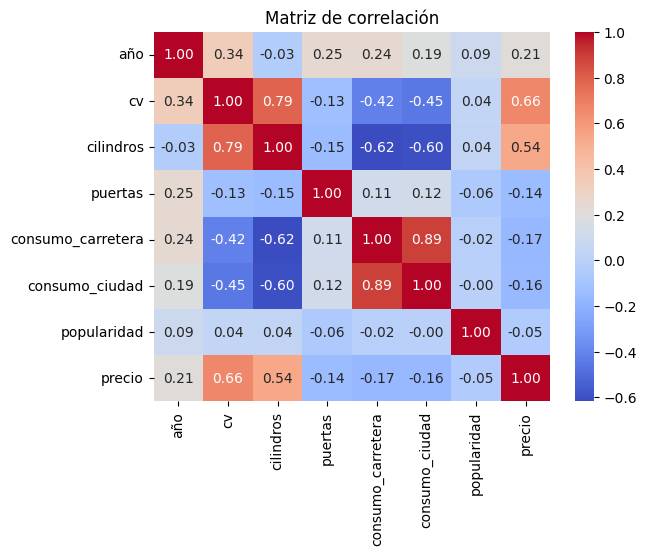

In [38]:
# Mapa de calor
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matriz de correlación")

En el mapa de calor observamos que el consumo en carretera y el consumo en ciudad tienen una correlación (Pearson) de 0.89 y que la potencia (CV) también tiene una correlación importante con los cilindros, de 0.79.

Los modelos basados en árboles son resilientes a la multicolinealidad. Sin embargo, un análisis de importancia de variables (feature importance) puede inducir a error si la importancia de una característica queda repartida entre 2 variables. Por ende, decidimos eliminar la variable Consumo en Ciudad por superar el umbral de 0.85 de correlación.

In [39]:
df.drop(columns="consumo_ciudad", inplace=True)

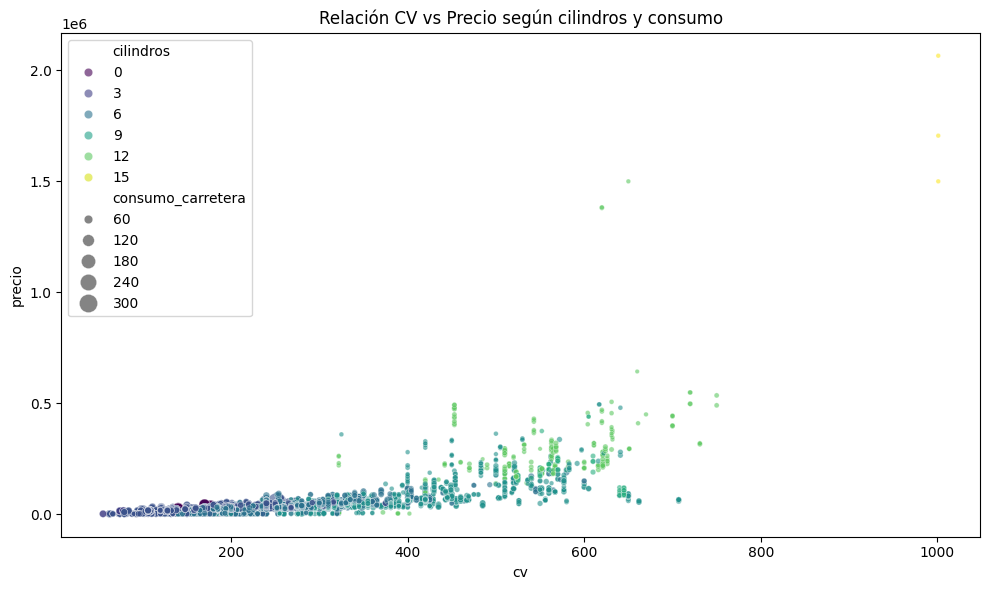

In [40]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="cv", y="precio", hue="cilindros", size="consumo_carretera", alpha=0.6, palette="viridis", sizes=(10, 200))
plt.title("Relación CV vs Precio según cilindros y consumo")
plt.tight_layout()

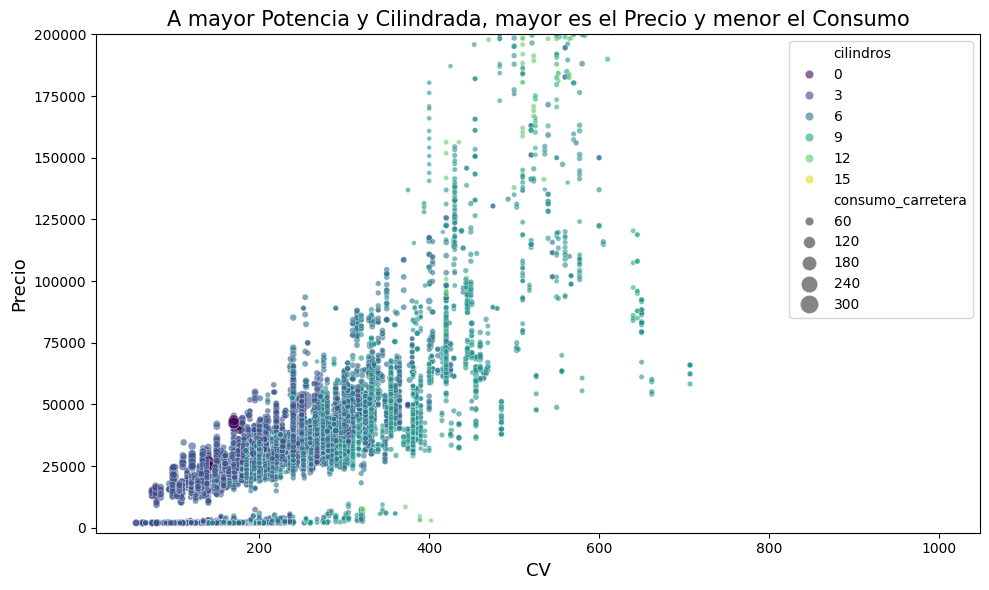

In [41]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="cv", y="precio", hue="cilindros", size="consumo_carretera", alpha=0.6, palette="viridis", sizes=(10, 200))
#plt.title("Relación CV vs Precio según cilindros y consumo")
plt.title("A mayor Potencia y Cilindrada, mayor es el Precio y menor el Consumo", fontsize=15)
plt.xlabel("CV", fontsize=13)
plt.ylabel("Precio", fontsize=13)
plt.ylim([-2e3, 2e5])
plt.tight_layout()

La tendencia de diagrama de dispersión indica que el precio de los vehículos es mayor cuanto mayor es su potencia y su cilindrada, especialmente para vehículos superiores a 400 CV. Además, también vemos que el consumo es mayor en aquellos con baja potencia y cilindrada, motivo que puede explicar por qué su precio es más bajo: los clientes son reacios a comprar vehículos con alto consumo y baja potencia, es decir, vehículos poco eficientes.

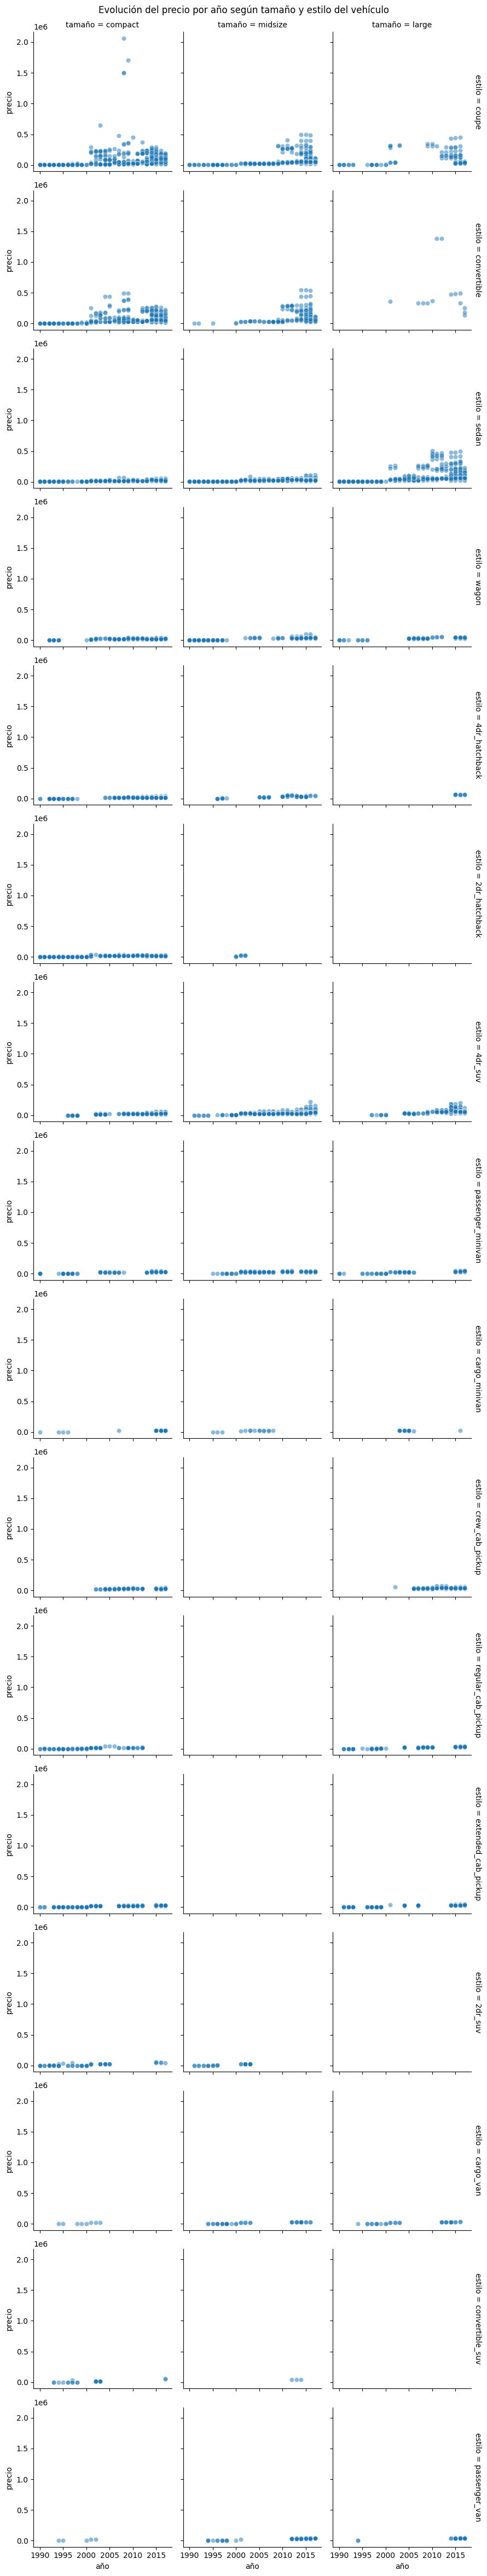

In [42]:
# Crear un FacetGrid para analizar precio por año, separado por tamaño y estilo
g = sns.FacetGrid(df, col="tamaño", row="estilo", margin_titles=True)

# Mapear scatterplot
g.map(sns.scatterplot, "año", "precio", alpha=0.5)

# Título general
g.fig.suptitle("Evolución del precio por año según tamaño y estilo del vehículo")

# Ajustar el gráfico
plt.tight_layout()
plt.subplots_adjust(top=0.97)  # Dejar espacio para el título

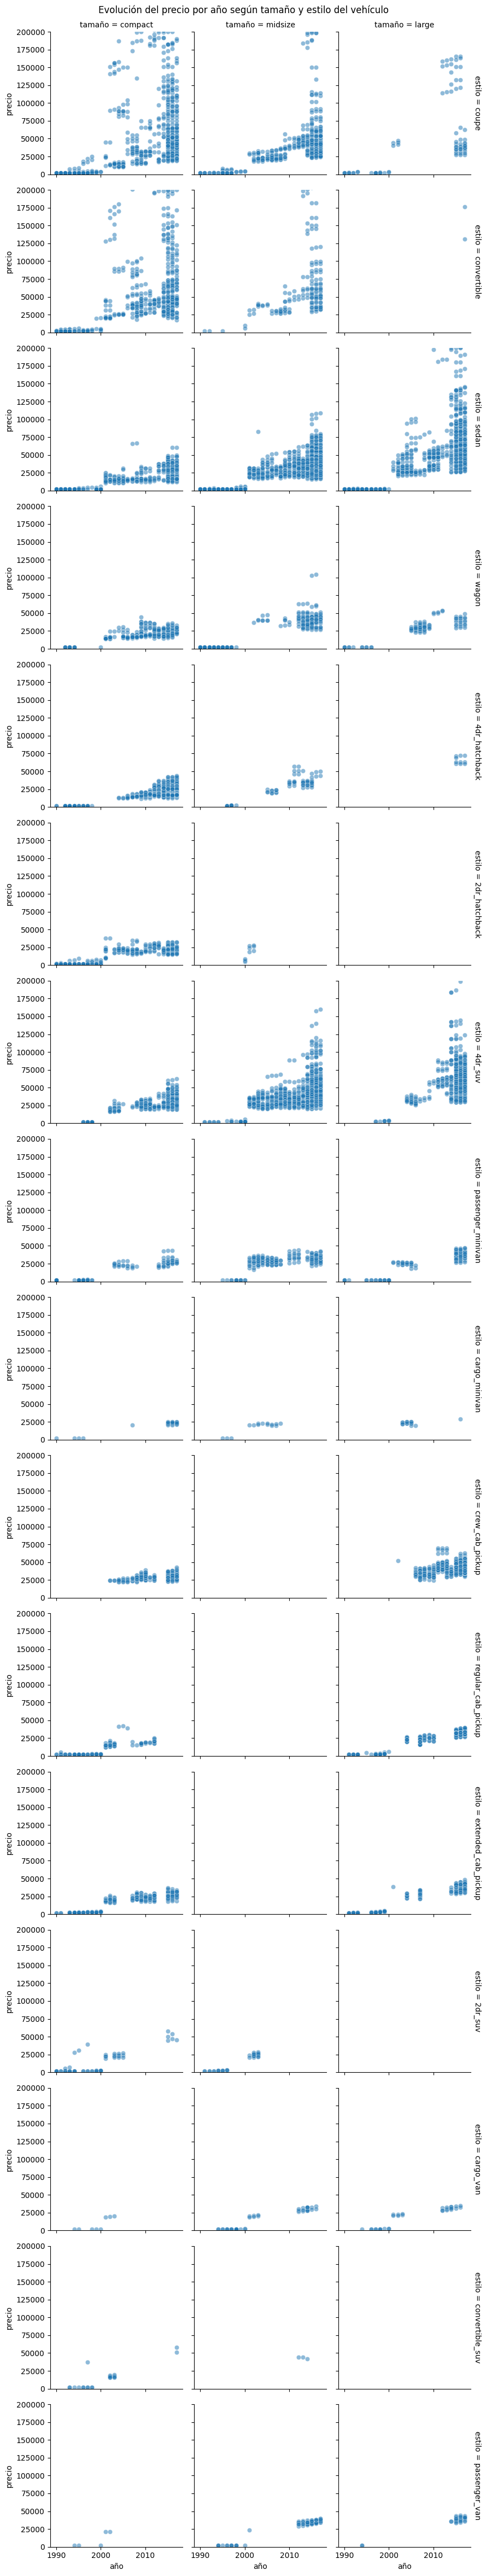

In [43]:
g = sns.FacetGrid(df, col="tamaño", row="estilo", margin_titles=True)

g.map(sns.scatterplot, "año", "precio", alpha=0.5)

# Establecer límiyes para el eje Y para observar mejor vehículos de bajo precio
g.set(ylim=(0, 2e5))

g.fig.suptitle("Evolución del precio por año según tamaño y estilo del vehículo")

plt.tight_layout()
plt.subplots_adjust(top=0.97)

In [44]:
print(f"Porcentaje de representación de cada estilo en el dataset:\n{round(df['estilo'].value_counts() / len(df) * 100, 2)}")

Porcentaje de representación de cada estilo en el dataset:
estilo
sedan                  25.39
4dr_suv                21.73
coupe                  10.49
convertible             6.62
4dr_hatchback           5.92
crew_cab_pickup         5.85
extended_cab_pickup     5.33
wagon                   5.02
2dr_hatchback           3.68
passenger_minivan       3.47
regular_cab_pickup      3.08
passenger_van           1.08
2dr_suv                 0.81
cargo_van               0.75
cargo_minivan           0.53
convertible_suv         0.25
Name: count, dtype: float64


La evolución del precio en función del tamaño y el estilo del vehículo revela patrones interesantes: en prácticamente todos los grupos, independientemente del tamaño o estilo, se observa un incremento progresivo del precio con el paso del tiempo, especialmente a partir de los años 2000 y 2015. Este fenómeno podría estar asociado al efecto de la inflación en el mercado automovilístico, así como al aumento en la complejidad tecnológica y los estándares de seguridad.

En cuanto al tamaño, parece ser un buen predictor del precio, pero dependiente del estilo. En estilos como Sedan y 4DR SUV, cuanto mayor es el tamaño, mayor es el precio de los vehículos; en cambio, en Coupe y Convertible, a menor tamaño, más caro el vehículo. Estas 4 categorías representan casi el 65% del total de vehículos. Esperamos que el tamaño ejerza una influencia moderada en el precio del vehículo, pero solo si se usa en consonancia con otra variable adicional como puede ser el estilo.

Respecto al estilo, se aprecian diferencias significativas en el precio únicamente en los vehículos Coupe, Convertible, Sedan y 4DR SUV. El resto de estilos presentan distribuciones de precio muy similares. Aun así, estas cuatro categorías combinadas constituyen aproximadamente el 65 % del dataset, lo que justifica que el estilo, también pueda tener un impacto moderado.

En resumen, el año de fabricación es una variable con clara influencia sobre el precio, incluso utilizada por separado. Asimismo, las variables de tamaño y estilo, usadas en consonancia, también ejercen una influencia notable en el precio.

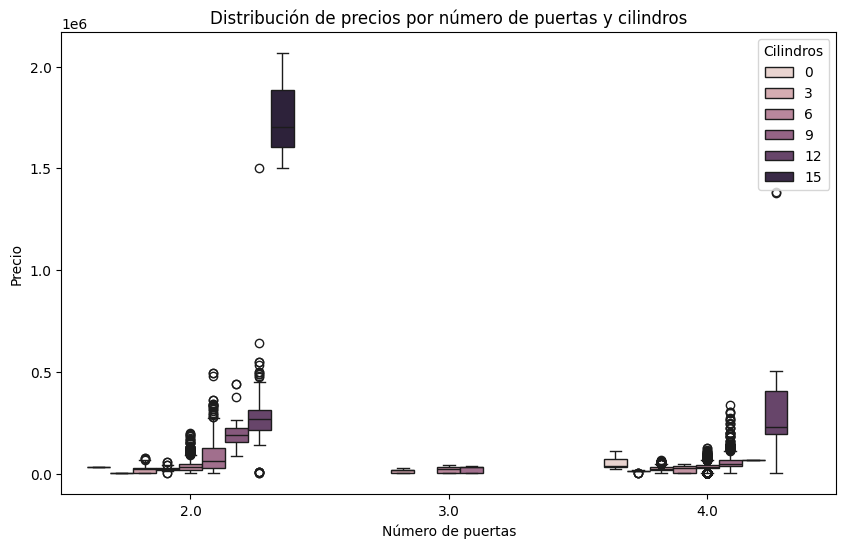

In [45]:
# Crear el boxplot
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x="puertas", y="precio", hue="cilindros")

# Añadir título
plt.title("Distribución de precios por número de puertas y cilindros")

# Etiquetas
plt.xlabel("Número de puertas")
plt.ylabel("Precio")

# Leyenda
plt.legend(title="Cilindros")

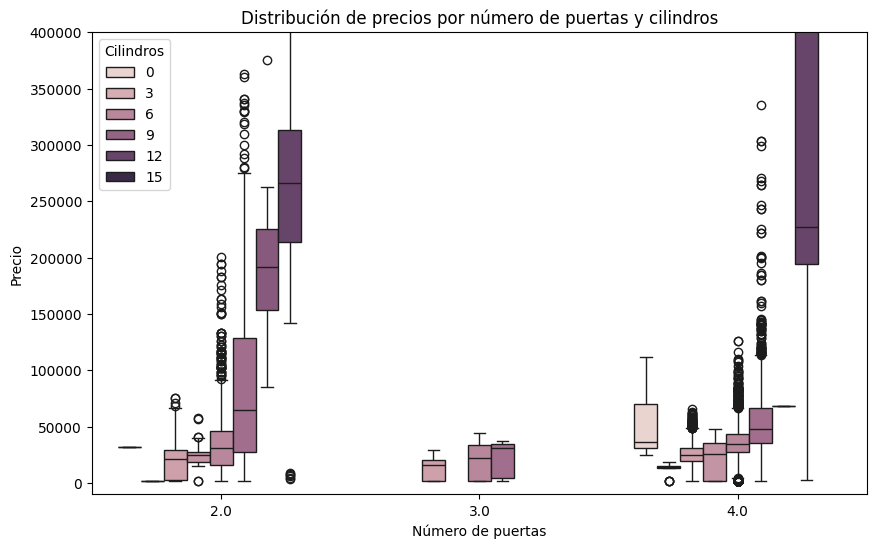

In [46]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x="puertas", y="precio", hue="cilindros")
# Limitar eje Y
plt.ylim([-1e4, 4e5])

plt.title("Distribución de precios por número de puertas y cilindros")

plt.xlabel("Número de puertas")
plt.ylabel("Precio")

plt.legend(title="Cilindros")

De las 2 figuras anteriores concluimos que el precio guarda más relación con el número de cilindros que con el número de puertas, siendo cierto que no existen vehículos de 3 puertas "caros" en este dataset y que los vehículos de 2 puertas ostentan el récord del precio más alto.

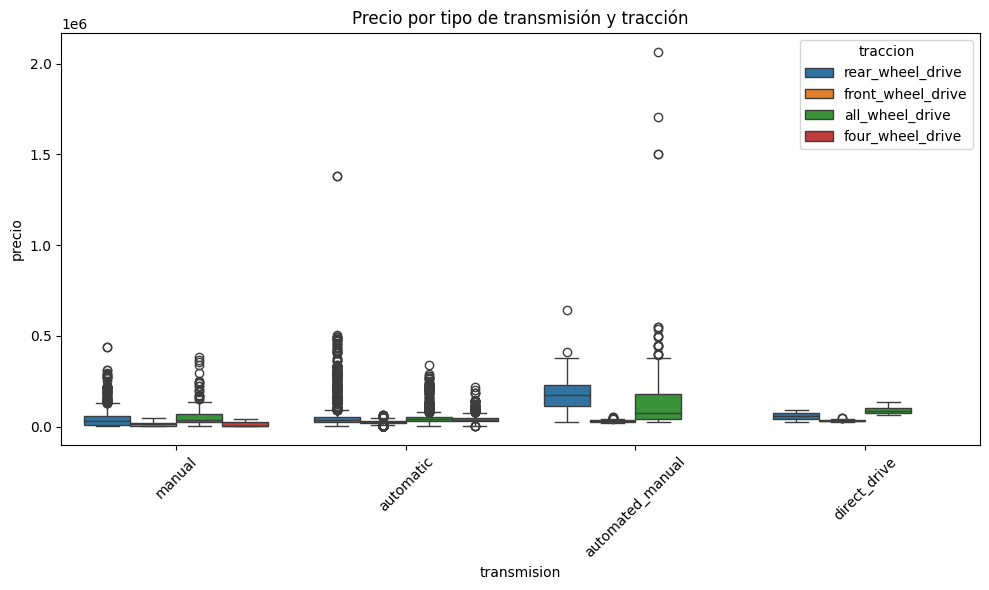

In [47]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="transmision", y="precio", hue="traccion")
plt.title("Precio por tipo de transmisión y tracción")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

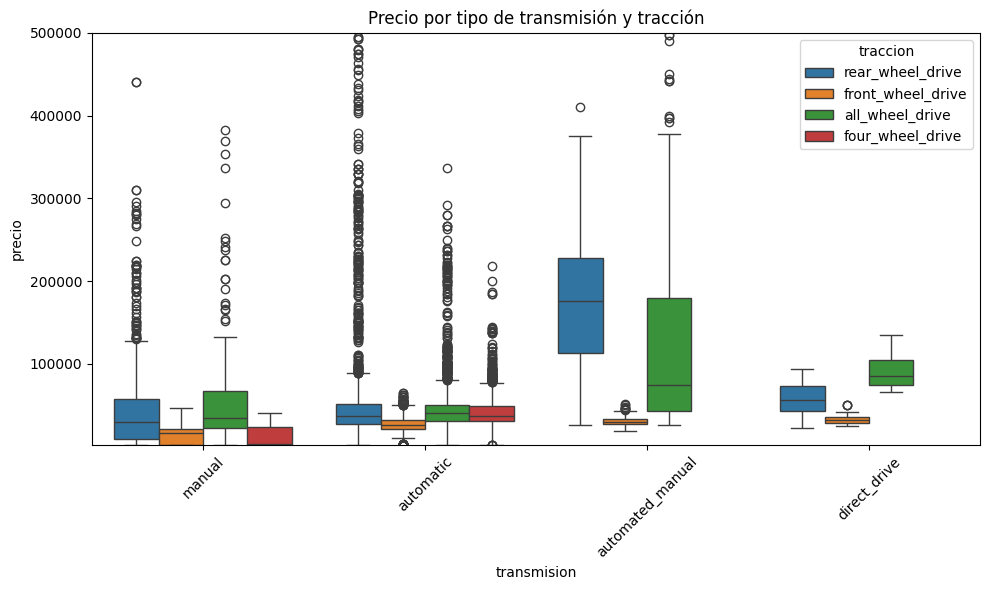

In [48]:
# Limitar eje Y
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="transmision", y="precio", hue="traccion")
plt.title("Precio por tipo de transmisión y tracción")
plt.ylim([2e3, 5e5])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

La gráfica del precio por tipo de transmisión y tracción muestra que la transmisión y la tracción sí se correlacionan en los vehículos con transmisión semiautomática (automated-manual) y de transmisión directa (direct-drive). Sin embargo, en los manuales y automáticos no hay diferencias claras entre sí, tanto entre los tipos de tracción como entre los de transmisión. Recordemos, además, que las clases de tracción tienen una participación bastante igualitaria en el dataset, mientras que las transmisiones dominantes son automáticas y manuales.

Por lo tanto, esperamos una influencia baja/moderada de la transmisión y la tracción en el precio del vehículo (por sí solas).

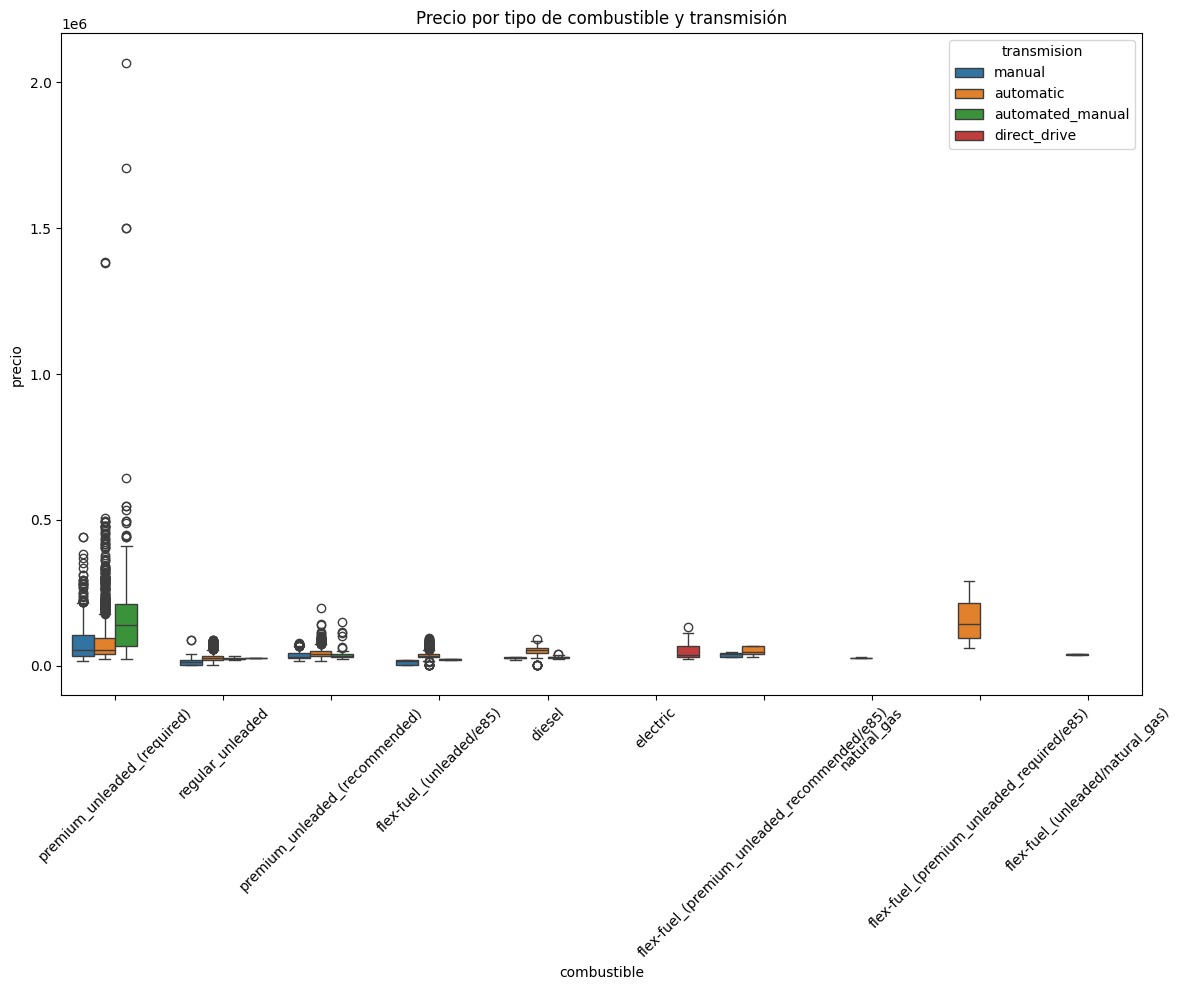

In [49]:
plt.figure(figsize=(12, 10))
sns.boxplot(data=df, x="combustible", y="precio", hue="transmision")
plt.title("Precio por tipo de combustible y transmisión")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

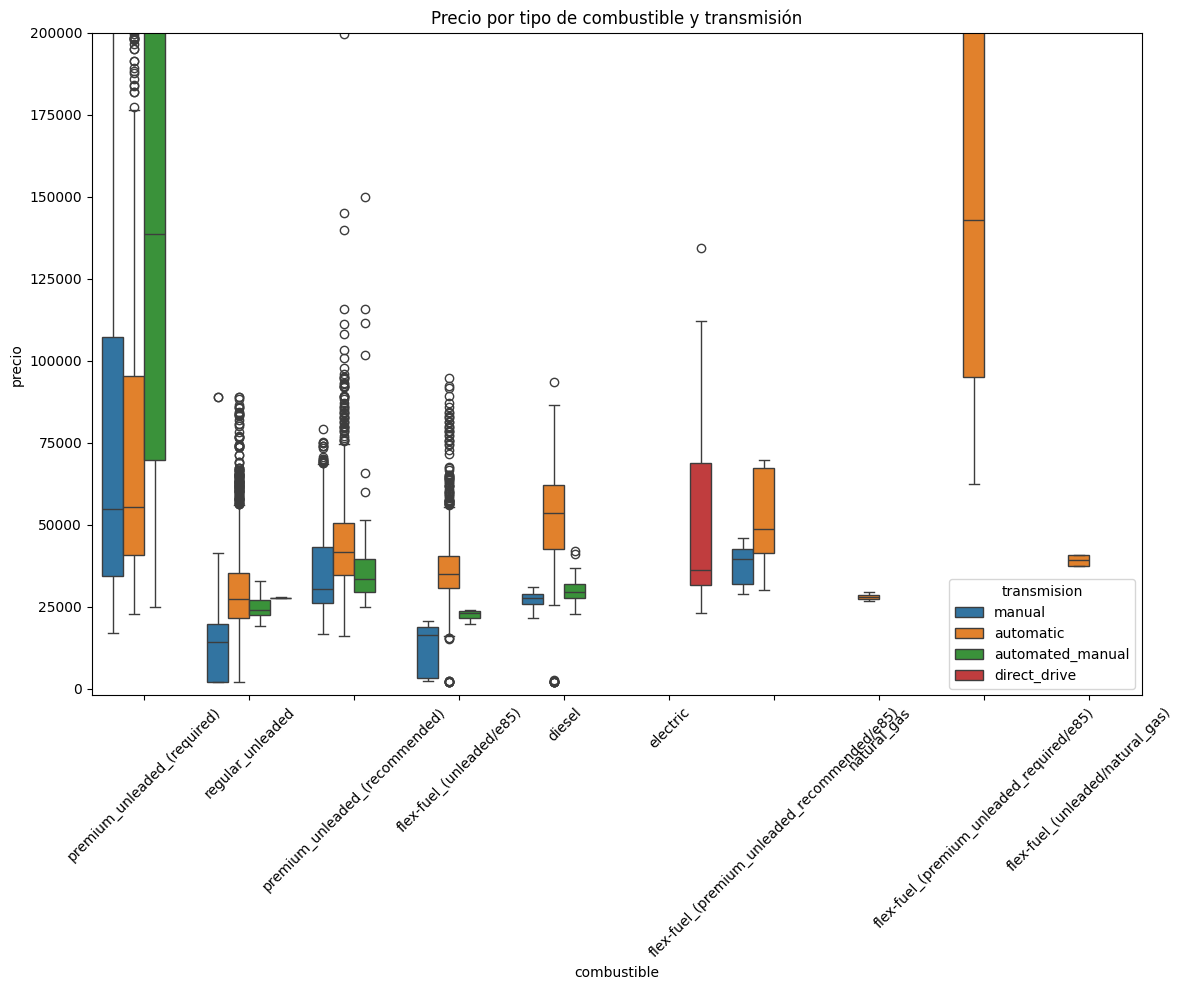

In [50]:
# Limitar eje Y
plt.figure(figsize=(12, 10))
sns.boxplot(data=df, x="combustible", y="precio", hue="transmision")
plt.title("Precio por tipo de combustible y transmisión")
plt.ylim([-2e3, 2e5])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

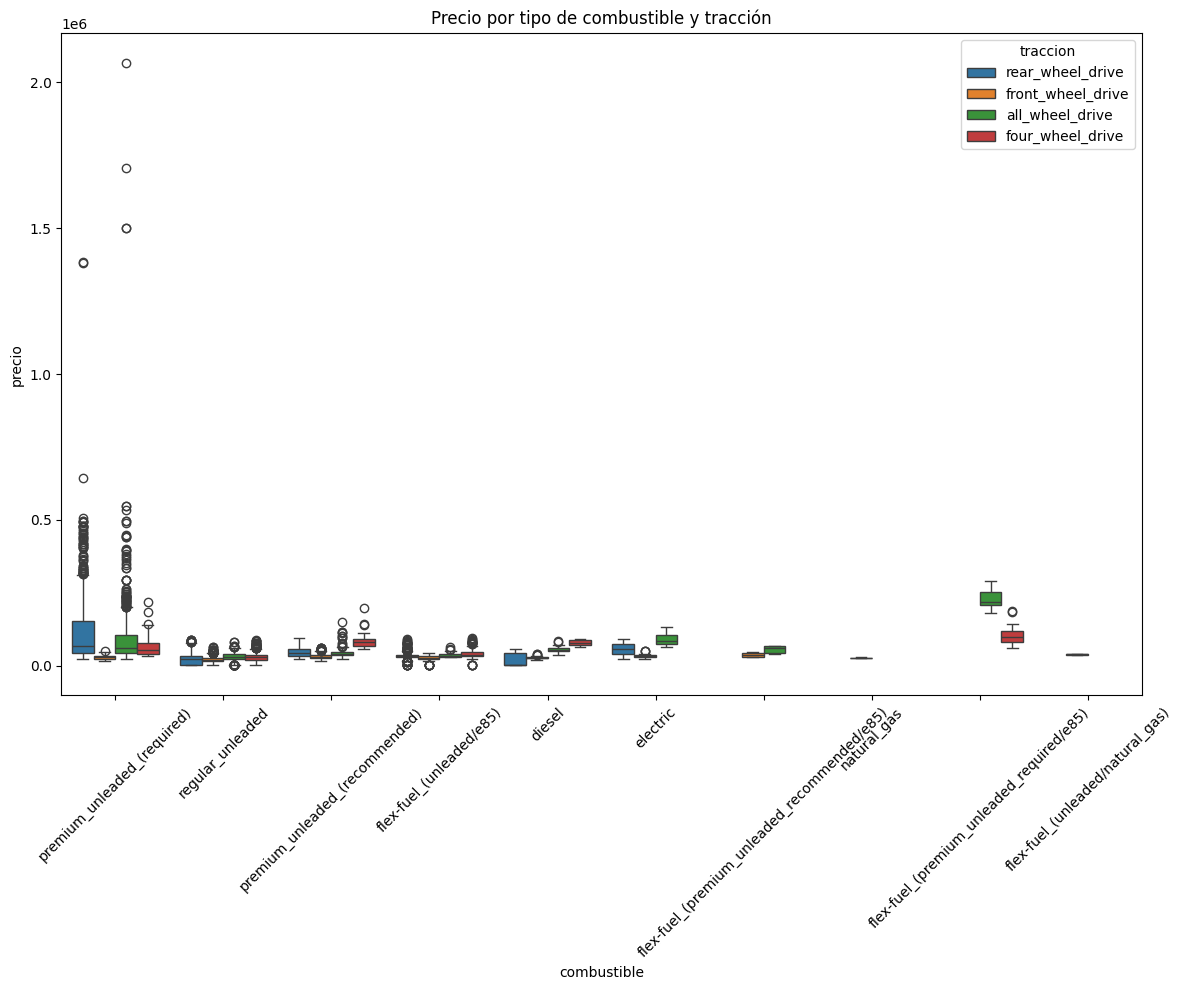

In [51]:
plt.figure(figsize=(12, 10))
sns.boxplot(data=df, x="combustible", y="precio", hue="traccion")
plt.title("Precio por tipo de combustible y tracción")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

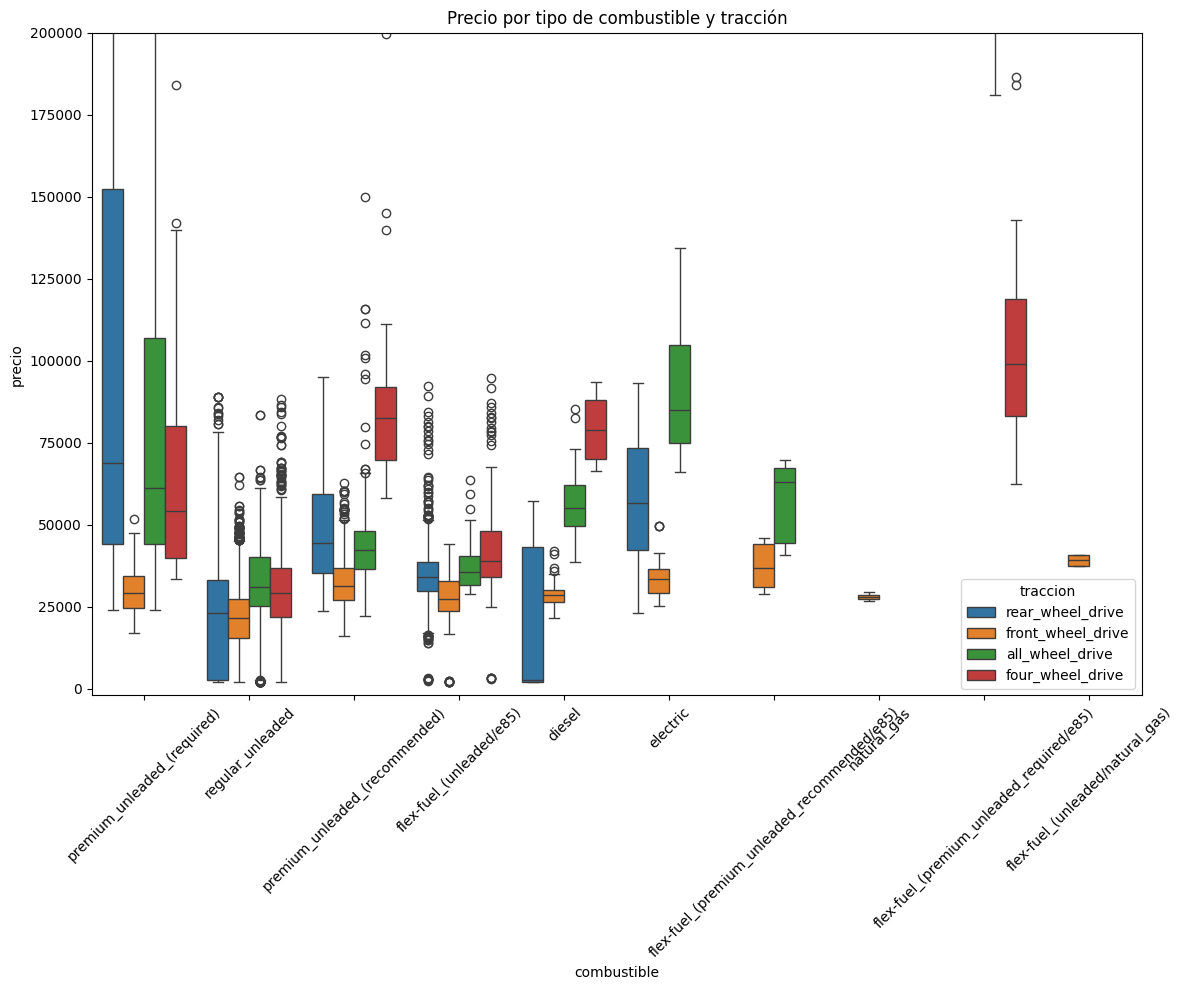

In [52]:
plt.figure(figsize=(12, 10))
sns.boxplot(data=df, x="combustible", y="precio", hue="traccion")
plt.title("Precio por tipo de combustible y tracción")
plt.xticks(rotation=45)
plt.ylim([-2e3, 2e5])
plt.tight_layout()
plt.show()

Esta gráfica muestra que sí existe relación entre el tipo de combustible y el precio. Además, parece que al combinar el tipo de combustible con otras variables como tracción y transmisión, se obtienen aún más matices en la predicción del precio.

Por ende, esperamos que la influencia del tipo de combustible en el precio sea moderada, o incluso elevada, en combinación con otras variables como transmisión y tracción.

Finalmente, nos quedaría realizar un análisis multivariante de las variables categóricas: Marca, Modelo y Mercado.

In [53]:
for x in ["marca", "modelo", "mercado"]:
    print(f"Cantidad de categorías de '{x}': {df[x].nunique()}")

Cantidad de categorías de 'marca': 48
Cantidad de categorías de 'modelo': 914
Cantidad de categorías de 'mercado': 71


Estas variables presentan una dificultad añadida: la gran cantidad de *outliers* y categorías, especialmente en el caso de la variable "Mercado". Si intentáramos representar un análisis multivariante con ellas, nos veríamos obligados a **sesgar la muestra** a las primeras o últimas N categorías, como ya se hizo en el análisis bivariante, pero ahora con la complejidad adicional de incorporar **una dimensión extra**.

En el análisis bivariante obtuvimos las siguientes conclusiones clave:

- <strong>Marca</strong>: Algunas marcas exclusivas como *Bugatti* o *McLaren* están asociadas a precios elevados, mientras que las más comunes muestran distribuciones de precio similares.
- <strong>Modelo</strong>: Presenta una relación con el precio similar a la marca, y su combinación con esta podría aportar valor predictivo.
- <strong>Mercado</strong>: Exhibe diferencias claras en las distribuciones de precio entre categorías, aunque su análisis requiere precaución debido a la presencia de valores atípicos.

Por todo ello, concluimos que lo más adecuado es **avanzar hacia la preparación del modelo** basándonos en los hallazgos del análisis bivariante, en lugar de forzar una visualización multivariante que podría inducir **sesgos interpretativos** al reducir el número de categorías representadas.


#### 4.1.4 Conclusiones del EDA

Gracias al EDA hemos obtenido información muy relevante del dataset. Hemos averiguado cuáles son las mejores variables predictoras del precio y también que ciertas variables, por sí solas, no tienen capacidad suficiente para influir en él, pero que, utilizadas conjuntamente, sí lo hacen.

A continuación, resumimos las conclusiones extraídas:

- <strong>Marca</strong> y <strong>Modelo</strong>: La correlación con el precio de estas variables por separado se limita a casos específicos, pero usadas en conjunto pueden aumentar su capacidad predictiva.
- <strong>Año</strong>: Los vehículos más recientes tienden a ser más caros. Esta variable tiene una capacidad predictiva moderada o alta, incluso por sí sola.
- <strong>Combustible</strong>, <strong>Tracción</strong> y <strong>Transmisión</strong>: El tipo de combustible presenta una influencia moderada sobre el precio, mientras que la tracción y la transmisión, por separado, aportan poco valor. Sin embargo, en conjunto, las tres variables tienen un impacto relevante en la predicción.
- <strong>Puertas</strong>: El número de puertas no muestra relación directa con el precio, salvo que no existen vehículos caros con solo tres puertas.
- <strong>Mercado</strong>: Esta variable tiene un impacto alto en el precio, pero su utilidad está comprometida por un 30 % de valores nulos, lo que representa una limitación importante.
- <strong>Tamaño</strong> y <strong>Estilo</strong>: Juntas, estas variables actúan como predictores moderados del precio.
- <strong>Consumo en carretera</strong> y <strong>Consumo en ciudad</strong>: Ambas variables presentan un comportamiento muy similar, por lo que se ha descartado una de ellas (consumo en ciudad). Se observa que a mayor consumo, menor precio (posible desinterés); y a menor consumo, mayor precio (mayor codicia por eficiencia). Además, el consumo aumenta a medida que disminuyen la potencia y la cilindrada.
- <strong>CV</strong> y <strong>Cilindros</strong>: Cuanta mayor es la potencia o la cilindrada de un vehículo, mayor suele ser su precio. Ambas variables presentan una alta correlación con el precio, tanto de forma individual como combinadas, siendo de hecho las que mejor se correlacionan con la variable objetivo.
- <strong>Popularidad</strong>: No guarda relación significativa con las variables numéricas ni con el precio.

Por ende, las variables que consideramos principales son:
- CV
- Cilindros​
- Mercado​
- Año​
- Consumo​

En conclusión, se pone de manifiesto la necesidad de emplear un modelo que contemple **relaciones no lineales** entre variables, así como sus interacciones combinadas.

### 4.2 Transformación y preprocesamiento

Habiendo extraído la información principal de cada una de las variables y de su relación entre sí, procedemos a preparar el dataset para el entrenamiento del modelo.

#### 4.2.1 Imputar nulos

Comenzamos con la imputación de nulos.

In [54]:
# Crear copias del df
df_imp = df.copy() # df para imputar
df_clean = df.dropna() # df sin resgitros nulos

In [55]:
# Feature engineering: crear variable extra para marcar los valores a imputar
df_imp["imputado"] = df_imp[df_imp.columns].isna().any(axis=1).astype(int)

In [56]:
df_imp.head()

marca      modelo   año                  combustible     cv  cilindros  \
0   bmw  1_series_m  2011  premium_unleaded_(required)  335.0        6.0   
1   bmw    1_series  2011  premium_unleaded_(required)  300.0        6.0   
2   bmw    1_series  2011  premium_unleaded_(required)  300.0        6.0   
3   bmw    1_series  2011  premium_unleaded_(required)  230.0        6.0   
4   bmw    1_series  2011  premium_unleaded_(required)  230.0        6.0   

  transmision          traccion  puertas  \
0      manual  rear_wheel_drive      2.0   
1      manual  rear_wheel_drive      2.0   
2      manual  rear_wheel_drive      2.0   
3      manual  rear_wheel_drive      2.0   
4      manual  rear_wheel_drive      2.0   

                                 mercado   tamaño       estilo  \
0  factory_tuner,high-performance,luxury  compact        coupe   
1                     luxury,performance  compact  convertible   
2                high-performance,luxury  compact        coupe   
3                     luxury,performance  compact        coupe   
4                                 luxury  compact  convertible   

   consumo_carretera  popularidad   precio  imputado  
0               26.0         3916  46135.0         0  
1               28.0         3916  40650.0         0  
2               28.0         3916  36350.0         0  
3               28.0         3916  29450.0         0  
4               28.0         3916  34500.0         0

La cantidad de nulos en la variable "mercado" supone un grave problema de integridad, pues los nulos representan a proximadamente un 30% de los datos. Eliminar un tercio de los datos, de forma directa, parece poco razonable, pues estaríamos perdiendo una enorme cantidad de datos que podrían ser valiosos.

Por ello, optaremos por imputar los nulos por los valores más adecuados. De esa forma, aunque estaremos perdiendo veracidad en el dataset, estaremos ganando integridad, necesaria para implementar modelos de ML.

Para cada tipo de variable será conveniente un tipo de imputación específico, pues no todas admiten las mismas medidas de centralidad, u operaciones en general. Así, imputaremos los nulos en nuestras variables con las siguientes medidas de centralidad:

- Combustible -> Moda, al ser una variable categórica nominal.
- CV -> Mediana, dado que es una variable numérica discreta y queremos evitar el sesgo que podría introducir la media.
- Cilindros -> Mediana, ya que la media podría producir valores no enteros, lo cual no es adecuado para una variable de conteo fijo.
- Transmisión -> Moda, por ser categórica nominal.
- Puertas -> Mediana, por razones similares a "Cilindros".
- Mercado -> Moda, como variable categórica nominal que requiere un campo representativo común.

Para seleccionar el criterio más adecuado para imputar valores nulos, es fundamental tener un conocimiento profundo del negocio. Como científicos de datos, contamos con una base sólida, pero es recomendable (y en muchos casos necesario) apoyarse en expertos del dominio para definir subgrupos relevantes que permitan imputaciones más precisas. En este caso, al no disponer de dichos expertos, tomaremos decisiones de imputación basadas en nuestro propio entendimiento del contexto y de los datos disponibles.

Así, para imputar los valores nulos en las distintas variables, estableceremos subgrupos de comparación basados en atributos que presentan una alta relación lógica o estadística con la variable a imputar. Esta estrategia nos permitirá preservar la coherencia interna del conjunto de datos, minimizando la distorsión introducida por la imputación.

Cabe señalar que existe la posibilidad de realizar un análisis más riguroso de correlación entre variables, utilizando herramientas como:

- Coeficiente de correlación de Pearson para relaciones numéricas.
- ANOVA para relaciones entre variables categóricas y numéricas.
- Cramér’s V para relaciones entre variables categóricas.

Estos métodos permitirían seleccionar los subgrupos de imputación de manera más fundamentada. Sin embargo, en este proyecto se priorizará el storytelling y la claridad comunicativa sobre la profundidad técnica, por lo que optamos por un enfoque más práctico, asumiendo estas limitaciones de manera consciente.

A continuación, se detallan los criterios definidos para cada variable con valores faltantes:

**Combustible**

Se imputará considerando como subgrupo aquellos registros que compartan características similares en:

- Consumo en carretera, imponiendo un umbral de al menos un 90 % de similitud.
- Tamaño del vehículo.
- Transmisión.


**CV (caballos de potencia)**

Esta variable está relacionada directamente con las características del motor y el rendimiento del vehículo, por lo que se imputará mediante subgrupos definidos a partir de variables que también reflejan atributos mecánicos y estructurales. Los subgrupos se construirán con base en:

- Número de cilindros.
- Tamaño del vehículo.
- Tipo de transmisión.
- Tipo de combustible.


**Cilindros**

El número de cilindros describe una de las configuraciones más fundamentales del motor, y por tanto está estrechamente ligado a su potencia y diseño. Para su imputación se definirán subgrupos teniendo en cuenta:

- CV (caballos de potencia).
- Tamaño del vehículo.
- Tipo de combustible.
- Tipo de transmisión.


**Transmisión**

Se imputará a partir de subgrupos definidos por la combinación de las siguientes variables:

- Consumo en carretera, imponiendo un umbral de al menos un 90 % de similitud.
- Marca.
- CV.
- Combustible.
- Tracción.


**Puertas**

Los subgrupos se definirán en función de variables estructurales y de diseño:

- Tamaño del vehículo.
- Año de fabricación.
- Modelo.
- Estilo.


**Mercado** 

La imputación se basará en subgrupos generados por variables relacionadas con la orientación comercial del vehículo:

- Marca.
- Modelo.

In [57]:
# Imputar los nulos según los subgrupos
df_imp = impute_by_subgroup(df_imp)

In [58]:
df_imp.isna().sum()

marca                0
modelo               0
año                  0
combustible          0
cv                   0
cilindros            0
transmision          0
traccion             0
puertas              0
mercado              0
tamaño               0
estilo               0
consumo_carretera    0
popularidad          0
precio               0
imputado             0
dtype: int64

In [59]:
df_clean.isna().sum()

marca                0
modelo               0
año                  0
combustible          0
cv                   0
cilindros            0
transmision          0
traccion             0
puertas              0
mercado              0
tamaño               0
estilo               0
consumo_carretera    0
popularidad          0
precio               0
dtype: int64

#### 4.2.2 Formatear tipos

Habiendo imputado los nulos, formateamos el tipo de dato de forma apropiada.

In [60]:
# Convertir flotantes a enteros
df_clean = to_int_converter(df_clean)
df_imp = to_int_converter(df_imp)

In [61]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7732 entries, 0 to 11198
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   marca              7732 non-null   object
 1   modelo             7732 non-null   object
 2   año                7732 non-null   int64 
 3   combustible        7732 non-null   object
 4   cv                 7732 non-null   int32 
 5   cilindros          7732 non-null   int32 
 6   transmision        7732 non-null   object
 7   traccion           7732 non-null   object
 8   puertas            7732 non-null   int32 
 9   mercado            7732 non-null   object
 10  tamaño             7732 non-null   object
 11  estilo             7732 non-null   object
 12  consumo_carretera  7732 non-null   int32 
 13  popularidad        7732 non-null   int64 
 14  precio             7732 non-null   int32 
dtypes: int32(5), int64(2), object(8)
memory usage: 815.5+ KB


In [62]:
df_imp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11199 entries, 0 to 11198
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   marca              11199 non-null  object
 1   modelo             11199 non-null  object
 2   año                11199 non-null  int64 
 3   combustible        11199 non-null  object
 4   cv                 11199 non-null  int32 
 5   cilindros          11199 non-null  int32 
 6   transmision        11199 non-null  object
 7   traccion           11199 non-null  object
 8   puertas            11199 non-null  int32 
 9   mercado            11199 non-null  object
 10  tamaño             11199 non-null  object
 11  estilo             11199 non-null  object
 12  consumo_carretera  11199 non-null  int32 
 13  popularidad        11199 non-null  int64 
 14  precio             11199 non-null  int32 
 15  imputado           11199 non-null  int32 
dtypes: int32(6), int64(2), object(8)
memory 

In [63]:
print(f"Cantidad de filas eliminadas: {len(df_imp) - len(df_clean)}")

Cantidad de filas eliminadas: 3467


In [64]:
# Guardar dataframes
#df_clean.to_csv("Coches_Segunda_Mano_nulos_eliminados.csv")
#df_imp.to_csv("Coches_Segunda_Mano_nulos_imputados.csv")

## 5. Entrenamiento y evaluación del modelo

En esta fase entrenamos los modelos predictivos utilizando dos versiones del dataset: una en la que hemos eliminado los registros con valores nulos (df_clean), y otra en la que imputamos dichos valores siguiendo criterios basados en subgrupos (df_imp).

Para cada uno de estos datasets aplicamos tres algoritmos de regresión: Árbol de Decisión, Random Forest y XGBoost. Utilizamos GridSearchCV para buscar los mejores hiperparámetros, y evaluamos el rendimiento de cada modelo sobre un conjunto de test mediante las métricas MAE, RMSE y $R^{2}$.

Este enfoque nos permite comparar no solo el rendimiento entre algoritmos, sino también evaluar qué estrategia de tratamiento de nulos resulta más efectiva de cara a la predicción del precio de los vehículos.

In [65]:
# 1) Preparar X, y y one-hot encoding
# Dataset limpio (nulos eliminados)
Xc = df_clean.drop(columns=["precio"])
yc = df_clean["precio"]
Xc = pd.get_dummies(Xc, drop_first=True)

# Dataset imputado
Xi = df_imp.drop(columns=["precio", "imputado"])
yi = df_imp["precio"]
Xi = pd.get_dummies(Xi, drop_first=True)

# Alineamos columnas en ambos datasets (útil para comparar modelos sobre la misma estructura de features) (opcional)
#Xc, Xi = Xc.align(Xi, join="outer", axis=1, fill_value=0)


# 2) Train/test split 80/20
seed = 55555
Xc_train, Xc_test, yc_train, yc_test = train_test_split(Xc, yc, test_size=0.2, random_state=seed)
Xi_train, Xi_test, yi_train, yi_test = train_test_split(Xi, yi, test_size=0.2, random_state=seed)


# 3) Modelos y mallas de hiperparámetros
models = {
    "RandomForest": RandomForestRegressor(random_state=seed, n_jobs=-1),
    "DecisionTree": DecisionTreeRegressor(random_state=seed),
    #"XGBoost": XGBRegressor(tree_method="gpu_hist", predictor="gpu_predictor", gpu_id=0, random_state=seed, verbosity=0) # Modelo con GPU
    "XGBoost": XGBRegressor(random_state=seed, verbosity=0)
}

param_grids = {
    "RandomForest": {
        "n_estimators": [100, 200],
        "max_depth": [10, 20, None],
        "min_samples_split": [2, 5],
        "min_samples_leaf": [1, 2]
    },
    "DecisionTree": {
        "max_depth": [5, 10, 20, None],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4]
    },
    "XGBoost": {
        "n_estimators": [100, 200],
        "max_depth": [3, 6, 10],
        "learning_rate": [0.01, 0.1, 0.2],
        "subsample": [0.7, 1.0]
    }
}


# 4) Bucle sobre modelos y datasets
models_set = {}
for name, model in models.items():
    grid = param_grids[name]
    
    # Dataset limpio
    best_model = train_evaluate(model, grid, Xc_train, Xc_test, yc_train, yc_test, f"{name} / sin nulos")
    best_model
    models_set.update({f"{name}_clean" : best_model})
    
    # Dataset imputado
    best_model = train_evaluate(model, grid, Xi_train, Xi_test, yi_train, yi_test, f"{name} / con nulos imputados")
    best_model
    models_set.update({f"{name}_imp" : best_model})


--- RandomForest / sin nulos ---
Mejores hiperparámetros: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
MAE:  4677.43
RMSE: 21846.95
R²:   0.9137

--- RandomForest / con nulos imputados ---
Mejores hiperparámetros: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
MAE:  3060.03
RMSE: 6332.32
R²:   0.9826

--- DecisionTree / sin nulos ---
Mejores hiperparámetros: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5}
MAE:  5124.49
RMSE: 23423.72
R²:   0.9008

--- DecisionTree / con nulos imputados ---
Mejores hiperparámetros: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5}
MAE:  3215.52
RMSE: 6707.06
R²:   0.9805

--- XGBoost / sin nulos ---
Mejores hiperparámetros: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.7}
MAE:  4971.11
RMSE: 15680.18
R²:   0.9556

--- XGBoost / con nulos imputados ---
Mejores hiperparámetros: {'learning_rate': 0.2, 'max_depth': 

Tras evaluar el rendimiento de los tres algoritmos de regresión sobre las dos versiones del dataset, observamos una tendencia clara:

- Todos los modelos obtienen **mejores resultados cuando se imputa** la información en lugar de eliminarla.

Además, las **métricas de rendimiento** en todos los casos son **excepcionalmente buenas**, con coeficientes de determinación ($R^{2}$) superiores al 0.90 incluso en las versiones sin imputar, y que superan el 0.98 en los modelos más precisos.

Aunque XGBoost ofrece el mejor rendimiento absoluto, optamos por quedarnos con el modelo basado en **Árbol de Decisión** sobre el dataset con valores imputados, ya que ofrece una precisión prácticamente equivalente (R² = 0.9805) y presenta una gran ventaja adicional:
su interpretabilidad, lo que nos permite entender con claridad el proceso de toma de decisiones del modelo y facilitar la comunicación de los resultados al negocio.

C:\Users\David\AppData\Local\Temp\ipykernel_4720\1428447718.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indexes], y=np.array(feature_names)[indexes], palette="viridis")


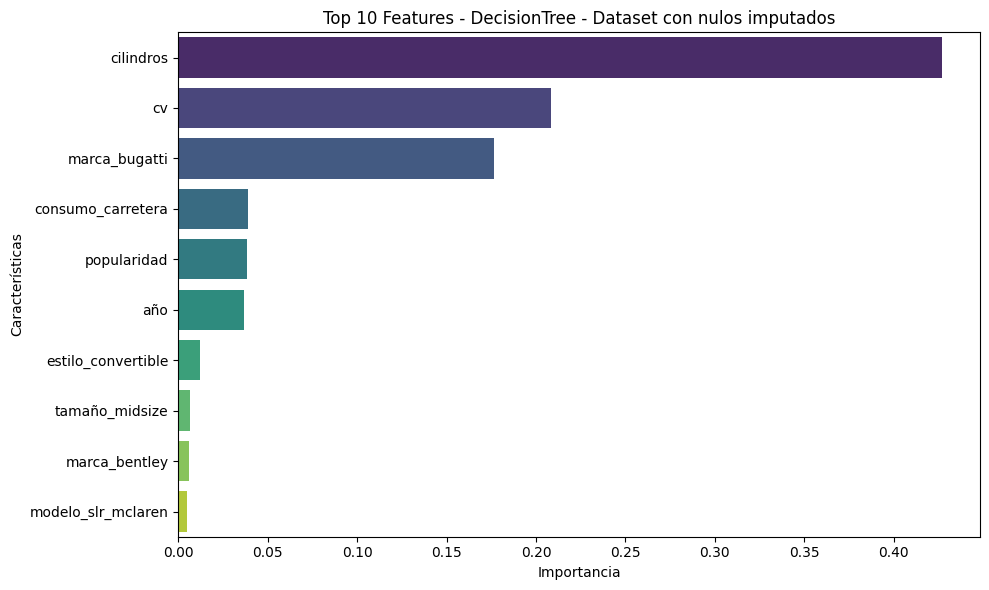

In [66]:
# Mostrar variables más importantes
plot_feature_importance(models_set["DecisionTree_clean"], Xc.columns, "DecisionTree - Dataset con nulos imputados")

Las variables que inicialmente identificamos como principales fueron:

- CV
- Cilindros​
- Mercado​
- Año​
- Consumo​

No obstante, observamos que en el análisis de feature importance ha aparecido en los primeros puestos la variable Popularidad, a pesar de no mostrar correlación lineal con ninguna otra variable numérica ni con el precio. Esto sugiere que podría estar capturando relaciones no lineales o efectos contextuales. Por ejemplo, un coche con baja potencia pero alta popularidad podría tener un precio diferente al de uno con características similares pero menor reconocimiento.

Además, ninguna de las categorías de la variable Mercado figura entre las más relevantes del *feature importance*. Sin embargo, esto no implica que la variable no sea útil. Dado que ha sido codificada mediante *one-hot encoding*, su relevancia puede haberse repartido entre muchas columnas individuales, diluyendo su impacto en el ranking global. El hecho de que existan diferencias en el rendimiento entre los modelos con nulos eliminados e imputados sugiere que Mercado aporta valor predictivo, aunque su efecto esté distribuido.

Para confirmar la verdadera influencia de Popularidad, optamos por reentrenar el modelo excluyéndola. Si el rendimiento se ve afectado de forma significativa, podremos concluir que la variable sí contribuye a predecir el precio, aunque su relación con otras variables sea no lineal o contextual.

In [67]:
# Dataset imputado
Xi = df_imp.drop(columns=["precio", "imputado", "popularidad"]) # Imputamos popularidad
yi = df_imp["precio"]
Xi = pd.get_dummies(Xi, drop_first=True)

# Train/test split 80/20
seed = 55555
Xi_train, Xi_test, yi_train, yi_test = train_test_split(Xi, yi, test_size=0.2, random_state=seed)

# Hiperparámetros
param_grids = {
    "DecisionTree": {
        "max_depth": [20],
        "min_samples_split": [5],
        "min_samples_leaf": [1]
    }
}

# Entrenar y evaluar modelo
best_model = train_evaluate(models["DecisionTree"], 
                            param_grids["DecisionTree"], 
                            Xi_train, Xi_test, yi_train, yi_test, 
                            f"{name} / con nulos imputados")
best_model


--- XGBoost / con nulos imputados ---
Mejores hiperparámetros: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5}
MAE:  3232.23
RMSE: 6586.32
R²:   0.9812


DecisionTreeRegressor(max_depth=20, min_samples_split=5, random_state=55555)

Dado que el modelo ha mantenido su rendimiento constante, podemos concluir que la popularidad no afecta de forma significativa a la predicción del precio.

## 6. Conclusiones

A lo largo de este proyecto hemos aplicado la metodología CRISP-DM para abordar la predicción del precio de vehículos de segunda mano. Partimos de un profundo análisis del negocio y exploración de los datos (EDA), lo que nos permitió identificar variables clave, detectar valores atípicos y entender la estructura de los datos, tanto desde un enfoque descriptivo como diagnóstico.

Implementamos dos estrategias paralelas de tratamiento de nulos: una basada en la eliminación de registros incompletos y otra en la imputación mediante subgrupos definidos con criterio lógico. Ambas versiones se modelaron con algoritmos robustos como **Random Forest**, **XGBoost** y **Árboles de Decisión**, evaluando su rendimiento mediante métricas de regresión.

El análisis de feature importance confirmó la relevancia de variables como CV, cilindros, año, consumo y mercado, y descartó otras como popularidad. Este resultado destaca la importancia de validar no solo la correlación lineal entre variables, sino también su impacto real en el modelo predictivo.

En definitiva, hemos construido un modelo capaz de estimar con alta precisión el precio de un vehículo en función de sus características técnicas y comerciales, manteniendo una trazabilidad clara de las decisiones tomadas y priorizando siempre la interpretabilidad del proceso.